In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import time
from torch.nn import init
from thop import profile


In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []
PATH = "D:/conda/111_1117/FullAll_3LayerModel_CNNSmall.pt"
for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x    
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x   
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

In [9]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out


In [10]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [11]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [12]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
        
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [13]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [14]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 15):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [15]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [16]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model


Subject 1
| epoch   0 | 0.3473 s/epoch | train loss 0.4406
| epoch   1 | 0.2782 s/epoch | train loss 0.4101
| epoch   2 | 0.2827 s/epoch | train loss 0.3363
| epoch   3 | 0.2790 s/epoch | train loss 0.3089
| epoch   4 | 0.2817 s/epoch | train loss 0.2809
| epoch   5 | 0.2804 s/epoch | train loss 0.2725
| epoch   6 | 0.2826 s/epoch | train loss 0.5142
| epoch   7 | 0.2802 s/epoch | train loss 0.3551
| epoch   8 | 0.2831 s/epoch | train loss 0.3449
| epoch   9 | 0.2768 s/epoch | train loss 0.3238
| epoch  10 | 0.2792 s/epoch | train loss 0.3283
| epoch  11 | 0.2800 s/epoch | train loss 0.3457
| epoch  12 | 0.2813 s/epoch | train loss 0.3405
| epoch  13 | 0.2826 s/epoch | train loss 0.3264
| epoch  14 | 0.2766 s/epoch | train loss 0.3253
| epoch  15 | 0.2823 s/epoch | train loss 0.3891
| epoch  16 | 0.2833 s/epoch | train loss 0.3410
| epoch  17 | 0.2906 s/epoch | train loss 0.3822
| epoch  18 | 0.3014 s/epoch | train loss 0.3572
| epoch  19 | 0.2770 s/epoch | train loss 0.3330
| epoch  

| epoch 167 | 0.2962 s/epoch | train loss 0.1221
| epoch 168 | 0.2956 s/epoch | train loss 0.1151
| epoch 169 | 0.2937 s/epoch | train loss 0.0971
| epoch 170 | 0.2951 s/epoch | train loss 0.1169
| epoch 171 | 0.2948 s/epoch | train loss 0.1616
| epoch 172 | 0.2914 s/epoch | train loss 0.1369
| epoch 173 | 0.2929 s/epoch | train loss 0.1264
| epoch 174 | 0.2915 s/epoch | train loss 0.1008
| epoch 175 | 0.2960 s/epoch | train loss 0.0992
| epoch 176 | 0.2943 s/epoch | train loss 0.1440
| epoch 177 | 0.2930 s/epoch | train loss 0.1508
| epoch 178 | 0.2890 s/epoch | train loss 0.1143
| epoch 179 | 0.2858 s/epoch | train loss 0.1012
| epoch 180 | 0.2835 s/epoch | train loss 0.0936
| epoch 181 | 0.2866 s/epoch | train loss 0.1237
| epoch 182 | 0.2880 s/epoch | train loss 0.1025
| epoch 183 | 0.2887 s/epoch | train loss 0.0823
| epoch 184 | 0.2889 s/epoch | train loss 0.0945
| epoch 185 | 0.2892 s/epoch | train loss 0.0781
| epoch 186 | 0.2919 s/epoch | train loss 0.0854
| epoch 187 | 0.2939

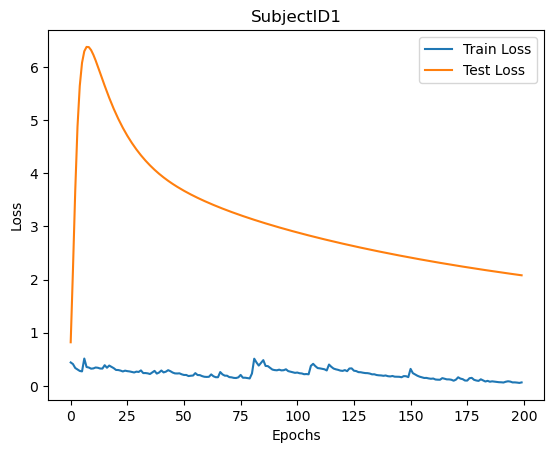

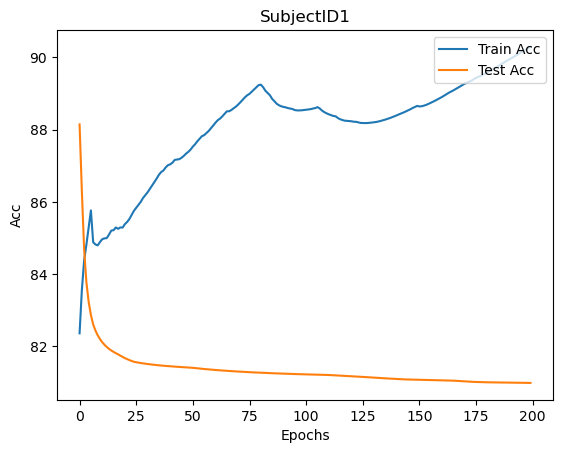

| epoch   0 | 0.0108 s/epoch | train loss 0.4638
| epoch   1 | 0.0093 s/epoch | train loss 0.3818
| epoch   2 | 0.0102 s/epoch | train loss 0.3712
| epoch   3 | 0.0107 s/epoch | train loss 0.3645
| epoch   4 | 0.0101 s/epoch | train loss 0.3603
| epoch   5 | 0.0094 s/epoch | train loss 0.3474
| epoch   6 | 0.0092 s/epoch | train loss 0.3431
| epoch   7 | 0.0096 s/epoch | train loss 0.3453
| epoch   8 | 0.0097 s/epoch | train loss 0.3331
| epoch   9 | 0.0099 s/epoch | train loss 0.3280
| epoch  10 | 0.0095 s/epoch | train loss 0.3256
| epoch  11 | 0.0105 s/epoch | train loss 0.3134
| epoch  12 | 0.0105 s/epoch | train loss 0.3132
| epoch  13 | 0.0098 s/epoch | train loss 0.3123
| epoch  14 | 0.0098 s/epoch | train loss 0.3078
| epoch  15 | 0.0102 s/epoch | train loss 0.2981
| epoch  16 | 0.0097 s/epoch | train loss 0.2998
| epoch  17 | 0.0101 s/epoch | train loss 0.2981
| epoch  18 | 0.0121 s/epoch | train loss 0.2891
| epoch  19 | 0.0106 s/epoch | train loss 0.2840
| epoch  20 | 0.0099

| epoch 168 | 0.0104 s/epoch | train loss 0.0228
| epoch 169 | 0.0095 s/epoch | train loss 0.0375
| epoch 170 | 0.0102 s/epoch | train loss 0.0210
| epoch 171 | 0.0114 s/epoch | train loss 0.0273
| epoch 172 | 0.0101 s/epoch | train loss 0.0479
| epoch 173 | 0.0109 s/epoch | train loss 0.0186
| epoch 174 | 0.0098 s/epoch | train loss 0.0160
| epoch 175 | 0.0098 s/epoch | train loss 0.0158
| epoch 176 | 0.0104 s/epoch | train loss 0.0469
| epoch 177 | 0.0103 s/epoch | train loss 0.0212
| epoch 178 | 0.0100 s/epoch | train loss 0.0220
| epoch 179 | 0.0095 s/epoch | train loss 0.0225
| epoch 180 | 0.0103 s/epoch | train loss 0.0268
| epoch 181 | 0.0102 s/epoch | train loss 0.0372
| epoch 182 | 0.0096 s/epoch | train loss 0.0847
| epoch 183 | 0.0111 s/epoch | train loss 0.0176
| epoch 184 | 0.0099 s/epoch | train loss 0.0379
| epoch 185 | 0.0105 s/epoch | train loss 0.0234
| epoch 186 | 0.0096 s/epoch | train loss 0.0147
| epoch 187 | 0.0097 s/epoch | train loss 0.0163
| epoch 188 | 0.0099

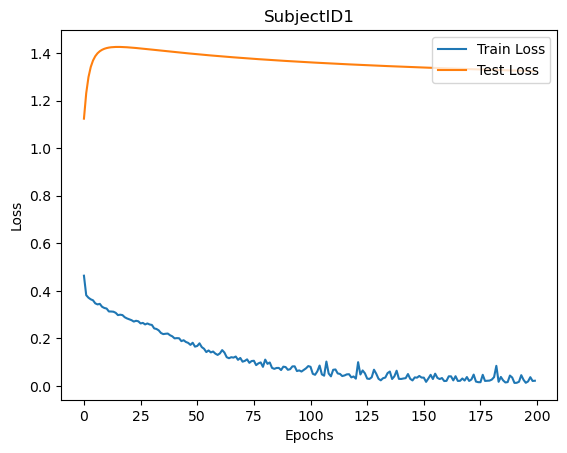

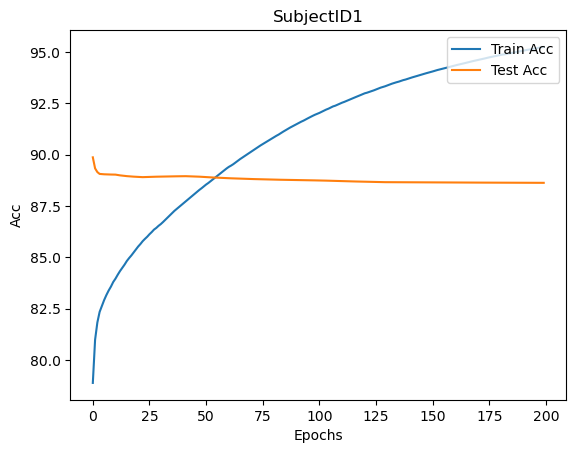


Subject 2
| epoch   0 | 0.2789 s/epoch | train loss 0.4753
| epoch   1 | 0.2773 s/epoch | train loss 0.4001
| epoch   2 | 0.2788 s/epoch | train loss 0.4259
| epoch   3 | 0.2808 s/epoch | train loss 0.4000
| epoch   4 | 0.2778 s/epoch | train loss 0.4327
| epoch   5 | 0.2781 s/epoch | train loss 0.3465
| epoch   6 | 0.2786 s/epoch | train loss 0.4127
| epoch   7 | 0.2679 s/epoch | train loss 0.3916
| epoch   8 | 0.2699 s/epoch | train loss 0.3585
| epoch   9 | 0.2712 s/epoch | train loss 0.3616
| epoch  10 | 0.2692 s/epoch | train loss 0.3552
| epoch  11 | 0.2697 s/epoch | train loss 0.3830
| epoch  12 | 0.2700 s/epoch | train loss 0.4310
| epoch  13 | 0.2768 s/epoch | train loss 0.3817
| epoch  14 | 0.2691 s/epoch | train loss 0.3481
| epoch  15 | 0.2675 s/epoch | train loss 0.3267
| epoch  16 | 0.2660 s/epoch | train loss 0.3549
| epoch  17 | 0.2681 s/epoch | train loss 0.3554
| epoch  18 | 0.2662 s/epoch | train loss 0.3416
| epoch  19 | 0.2668 s/epoch | train loss 0.3605
| epoch  

| epoch 167 | 0.2682 s/epoch | train loss 0.2847
| epoch 168 | 0.2674 s/epoch | train loss 0.4889
| epoch 169 | 0.2653 s/epoch | train loss 0.3798
| epoch 170 | 0.2657 s/epoch | train loss 0.3430
| epoch 171 | 0.2665 s/epoch | train loss 0.3289
| epoch 172 | 0.2659 s/epoch | train loss 0.4135
| epoch 173 | 0.2654 s/epoch | train loss 0.3127
| epoch 174 | 0.2641 s/epoch | train loss 0.2729
| epoch 175 | 0.2641 s/epoch | train loss 0.3009
| epoch 176 | 0.2638 s/epoch | train loss 0.2679
| epoch 177 | 0.2646 s/epoch | train loss 0.2908
| epoch 178 | 0.2654 s/epoch | train loss 0.2802
| epoch 179 | 0.2624 s/epoch | train loss 0.2632
| epoch 180 | 0.2638 s/epoch | train loss 0.2692
| epoch 181 | 0.2631 s/epoch | train loss 0.2129
| epoch 182 | 0.2647 s/epoch | train loss 0.1999
| epoch 183 | 0.2652 s/epoch | train loss 0.2207
| epoch 184 | 0.2660 s/epoch | train loss 0.2059
| epoch 185 | 0.2641 s/epoch | train loss 0.2445
| epoch 186 | 0.2655 s/epoch | train loss 0.1903
| epoch 187 | 0.2628

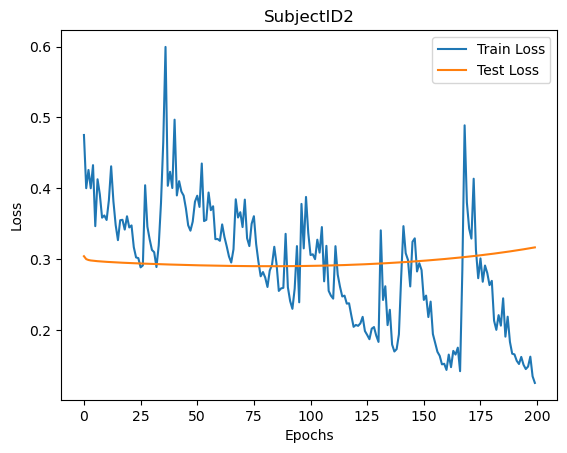

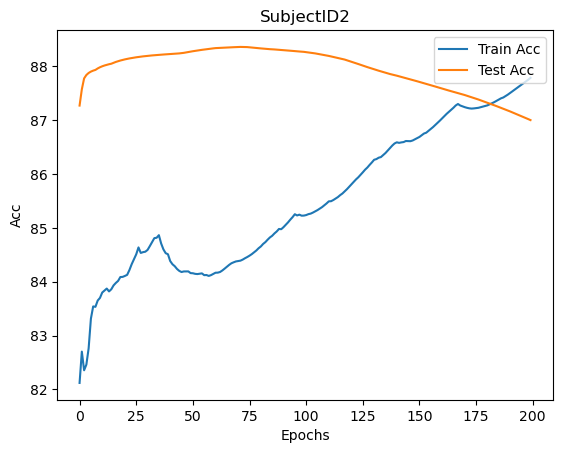

| epoch   0 | 0.0091 s/epoch | train loss 0.4541
| epoch   1 | 0.0086 s/epoch | train loss 0.3806
| epoch   2 | 0.0096 s/epoch | train loss 0.3740
| epoch   3 | 0.0088 s/epoch | train loss 0.3682
| epoch   4 | 0.0094 s/epoch | train loss 0.3580
| epoch   5 | 0.0083 s/epoch | train loss 0.3624
| epoch   6 | 0.0092 s/epoch | train loss 0.3441
| epoch   7 | 0.0082 s/epoch | train loss 0.3422
| epoch   8 | 0.0086 s/epoch | train loss 0.3380
| epoch   9 | 0.0101 s/epoch | train loss 0.3410
| epoch  10 | 0.0086 s/epoch | train loss 0.3339
| epoch  11 | 0.0081 s/epoch | train loss 0.3427
| epoch  12 | 0.0099 s/epoch | train loss 0.3264
| epoch  13 | 0.0088 s/epoch | train loss 0.3199
| epoch  14 | 0.0086 s/epoch | train loss 0.3275
| epoch  15 | 0.0098 s/epoch | train loss 0.3126
| epoch  16 | 0.0088 s/epoch | train loss 0.3123
| epoch  17 | 0.0090 s/epoch | train loss 0.3073
| epoch  18 | 0.0093 s/epoch | train loss 0.3092
| epoch  19 | 0.0090 s/epoch | train loss 0.3056
| epoch  20 | 0.0086

| epoch 168 | 0.0090 s/epoch | train loss 0.0246
| epoch 169 | 0.0087 s/epoch | train loss 0.0337
| epoch 170 | 0.0091 s/epoch | train loss 0.0267
| epoch 171 | 0.0089 s/epoch | train loss 0.0286
| epoch 172 | 0.0088 s/epoch | train loss 0.0479
| epoch 173 | 0.0094 s/epoch | train loss 0.0220
| epoch 174 | 0.0083 s/epoch | train loss 0.0434
| epoch 175 | 0.0094 s/epoch | train loss 0.0165
| epoch 176 | 0.0092 s/epoch | train loss 0.0528
| epoch 177 | 0.0087 s/epoch | train loss 0.0204
| epoch 178 | 0.0095 s/epoch | train loss 0.0167
| epoch 179 | 0.0090 s/epoch | train loss 0.0390
| epoch 180 | 0.0088 s/epoch | train loss 0.1337
| epoch 181 | 0.0086 s/epoch | train loss 0.0401
| epoch 182 | 0.0090 s/epoch | train loss 0.0210
| epoch 183 | 0.0089 s/epoch | train loss 0.0179
| epoch 184 | 0.0091 s/epoch | train loss 0.0168
| epoch 185 | 0.0084 s/epoch | train loss 0.0296
| epoch 186 | 0.0088 s/epoch | train loss 0.0324
| epoch 187 | 0.0097 s/epoch | train loss 0.0553
| epoch 188 | 0.0084

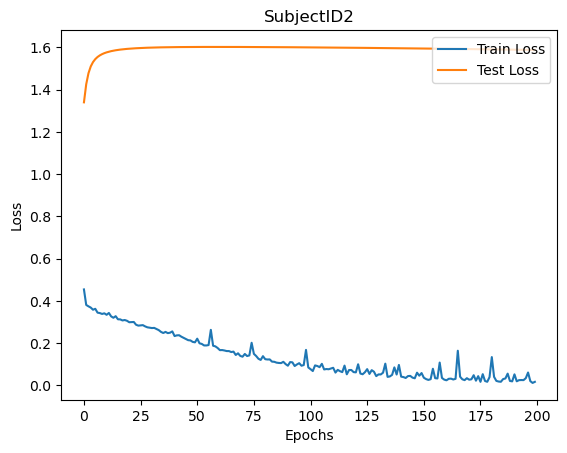

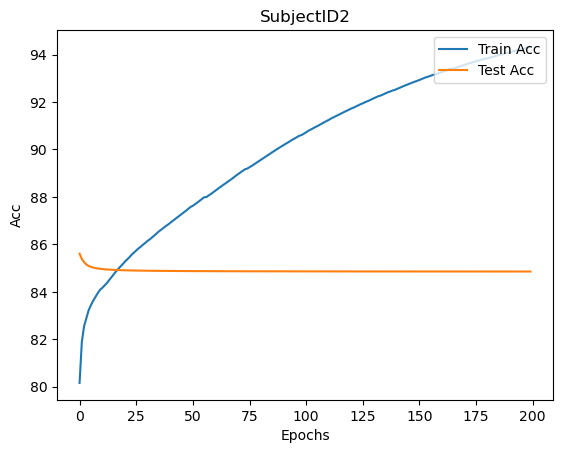


Subject 3
| epoch   0 | 0.2669 s/epoch | train loss 0.4756
| epoch   1 | 0.2666 s/epoch | train loss 0.3508
| epoch   2 | 0.2658 s/epoch | train loss 0.3159
| epoch   3 | 0.2650 s/epoch | train loss 0.2922
| epoch   4 | 0.2664 s/epoch | train loss 0.3103
| epoch   5 | 0.2643 s/epoch | train loss 0.3322
| epoch   6 | 0.2641 s/epoch | train loss 0.2942
| epoch   7 | 0.2648 s/epoch | train loss 0.2879
| epoch   8 | 0.2655 s/epoch | train loss 0.3079
| epoch   9 | 0.2656 s/epoch | train loss 0.2905
| epoch  10 | 0.2659 s/epoch | train loss 0.2965
| epoch  11 | 0.2669 s/epoch | train loss 0.2840
| epoch  12 | 0.2655 s/epoch | train loss 0.2657
| epoch  13 | 0.2666 s/epoch | train loss 0.2586
| epoch  14 | 0.2630 s/epoch | train loss 0.2472
| epoch  15 | 0.2668 s/epoch | train loss 0.2405
| epoch  16 | 0.2655 s/epoch | train loss 0.2305
| epoch  17 | 0.2650 s/epoch | train loss 0.2301
| epoch  18 | 0.2673 s/epoch | train loss 0.4382
| epoch  19 | 0.2643 s/epoch | train loss 0.3414
| epoch  

| epoch 167 | 0.2668 s/epoch | train loss 0.0461
| epoch 168 | 0.2651 s/epoch | train loss 0.0464
| epoch 169 | 0.2662 s/epoch | train loss 0.0474
| epoch 170 | 0.2675 s/epoch | train loss 0.0424
| epoch 171 | 0.2670 s/epoch | train loss 0.0581
| epoch 172 | 0.2680 s/epoch | train loss 0.0523
| epoch 173 | 0.2677 s/epoch | train loss 0.0457
| epoch 174 | 0.2688 s/epoch | train loss 0.0464
| epoch 175 | 0.2689 s/epoch | train loss 0.0764
| epoch 176 | 0.2668 s/epoch | train loss 0.0425
| epoch 177 | 0.2678 s/epoch | train loss 0.0468
| epoch 178 | 0.2673 s/epoch | train loss 0.0302
| epoch 179 | 0.2709 s/epoch | train loss 0.0304
| epoch 180 | 0.2715 s/epoch | train loss 0.0376
| epoch 181 | 0.2691 s/epoch | train loss 0.0674
| epoch 182 | 0.2689 s/epoch | train loss 0.0457
| epoch 183 | 0.2670 s/epoch | train loss 0.0385
| epoch 184 | 0.2683 s/epoch | train loss 0.0418
| epoch 185 | 0.2687 s/epoch | train loss 0.0398
| epoch 186 | 0.2671 s/epoch | train loss 0.0397
| epoch 187 | 0.2670

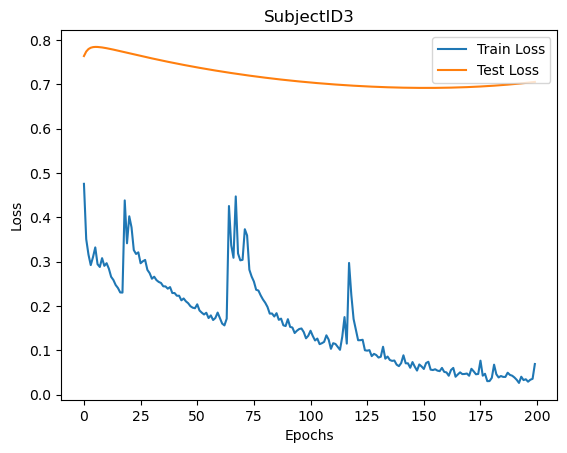

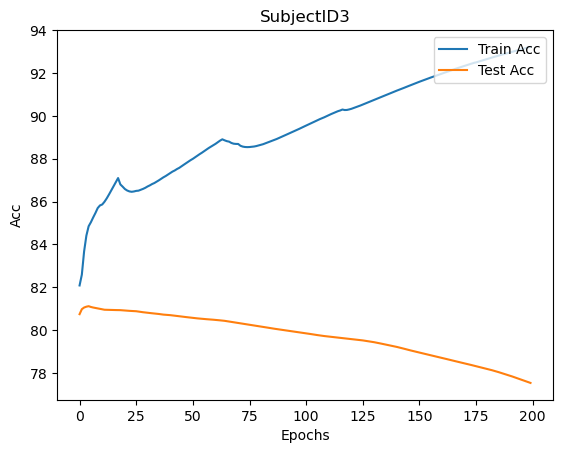

| epoch   0 | 0.0091 s/epoch | train loss 0.4693
| epoch   1 | 0.0093 s/epoch | train loss 0.3698
| epoch   2 | 0.0090 s/epoch | train loss 0.3548
| epoch   3 | 0.0095 s/epoch | train loss 0.3481
| epoch   4 | 0.0093 s/epoch | train loss 0.3502
| epoch   5 | 0.0091 s/epoch | train loss 0.3401
| epoch   6 | 0.0093 s/epoch | train loss 0.3394
| epoch   7 | 0.0091 s/epoch | train loss 0.3254
| epoch   8 | 0.0095 s/epoch | train loss 0.3249
| epoch   9 | 0.0091 s/epoch | train loss 0.3196
| epoch  10 | 0.0096 s/epoch | train loss 0.3166
| epoch  11 | 0.0089 s/epoch | train loss 0.3138
| epoch  12 | 0.0091 s/epoch | train loss 0.3065
| epoch  13 | 0.0093 s/epoch | train loss 0.3012
| epoch  14 | 0.0088 s/epoch | train loss 0.3020
| epoch  15 | 0.0088 s/epoch | train loss 0.2943
| epoch  16 | 0.0094 s/epoch | train loss 0.2946
| epoch  17 | 0.0091 s/epoch | train loss 0.2849
| epoch  18 | 0.0087 s/epoch | train loss 0.2801
| epoch  19 | 0.0093 s/epoch | train loss 0.2802
| epoch  20 | 0.0090

| epoch 168 | 0.0089 s/epoch | train loss 0.0304
| epoch 169 | 0.0090 s/epoch | train loss 0.0172
| epoch 170 | 0.0095 s/epoch | train loss 0.0119
| epoch 171 | 0.0088 s/epoch | train loss 0.0277
| epoch 172 | 0.0089 s/epoch | train loss 0.0342
| epoch 173 | 0.0089 s/epoch | train loss 0.0333
| epoch 174 | 0.0085 s/epoch | train loss 0.0168
| epoch 175 | 0.0094 s/epoch | train loss 0.0191
| epoch 176 | 0.0091 s/epoch | train loss 0.0134
| epoch 177 | 0.0091 s/epoch | train loss 0.0146
| epoch 178 | 0.0092 s/epoch | train loss 0.0183
| epoch 179 | 0.0088 s/epoch | train loss 0.0484
| epoch 180 | 0.0098 s/epoch | train loss 0.0112
| epoch 181 | 0.0095 s/epoch | train loss 0.0123
| epoch 182 | 0.0091 s/epoch | train loss 0.0398
| epoch 183 | 0.0093 s/epoch | train loss 0.0465
| epoch 184 | 0.0098 s/epoch | train loss 0.0103
| epoch 185 | 0.0095 s/epoch | train loss 0.0284
| epoch 186 | 0.0098 s/epoch | train loss 0.0451
| epoch 187 | 0.0089 s/epoch | train loss 0.0262
| epoch 188 | 0.0090

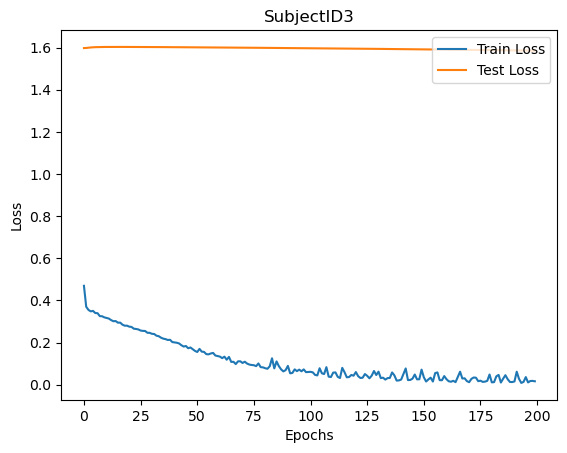

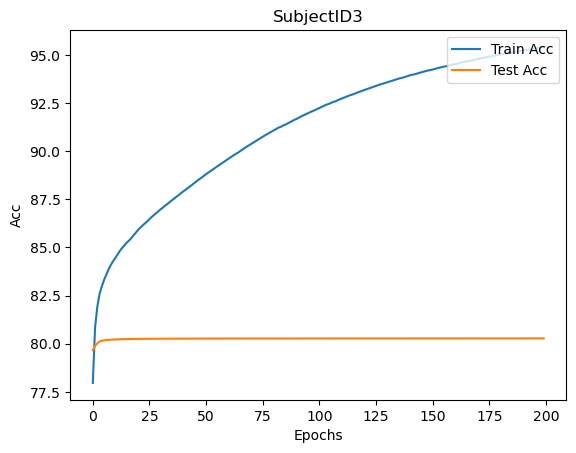


Subject 4
| epoch   0 | 0.2809 s/epoch | train loss 0.4950
| epoch   1 | 0.2793 s/epoch | train loss 0.3643
| epoch   2 | 0.2795 s/epoch | train loss 0.3374
| epoch   3 | 0.2799 s/epoch | train loss 0.3188
| epoch   4 | 0.2803 s/epoch | train loss 0.2938
| epoch   5 | 0.2778 s/epoch | train loss 0.2810
| epoch   6 | 0.2799 s/epoch | train loss 0.2773
| epoch   7 | 0.2787 s/epoch | train loss 0.2718
| epoch   8 | 0.2806 s/epoch | train loss 0.2580
| epoch   9 | 0.2806 s/epoch | train loss 0.2616
| epoch  10 | 0.2817 s/epoch | train loss 0.2445
| epoch  11 | 0.2812 s/epoch | train loss 0.2440
| epoch  12 | 0.2807 s/epoch | train loss 0.2439
| epoch  13 | 0.2818 s/epoch | train loss 0.2335
| epoch  14 | 0.2809 s/epoch | train loss 0.2318
| epoch  15 | 0.2790 s/epoch | train loss 0.2149
| epoch  16 | 0.2821 s/epoch | train loss 0.2149
| epoch  17 | 0.2815 s/epoch | train loss 0.2080
| epoch  18 | 0.2811 s/epoch | train loss 0.2189
| epoch  19 | 0.2820 s/epoch | train loss 0.2202
| epoch  

| epoch 167 | 0.2814 s/epoch | train loss 0.1603
| epoch 168 | 0.2816 s/epoch | train loss 0.1481
| epoch 169 | 0.2815 s/epoch | train loss 0.1256
| epoch 170 | 0.2807 s/epoch | train loss 0.1132
| epoch 171 | 0.2804 s/epoch | train loss 0.3133
| epoch 172 | 0.2804 s/epoch | train loss 0.2697
| epoch 173 | 0.2807 s/epoch | train loss 0.2267
| epoch 174 | 0.2817 s/epoch | train loss 0.1952
| epoch 175 | 0.2803 s/epoch | train loss 0.1686
| epoch 176 | 0.2820 s/epoch | train loss 0.1466
| epoch 177 | 0.2816 s/epoch | train loss 0.1445
| epoch 178 | 0.2784 s/epoch | train loss 0.1277
| epoch 179 | 0.2788 s/epoch | train loss 0.1169
| epoch 180 | 0.2802 s/epoch | train loss 0.1062
| epoch 181 | 0.2784 s/epoch | train loss 0.1060
| epoch 182 | 0.2779 s/epoch | train loss 0.0987
| epoch 183 | 0.2784 s/epoch | train loss 0.0915
| epoch 184 | 0.2783 s/epoch | train loss 0.1013
| epoch 185 | 0.2783 s/epoch | train loss 0.0884
| epoch 186 | 0.2779 s/epoch | train loss 0.0841
| epoch 187 | 0.2779

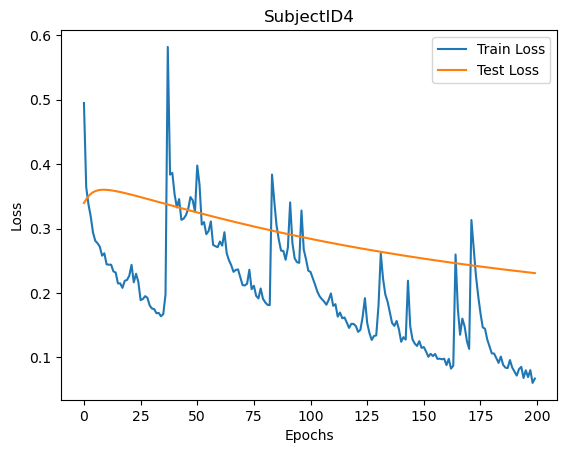

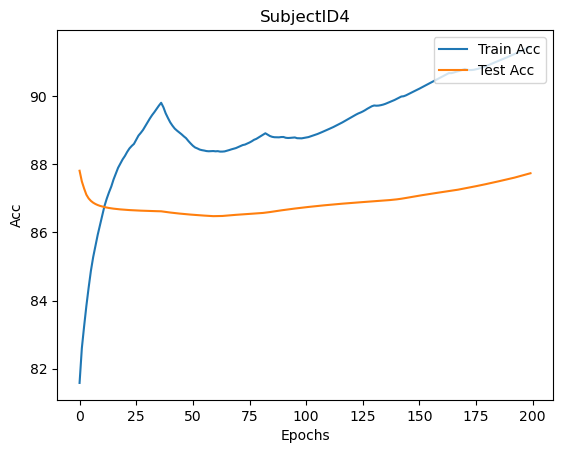

| epoch   0 | 0.0087 s/epoch | train loss 0.4539
| epoch   1 | 0.0095 s/epoch | train loss 0.3849
| epoch   2 | 0.0104 s/epoch | train loss 0.3750
| epoch   3 | 0.0091 s/epoch | train loss 0.3629
| epoch   4 | 0.0097 s/epoch | train loss 0.3568
| epoch   5 | 0.0094 s/epoch | train loss 0.3517
| epoch   6 | 0.0104 s/epoch | train loss 0.3469
| epoch   7 | 0.0097 s/epoch | train loss 0.3381
| epoch   8 | 0.0095 s/epoch | train loss 0.3323
| epoch   9 | 0.0091 s/epoch | train loss 0.3288
| epoch  10 | 0.0096 s/epoch | train loss 0.3235
| epoch  11 | 0.0098 s/epoch | train loss 0.3190
| epoch  12 | 0.0090 s/epoch | train loss 0.3195
| epoch  13 | 0.0090 s/epoch | train loss 0.3097
| epoch  14 | 0.0094 s/epoch | train loss 0.3069
| epoch  15 | 0.0104 s/epoch | train loss 0.3091
| epoch  16 | 0.0093 s/epoch | train loss 0.2989
| epoch  17 | 0.0101 s/epoch | train loss 0.2924
| epoch  18 | 0.0095 s/epoch | train loss 0.3000
| epoch  19 | 0.0090 s/epoch | train loss 0.2933
| epoch  20 | 0.0097

| epoch 168 | 0.0094 s/epoch | train loss 0.0154
| epoch 169 | 0.0097 s/epoch | train loss 0.0238
| epoch 170 | 0.0095 s/epoch | train loss 0.0346
| epoch 171 | 0.0090 s/epoch | train loss 0.0448
| epoch 172 | 0.0098 s/epoch | train loss 0.0175
| epoch 173 | 0.0095 s/epoch | train loss 0.0215
| epoch 174 | 0.0098 s/epoch | train loss 0.0222
| epoch 175 | 0.0095 s/epoch | train loss 0.0267
| epoch 176 | 0.0094 s/epoch | train loss 0.0291
| epoch 177 | 0.0096 s/epoch | train loss 0.0681
| epoch 178 | 0.0102 s/epoch | train loss 0.0161
| epoch 179 | 0.0094 s/epoch | train loss 0.0124
| epoch 180 | 0.0095 s/epoch | train loss 0.0209
| epoch 181 | 0.0093 s/epoch | train loss 0.0232
| epoch 182 | 0.0090 s/epoch | train loss 0.0273
| epoch 183 | 0.0096 s/epoch | train loss 0.0450
| epoch 184 | 0.0094 s/epoch | train loss 0.0227
| epoch 185 | 0.0095 s/epoch | train loss 0.0097
| epoch 186 | 0.0094 s/epoch | train loss 0.0193
| epoch 187 | 0.0092 s/epoch | train loss 0.0560
| epoch 188 | 0.0100

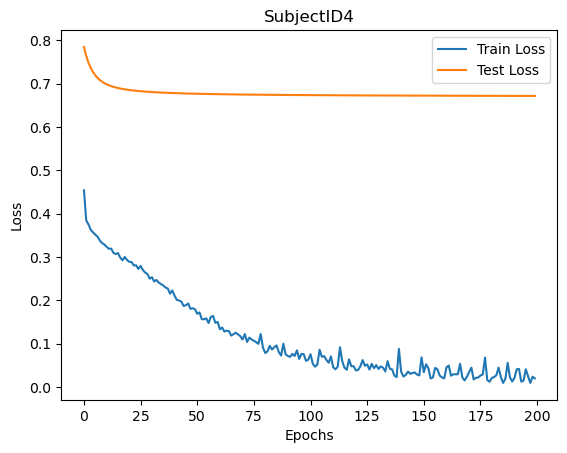

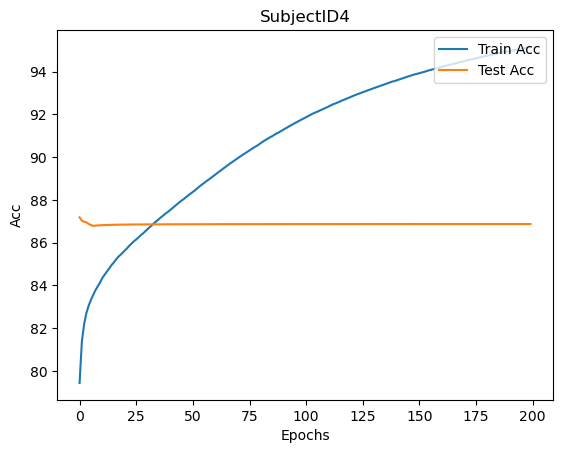


Subject 5
| epoch   0 | 0.2652 s/epoch | train loss 0.4792
| epoch   1 | 0.2649 s/epoch | train loss 0.3419
| epoch   2 | 0.2670 s/epoch | train loss 0.3100
| epoch   3 | 0.2658 s/epoch | train loss 0.2915
| epoch   4 | 0.2655 s/epoch | train loss 0.2943
| epoch   5 | 0.2679 s/epoch | train loss 0.2854
| epoch   6 | 0.2645 s/epoch | train loss 0.2632
| epoch   7 | 0.2667 s/epoch | train loss 0.2884
| epoch   8 | 0.2663 s/epoch | train loss 0.3040
| epoch   9 | 0.2638 s/epoch | train loss 0.2695
| epoch  10 | 0.2686 s/epoch | train loss 0.2595
| epoch  11 | 0.2666 s/epoch | train loss 0.2331
| epoch  12 | 0.2653 s/epoch | train loss 0.2473
| epoch  13 | 0.2679 s/epoch | train loss 0.2346
| epoch  14 | 0.2692 s/epoch | train loss 0.2103
| epoch  15 | 0.2672 s/epoch | train loss 0.2280
| epoch  16 | 0.2678 s/epoch | train loss 0.2036
| epoch  17 | 0.2665 s/epoch | train loss 0.2102
| epoch  18 | 0.2652 s/epoch | train loss 0.2020
| epoch  19 | 0.2658 s/epoch | train loss 0.1875
| epoch  

| epoch 167 | 0.2671 s/epoch | train loss 0.0528
| epoch 168 | 0.2680 s/epoch | train loss 0.0524
| epoch 169 | 0.2679 s/epoch | train loss 0.0539
| epoch 170 | 0.2697 s/epoch | train loss 0.0478
| epoch 171 | 0.2692 s/epoch | train loss 0.0412
| epoch 172 | 0.2692 s/epoch | train loss 0.0522
| epoch 173 | 0.2680 s/epoch | train loss 0.0488
| epoch 174 | 0.2721 s/epoch | train loss 0.0470
| epoch 175 | 0.2670 s/epoch | train loss 0.0350
| epoch 176 | 0.2687 s/epoch | train loss 0.0549
| epoch 177 | 0.2689 s/epoch | train loss 0.0500
| epoch 178 | 0.2696 s/epoch | train loss 0.0460
| epoch 179 | 0.2692 s/epoch | train loss 0.0395
| epoch 180 | 0.2692 s/epoch | train loss 0.0388
| epoch 181 | 0.2684 s/epoch | train loss 0.0375
| epoch 182 | 0.2680 s/epoch | train loss 0.0520
| epoch 183 | 0.2701 s/epoch | train loss 0.1115
| epoch 184 | 0.2694 s/epoch | train loss 0.0701
| epoch 185 | 0.2682 s/epoch | train loss 0.0545
| epoch 186 | 0.2690 s/epoch | train loss 0.0378
| epoch 187 | 0.2700

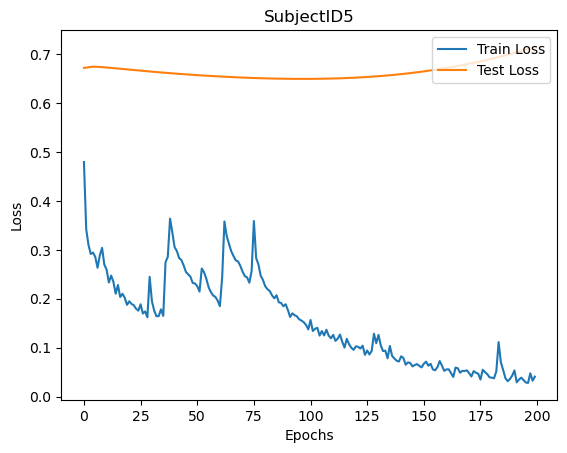

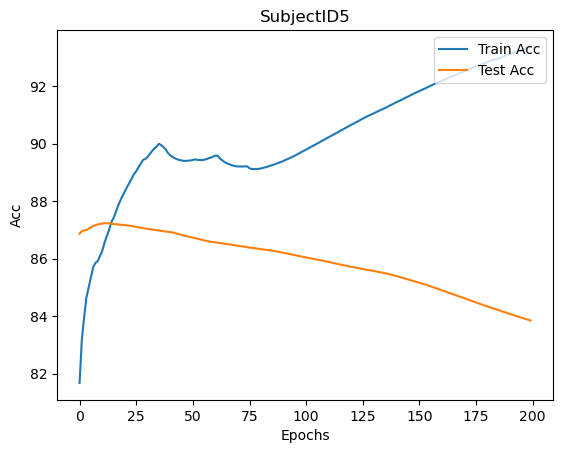

| epoch   0 | 0.0098 s/epoch | train loss 0.4676
| epoch   1 | 0.0094 s/epoch | train loss 0.3712
| epoch   2 | 0.0095 s/epoch | train loss 0.3632
| epoch   3 | 0.0087 s/epoch | train loss 0.3589
| epoch   4 | 0.0100 s/epoch | train loss 0.3547
| epoch   5 | 0.0085 s/epoch | train loss 0.3488
| epoch   6 | 0.0091 s/epoch | train loss 0.3445
| epoch   7 | 0.0101 s/epoch | train loss 0.3357
| epoch   8 | 0.0089 s/epoch | train loss 0.3324
| epoch   9 | 0.0093 s/epoch | train loss 0.3315
| epoch  10 | 0.0098 s/epoch | train loss 0.3237
| epoch  11 | 0.0102 s/epoch | train loss 0.3211
| epoch  12 | 0.0088 s/epoch | train loss 0.3171
| epoch  13 | 0.0095 s/epoch | train loss 0.3136
| epoch  14 | 0.0091 s/epoch | train loss 0.3098
| epoch  15 | 0.0084 s/epoch | train loss 0.3048
| epoch  16 | 0.0096 s/epoch | train loss 0.3039
| epoch  17 | 0.0098 s/epoch | train loss 0.3010
| epoch  18 | 0.0090 s/epoch | train loss 0.2958
| epoch  19 | 0.0089 s/epoch | train loss 0.2874
| epoch  20 | 0.0096

| epoch 168 | 0.0093 s/epoch | train loss 0.0329
| epoch 169 | 0.0088 s/epoch | train loss 0.0391
| epoch 170 | 0.0098 s/epoch | train loss 0.0341
| epoch 171 | 0.0097 s/epoch | train loss 0.0270
| epoch 172 | 0.0089 s/epoch | train loss 0.0114
| epoch 173 | 0.0093 s/epoch | train loss 0.0130
| epoch 174 | 0.0098 s/epoch | train loss 0.0136
| epoch 175 | 0.0088 s/epoch | train loss 0.0404
| epoch 176 | 0.0092 s/epoch | train loss 0.0281
| epoch 177 | 0.0096 s/epoch | train loss 0.0243
| epoch 178 | 0.0085 s/epoch | train loss 0.0386
| epoch 179 | 0.0087 s/epoch | train loss 0.0324
| epoch 180 | 0.0092 s/epoch | train loss 0.0339
| epoch 181 | 0.0091 s/epoch | train loss 0.0275
| epoch 182 | 0.0094 s/epoch | train loss 0.0455
| epoch 183 | 0.0094 s/epoch | train loss 0.0134
| epoch 184 | 0.0094 s/epoch | train loss 0.0133
| epoch 185 | 0.0097 s/epoch | train loss 0.0100
| epoch 186 | 0.0091 s/epoch | train loss 0.0109
| epoch 187 | 0.0091 s/epoch | train loss 0.0329
| epoch 188 | 0.0088

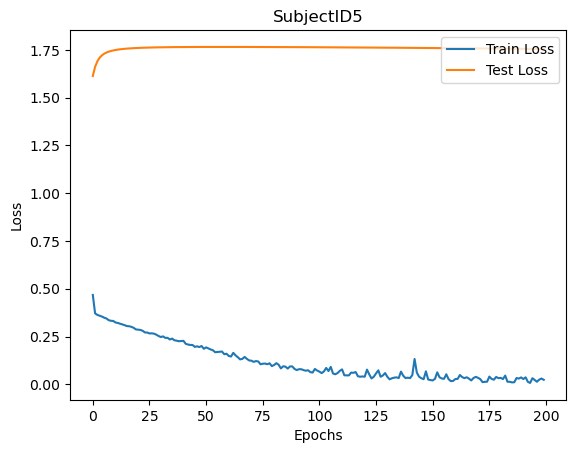

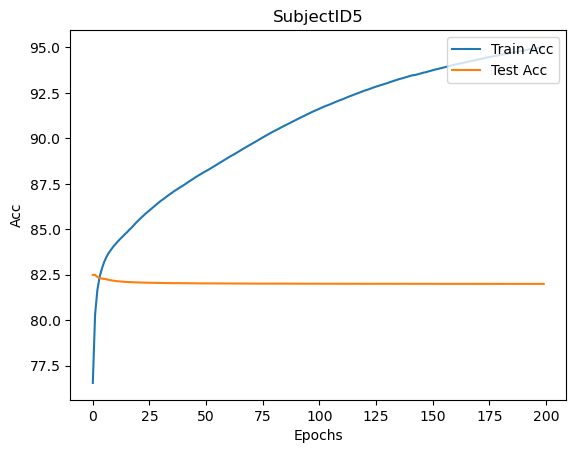


Subject 7
| epoch   0 | 0.2652 s/epoch | train loss 0.4860
| epoch   1 | 0.2609 s/epoch | train loss 0.3872
| epoch   2 | 0.2641 s/epoch | train loss 0.3189
| epoch   3 | 0.2629 s/epoch | train loss 0.2891
| epoch   4 | 0.2629 s/epoch | train loss 0.2913
| epoch   5 | 0.2619 s/epoch | train loss 0.2767
| epoch   6 | 0.2650 s/epoch | train loss 0.3018
| epoch   7 | 0.2640 s/epoch | train loss 0.3017
| epoch   8 | 0.2631 s/epoch | train loss 0.2789
| epoch   9 | 0.2623 s/epoch | train loss 0.2552
| epoch  10 | 0.2613 s/epoch | train loss 0.2450
| epoch  11 | 0.2627 s/epoch | train loss 0.2581
| epoch  12 | 0.2629 s/epoch | train loss 0.2813
| epoch  13 | 0.2634 s/epoch | train loss 0.2465
| epoch  14 | 0.2643 s/epoch | train loss 0.2382
| epoch  15 | 0.2631 s/epoch | train loss 0.2277
| epoch  16 | 0.2609 s/epoch | train loss 0.2130
| epoch  17 | 0.2646 s/epoch | train loss 0.2198
| epoch  18 | 0.2628 s/epoch | train loss 0.2138
| epoch  19 | 0.2645 s/epoch | train loss 0.2043
| epoch  

| epoch 167 | 0.2642 s/epoch | train loss 0.1944
| epoch 168 | 0.2623 s/epoch | train loss 0.2592
| epoch 169 | 0.2627 s/epoch | train loss 0.2341
| epoch 170 | 0.2654 s/epoch | train loss 0.2384
| epoch 171 | 0.2632 s/epoch | train loss 0.1770
| epoch 172 | 0.2642 s/epoch | train loss 0.1424
| epoch 173 | 0.2638 s/epoch | train loss 0.1298
| epoch 174 | 0.2632 s/epoch | train loss 0.1334
| epoch 175 | 0.2629 s/epoch | train loss 0.1362
| epoch 176 | 0.2635 s/epoch | train loss 0.1807
| epoch 177 | 0.2645 s/epoch | train loss 0.2377
| epoch 178 | 0.2635 s/epoch | train loss 0.1602
| epoch 179 | 0.2652 s/epoch | train loss 0.1308
| epoch 180 | 0.2626 s/epoch | train loss 0.1127
| epoch 181 | 0.2632 s/epoch | train loss 0.0979
| epoch 182 | 0.2626 s/epoch | train loss 0.1023
| epoch 183 | 0.2633 s/epoch | train loss 0.1246
| epoch 184 | 0.2631 s/epoch | train loss 0.0948
| epoch 185 | 0.2650 s/epoch | train loss 0.0875
| epoch 186 | 0.2657 s/epoch | train loss 0.1063
| epoch 187 | 0.2648

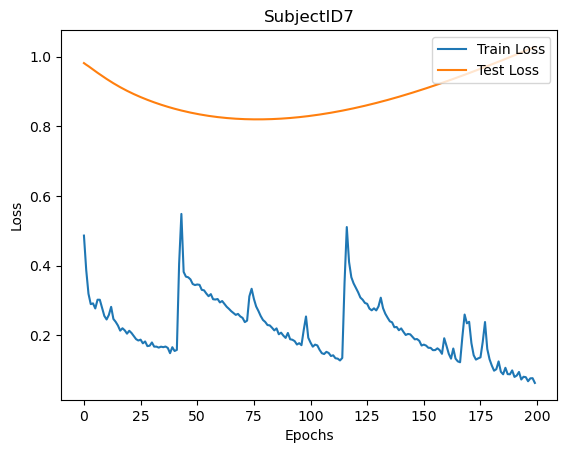

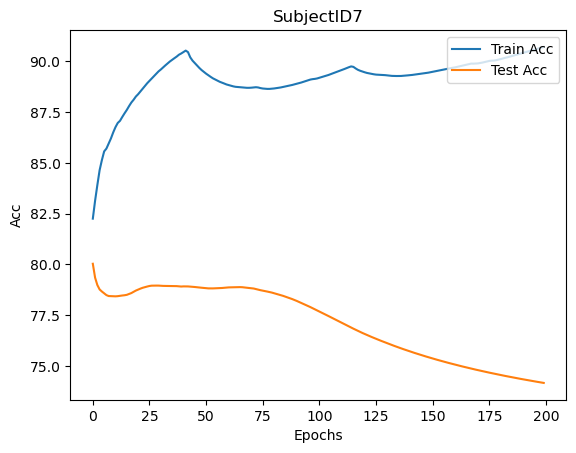

| epoch   0 | 0.0092 s/epoch | train loss 0.4530
| epoch   1 | 0.0094 s/epoch | train loss 0.3562
| epoch   2 | 0.0094 s/epoch | train loss 0.3533
| epoch   3 | 0.0089 s/epoch | train loss 0.3450
| epoch   4 | 0.0092 s/epoch | train loss 0.3375
| epoch   5 | 0.0084 s/epoch | train loss 0.3292
| epoch   6 | 0.0090 s/epoch | train loss 0.3242
| epoch   7 | 0.0088 s/epoch | train loss 0.3216
| epoch   8 | 0.0084 s/epoch | train loss 0.3214
| epoch   9 | 0.0081 s/epoch | train loss 0.3058
| epoch  10 | 0.0094 s/epoch | train loss 0.2998
| epoch  11 | 0.0092 s/epoch | train loss 0.2956
| epoch  12 | 0.0091 s/epoch | train loss 0.2933
| epoch  13 | 0.0096 s/epoch | train loss 0.2850
| epoch  14 | 0.0086 s/epoch | train loss 0.2800
| epoch  15 | 0.0090 s/epoch | train loss 0.2768
| epoch  16 | 0.0085 s/epoch | train loss 0.2682
| epoch  17 | 0.0101 s/epoch | train loss 0.2788
| epoch  18 | 0.0097 s/epoch | train loss 0.2703
| epoch  19 | 0.0090 s/epoch | train loss 0.2701
| epoch  20 | 0.0089

| epoch 168 | 0.0089 s/epoch | train loss 0.0164
| epoch 169 | 0.0086 s/epoch | train loss 0.0288
| epoch 170 | 0.0090 s/epoch | train loss 0.0516
| epoch 171 | 0.0086 s/epoch | train loss 0.0204
| epoch 172 | 0.0092 s/epoch | train loss 0.0296
| epoch 173 | 0.0086 s/epoch | train loss 0.0299
| epoch 174 | 0.0086 s/epoch | train loss 0.0391
| epoch 175 | 0.0090 s/epoch | train loss 0.0266
| epoch 176 | 0.0092 s/epoch | train loss 0.0458
| epoch 177 | 0.0090 s/epoch | train loss 0.0309
| epoch 178 | 0.0087 s/epoch | train loss 0.0174
| epoch 179 | 0.0088 s/epoch | train loss 0.0184
| epoch 180 | 0.0087 s/epoch | train loss 0.0251
| epoch 181 | 0.0092 s/epoch | train loss 0.0441
| epoch 182 | 0.0085 s/epoch | train loss 0.0220
| epoch 183 | 0.0092 s/epoch | train loss 0.0221
| epoch 184 | 0.0088 s/epoch | train loss 0.0121
| epoch 185 | 0.0087 s/epoch | train loss 0.0269
| epoch 186 | 0.0086 s/epoch | train loss 0.0366
| epoch 187 | 0.0090 s/epoch | train loss 0.0230
| epoch 188 | 0.0092

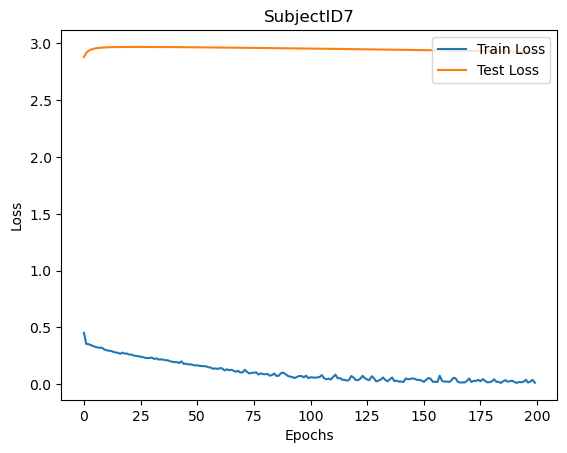

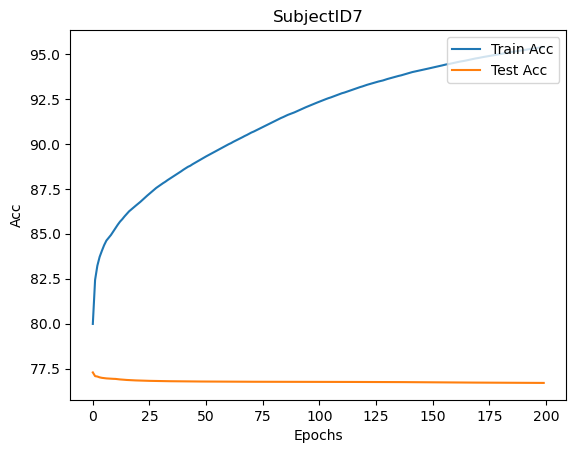


Subject 8
| epoch   0 | 0.2771 s/epoch | train loss 0.5181
| epoch   1 | 0.2752 s/epoch | train loss 0.3765
| epoch   2 | 0.2760 s/epoch | train loss 0.3427
| epoch   3 | 0.2756 s/epoch | train loss 0.3385
| epoch   4 | 0.2748 s/epoch | train loss 0.3302
| epoch   5 | 0.2763 s/epoch | train loss 0.3172
| epoch   6 | 0.2769 s/epoch | train loss 0.2864
| epoch   7 | 0.2734 s/epoch | train loss 0.2728
| epoch   8 | 0.2765 s/epoch | train loss 0.2618
| epoch   9 | 0.2762 s/epoch | train loss 0.2529
| epoch  10 | 0.2757 s/epoch | train loss 0.2464
| epoch  11 | 0.2752 s/epoch | train loss 0.2516
| epoch  12 | 0.2748 s/epoch | train loss 0.2333
| epoch  13 | 0.2758 s/epoch | train loss 0.2334
| epoch  14 | 0.2733 s/epoch | train loss 0.2483
| epoch  15 | 0.2732 s/epoch | train loss 0.2225
| epoch  16 | 0.2757 s/epoch | train loss 0.3431
| epoch  17 | 0.2715 s/epoch | train loss 0.3312
| epoch  18 | 0.2735 s/epoch | train loss 0.2870
| epoch  19 | 0.2736 s/epoch | train loss 0.2650
| epoch  

| epoch 167 | 0.2779 s/epoch | train loss 0.0555
| epoch 168 | 0.2754 s/epoch | train loss 0.0487
| epoch 169 | 0.2760 s/epoch | train loss 0.0553
| epoch 170 | 0.2769 s/epoch | train loss 0.0635
| epoch 171 | 0.2786 s/epoch | train loss 0.0516
| epoch 172 | 0.2754 s/epoch | train loss 0.0498
| epoch 173 | 0.2777 s/epoch | train loss 0.0538
| epoch 174 | 0.2779 s/epoch | train loss 0.0464
| epoch 175 | 0.2763 s/epoch | train loss 0.0462
| epoch 176 | 0.2776 s/epoch | train loss 0.0637
| epoch 177 | 0.2766 s/epoch | train loss 0.0480
| epoch 178 | 0.2779 s/epoch | train loss 0.0456
| epoch 179 | 0.2769 s/epoch | train loss 0.0583
| epoch 180 | 0.2775 s/epoch | train loss 0.0485
| epoch 181 | 0.2777 s/epoch | train loss 0.0362
| epoch 182 | 0.2761 s/epoch | train loss 0.0473
| epoch 183 | 0.2781 s/epoch | train loss 0.0475
| epoch 184 | 0.2773 s/epoch | train loss 0.0365
| epoch 185 | 0.2764 s/epoch | train loss 0.0456
| epoch 186 | 0.2781 s/epoch | train loss 0.0474
| epoch 187 | 0.2757

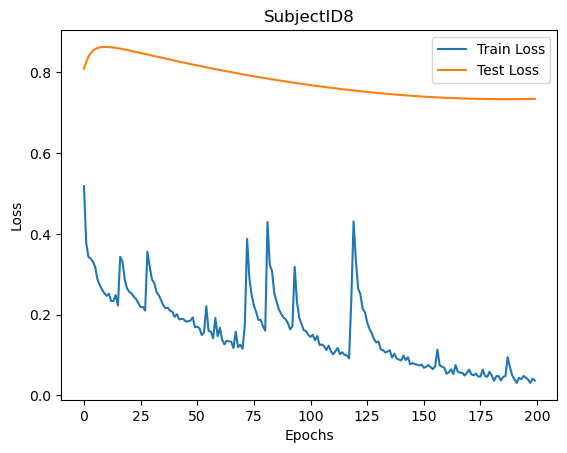

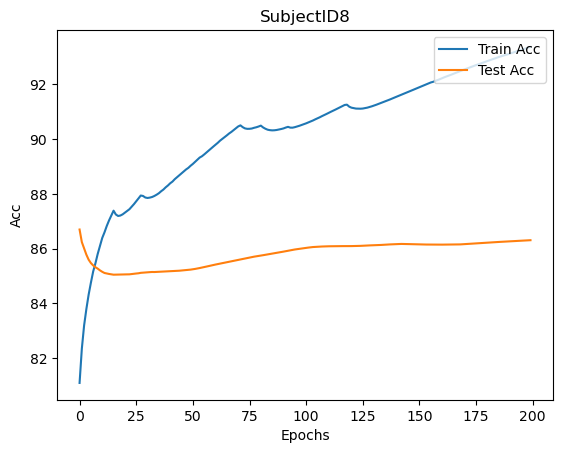

| epoch   0 | 0.0087 s/epoch | train loss 0.4785
| epoch   1 | 0.0096 s/epoch | train loss 0.3942
| epoch   2 | 0.0092 s/epoch | train loss 0.3800
| epoch   3 | 0.0090 s/epoch | train loss 0.3763
| epoch   4 | 0.0089 s/epoch | train loss 0.3663
| epoch   5 | 0.0095 s/epoch | train loss 0.3585
| epoch   6 | 0.0091 s/epoch | train loss 0.3518
| epoch   7 | 0.0084 s/epoch | train loss 0.3485
| epoch   8 | 0.0097 s/epoch | train loss 0.3396
| epoch   9 | 0.0098 s/epoch | train loss 0.3323
| epoch  10 | 0.0103 s/epoch | train loss 0.3302
| epoch  11 | 0.0091 s/epoch | train loss 0.3288
| epoch  12 | 0.0092 s/epoch | train loss 0.3145
| epoch  13 | 0.0098 s/epoch | train loss 0.3145
| epoch  14 | 0.0092 s/epoch | train loss 0.3115
| epoch  15 | 0.0094 s/epoch | train loss 0.3067
| epoch  16 | 0.0094 s/epoch | train loss 0.3032
| epoch  17 | 0.0095 s/epoch | train loss 0.2961
| epoch  18 | 0.0109 s/epoch | train loss 0.2973
| epoch  19 | 0.0102 s/epoch | train loss 0.2903
| epoch  20 | 0.0092

| epoch 168 | 0.0091 s/epoch | train loss 0.0386
| epoch 169 | 0.0096 s/epoch | train loss 0.0601
| epoch 170 | 0.0096 s/epoch | train loss 0.0519
| epoch 171 | 0.0097 s/epoch | train loss 0.0224
| epoch 172 | 0.0093 s/epoch | train loss 0.0370
| epoch 173 | 0.0104 s/epoch | train loss 0.0224
| epoch 174 | 0.0092 s/epoch | train loss 0.0433
| epoch 175 | 0.0096 s/epoch | train loss 0.0451
| epoch 176 | 0.0095 s/epoch | train loss 0.0574
| epoch 177 | 0.0097 s/epoch | train loss 0.0174
| epoch 178 | 0.0097 s/epoch | train loss 0.0139
| epoch 179 | 0.0092 s/epoch | train loss 0.0167
| epoch 180 | 0.0095 s/epoch | train loss 0.0230
| epoch 181 | 0.0092 s/epoch | train loss 0.0266
| epoch 182 | 0.0098 s/epoch | train loss 0.0380
| epoch 183 | 0.0100 s/epoch | train loss 0.0478
| epoch 184 | 0.0097 s/epoch | train loss 0.0383
| epoch 185 | 0.0089 s/epoch | train loss 0.0286
| epoch 186 | 0.0096 s/epoch | train loss 0.0151
| epoch 187 | 0.0097 s/epoch | train loss 0.0154
| epoch 188 | 0.0106

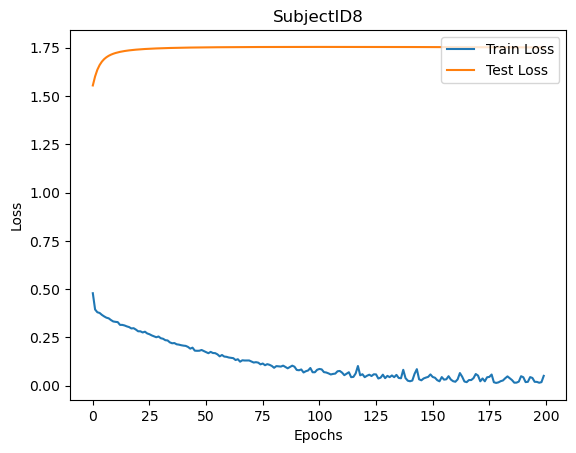

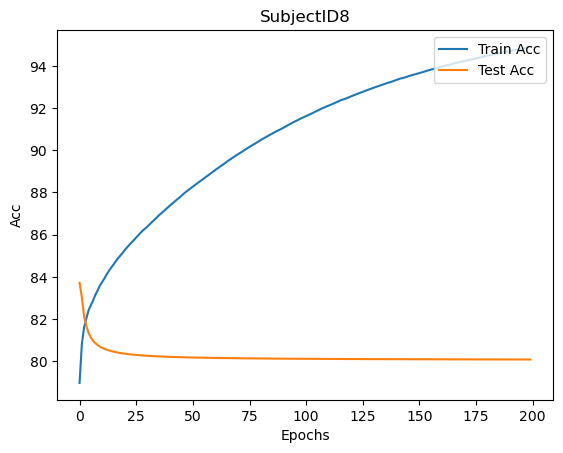


Subject 9
| epoch   0 | 0.2727 s/epoch | train loss 0.4995
| epoch   1 | 0.2715 s/epoch | train loss 0.3547
| epoch   2 | 0.2710 s/epoch | train loss 0.3349
| epoch   3 | 0.2717 s/epoch | train loss 0.3211
| epoch   4 | 0.2717 s/epoch | train loss 0.3023
| epoch   5 | 0.2714 s/epoch | train loss 0.2770
| epoch   6 | 0.2718 s/epoch | train loss 0.2817
| epoch   7 | 0.2707 s/epoch | train loss 0.2662
| epoch   8 | 0.2716 s/epoch | train loss 0.2907
| epoch   9 | 0.2692 s/epoch | train loss 0.3569
| epoch  10 | 0.2708 s/epoch | train loss 0.3300
| epoch  11 | 0.2731 s/epoch | train loss 0.3034
| epoch  12 | 0.2729 s/epoch | train loss 0.2832
| epoch  13 | 0.2728 s/epoch | train loss 0.2846
| epoch  14 | 0.2720 s/epoch | train loss 0.2676
| epoch  15 | 0.2754 s/epoch | train loss 0.2650
| epoch  16 | 0.2724 s/epoch | train loss 0.3459
| epoch  17 | 0.2745 s/epoch | train loss 0.2740
| epoch  18 | 0.2749 s/epoch | train loss 0.2615
| epoch  19 | 0.2712 s/epoch | train loss 0.2549
| epoch  

| epoch 167 | 0.2714 s/epoch | train loss 0.0408
| epoch 168 | 0.2720 s/epoch | train loss 0.0404
| epoch 169 | 0.2712 s/epoch | train loss 0.0397
| epoch 170 | 0.2722 s/epoch | train loss 0.0433
| epoch 171 | 0.2715 s/epoch | train loss 0.0439
| epoch 172 | 0.2716 s/epoch | train loss 0.0478
| epoch 173 | 0.2724 s/epoch | train loss 0.1742
| epoch 174 | 0.2741 s/epoch | train loss 0.0967
| epoch 175 | 0.2730 s/epoch | train loss 0.0606
| epoch 176 | 0.2717 s/epoch | train loss 0.0583
| epoch 177 | 0.2703 s/epoch | train loss 0.0494
| epoch 178 | 0.2723 s/epoch | train loss 0.0424
| epoch 179 | 0.2729 s/epoch | train loss 0.0395
| epoch 180 | 0.2737 s/epoch | train loss 0.0305
| epoch 181 | 0.2729 s/epoch | train loss 0.0551
| epoch 182 | 0.2740 s/epoch | train loss 0.0361
| epoch 183 | 0.2726 s/epoch | train loss 0.0297
| epoch 184 | 0.2725 s/epoch | train loss 0.0351
| epoch 185 | 0.2719 s/epoch | train loss 0.0403
| epoch 186 | 0.2727 s/epoch | train loss 0.0350
| epoch 187 | 0.2724

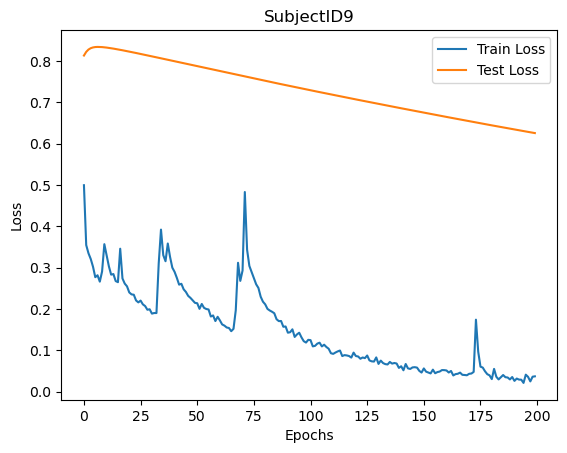

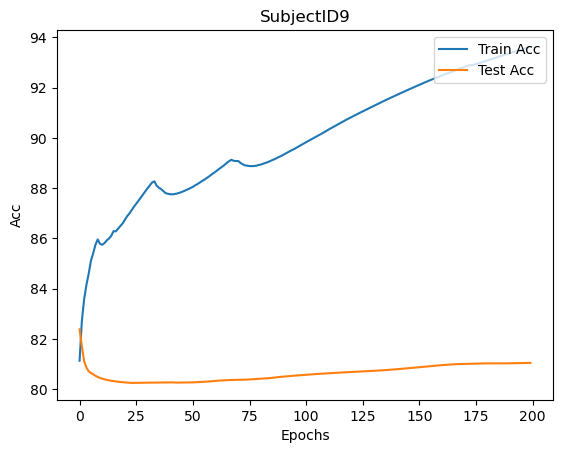

| epoch   0 | 0.0086 s/epoch | train loss 0.4589
| epoch   1 | 0.0093 s/epoch | train loss 0.3808
| epoch   2 | 0.0089 s/epoch | train loss 0.3655
| epoch   3 | 0.0088 s/epoch | train loss 0.3574
| epoch   4 | 0.0098 s/epoch | train loss 0.3523
| epoch   5 | 0.0095 s/epoch | train loss 0.3431
| epoch   6 | 0.0097 s/epoch | train loss 0.3410
| epoch   7 | 0.0091 s/epoch | train loss 0.3327
| epoch   8 | 0.0092 s/epoch | train loss 0.3284
| epoch   9 | 0.0090 s/epoch | train loss 0.3210
| epoch  10 | 0.0091 s/epoch | train loss 0.3220
| epoch  11 | 0.0090 s/epoch | train loss 0.3182
| epoch  12 | 0.0089 s/epoch | train loss 0.3158
| epoch  13 | 0.0101 s/epoch | train loss 0.3113
| epoch  14 | 0.0088 s/epoch | train loss 0.3070
| epoch  15 | 0.0093 s/epoch | train loss 0.3038
| epoch  16 | 0.0099 s/epoch | train loss 0.3017
| epoch  17 | 0.0087 s/epoch | train loss 0.2959
| epoch  18 | 0.0090 s/epoch | train loss 0.2892
| epoch  19 | 0.0095 s/epoch | train loss 0.2910
| epoch  20 | 0.0096

| epoch 168 | 0.0103 s/epoch | train loss 0.0328
| epoch 169 | 0.0088 s/epoch | train loss 0.0228
| epoch 170 | 0.0096 s/epoch | train loss 0.0287
| epoch 171 | 0.0093 s/epoch | train loss 0.0443
| epoch 172 | 0.0090 s/epoch | train loss 0.0516
| epoch 173 | 0.0101 s/epoch | train loss 0.0232
| epoch 174 | 0.0090 s/epoch | train loss 0.0157
| epoch 175 | 0.0105 s/epoch | train loss 0.0298
| epoch 176 | 0.0093 s/epoch | train loss 0.0635
| epoch 177 | 0.0101 s/epoch | train loss 0.0265
| epoch 178 | 0.0099 s/epoch | train loss 0.0191
| epoch 179 | 0.0099 s/epoch | train loss 0.0198
| epoch 180 | 0.0095 s/epoch | train loss 0.0283
| epoch 181 | 0.0092 s/epoch | train loss 0.0592
| epoch 182 | 0.0087 s/epoch | train loss 0.0506
| epoch 183 | 0.0091 s/epoch | train loss 0.0167
| epoch 184 | 0.0092 s/epoch | train loss 0.0201
| epoch 185 | 0.0089 s/epoch | train loss 0.0261
| epoch 186 | 0.0091 s/epoch | train loss 0.0415
| epoch 187 | 0.0092 s/epoch | train loss 0.0285
| epoch 188 | 0.0093

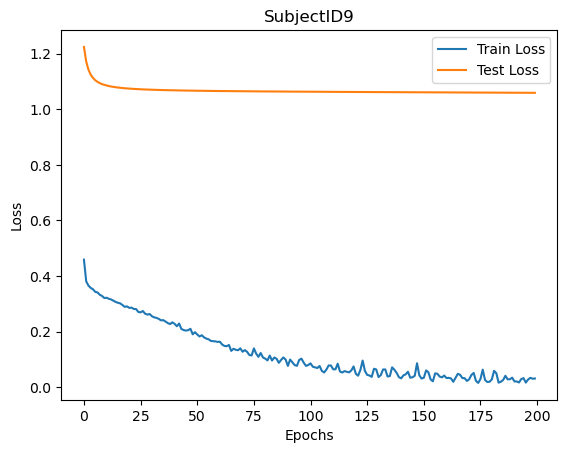

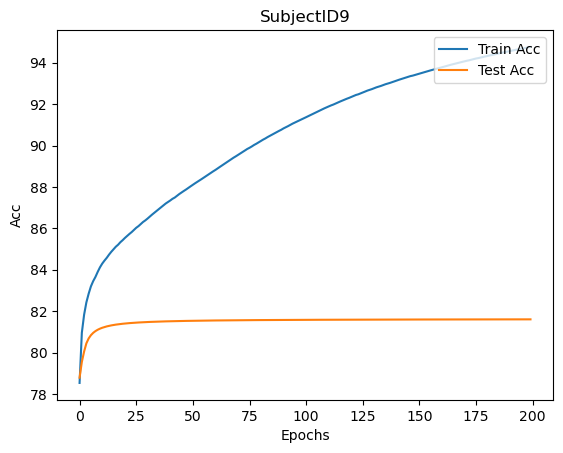


Subject 10
| epoch   0 | 0.2811 s/epoch | train loss 0.5205
| epoch   1 | 0.2812 s/epoch | train loss 0.4023
| epoch   2 | 0.2826 s/epoch | train loss 0.3611
| epoch   3 | 0.2803 s/epoch | train loss 0.3396
| epoch   4 | 0.2817 s/epoch | train loss 0.3201
| epoch   5 | 0.2793 s/epoch | train loss 0.3182
| epoch   6 | 0.2823 s/epoch | train loss 0.3021
| epoch   7 | 0.2819 s/epoch | train loss 0.2997
| epoch   8 | 0.2817 s/epoch | train loss 0.2807
| epoch   9 | 0.2819 s/epoch | train loss 0.2771
| epoch  10 | 0.2810 s/epoch | train loss 0.5800
| epoch  11 | 0.2822 s/epoch | train loss 0.4984
| epoch  12 | 0.2825 s/epoch | train loss 0.6067
| epoch  13 | 0.2810 s/epoch | train loss 0.4436
| epoch  14 | 0.2820 s/epoch | train loss 0.3990
| epoch  15 | 0.2837 s/epoch | train loss 0.4322
| epoch  16 | 0.2841 s/epoch | train loss 0.4226
| epoch  17 | 0.2814 s/epoch | train loss 0.4702
| epoch  18 | 0.2808 s/epoch | train loss 0.3805
| epoch  19 | 0.2799 s/epoch | train loss 0.3954
| epoch 

| epoch 167 | 0.2826 s/epoch | train loss 0.0473
| epoch 168 | 0.2820 s/epoch | train loss 0.0368
| epoch 169 | 0.2822 s/epoch | train loss 0.0357
| epoch 170 | 0.2834 s/epoch | train loss 0.0402
| epoch 171 | 0.2826 s/epoch | train loss 0.0368
| epoch 172 | 0.2827 s/epoch | train loss 0.0407
| epoch 173 | 0.2833 s/epoch | train loss 0.0422
| epoch 174 | 0.2818 s/epoch | train loss 0.0327
| epoch 175 | 0.2829 s/epoch | train loss 0.0408
| epoch 176 | 0.2821 s/epoch | train loss 0.0383
| epoch 177 | 0.2818 s/epoch | train loss 0.0322
| epoch 178 | 0.2835 s/epoch | train loss 0.0512
| epoch 179 | 0.2852 s/epoch | train loss 0.0541
| epoch 180 | 0.2850 s/epoch | train loss 0.0374
| epoch 181 | 0.2850 s/epoch | train loss 0.0330
| epoch 182 | 0.2843 s/epoch | train loss 0.0419
| epoch 183 | 0.2807 s/epoch | train loss 0.0556
| epoch 184 | 0.2829 s/epoch | train loss 0.0423
| epoch 185 | 0.2820 s/epoch | train loss 0.0395
| epoch 186 | 0.2835 s/epoch | train loss 0.0403
| epoch 187 | 0.2829

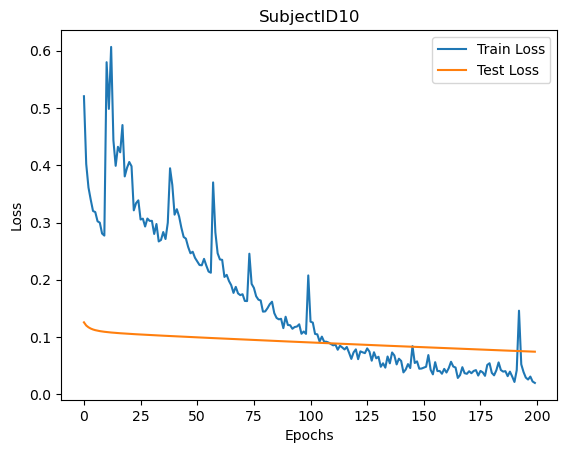

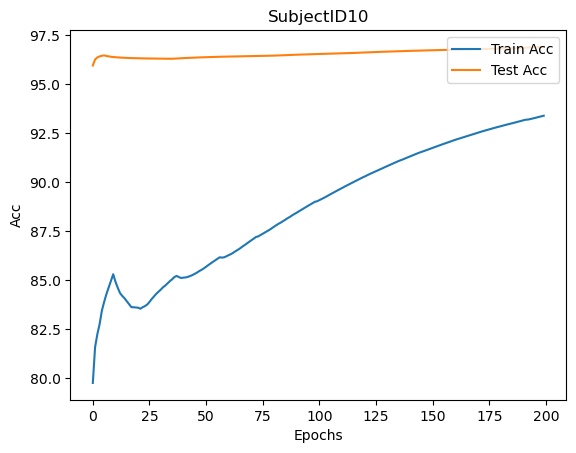

| epoch   0 | 0.0092 s/epoch | train loss 0.4726
| epoch   1 | 0.0097 s/epoch | train loss 0.3922
| epoch   2 | 0.0088 s/epoch | train loss 0.3782
| epoch   3 | 0.0107 s/epoch | train loss 0.3718
| epoch   4 | 0.0091 s/epoch | train loss 0.3649
| epoch   5 | 0.0093 s/epoch | train loss 0.3551
| epoch   6 | 0.0096 s/epoch | train loss 0.3512
| epoch   7 | 0.0100 s/epoch | train loss 0.3411
| epoch   8 | 0.0091 s/epoch | train loss 0.3417
| epoch   9 | 0.0095 s/epoch | train loss 0.3337
| epoch  10 | 0.0104 s/epoch | train loss 0.3321
| epoch  11 | 0.0095 s/epoch | train loss 0.3247
| epoch  12 | 0.0091 s/epoch | train loss 0.3274
| epoch  13 | 0.0094 s/epoch | train loss 0.3295
| epoch  14 | 0.0091 s/epoch | train loss 0.3233
| epoch  15 | 0.0107 s/epoch | train loss 0.3134
| epoch  16 | 0.0098 s/epoch | train loss 0.3127
| epoch  17 | 0.0101 s/epoch | train loss 0.3072
| epoch  18 | 0.0098 s/epoch | train loss 0.2976
| epoch  19 | 0.0091 s/epoch | train loss 0.2971
| epoch  20 | 0.0104

| epoch 168 | 0.0104 s/epoch | train loss 0.0488
| epoch 169 | 0.0095 s/epoch | train loss 0.0395
| epoch 170 | 0.0107 s/epoch | train loss 0.0186
| epoch 171 | 0.0099 s/epoch | train loss 0.0369
| epoch 172 | 0.0095 s/epoch | train loss 0.0241
| epoch 173 | 0.0098 s/epoch | train loss 0.0326
| epoch 174 | 0.0099 s/epoch | train loss 0.0182
| epoch 175 | 0.0098 s/epoch | train loss 0.0337
| epoch 176 | 0.0094 s/epoch | train loss 0.0661
| epoch 177 | 0.0102 s/epoch | train loss 0.0264
| epoch 178 | 0.0092 s/epoch | train loss 0.0172
| epoch 179 | 0.0101 s/epoch | train loss 0.0246
| epoch 180 | 0.0094 s/epoch | train loss 0.0169
| epoch 181 | 0.0093 s/epoch | train loss 0.0523
| epoch 182 | 0.0092 s/epoch | train loss 0.0377
| epoch 183 | 0.0096 s/epoch | train loss 0.0171
| epoch 184 | 0.0103 s/epoch | train loss 0.0196
| epoch 185 | 0.0096 s/epoch | train loss 0.0395
| epoch 186 | 0.0093 s/epoch | train loss 0.0324
| epoch 187 | 0.0095 s/epoch | train loss 0.0148
| epoch 188 | 0.0094

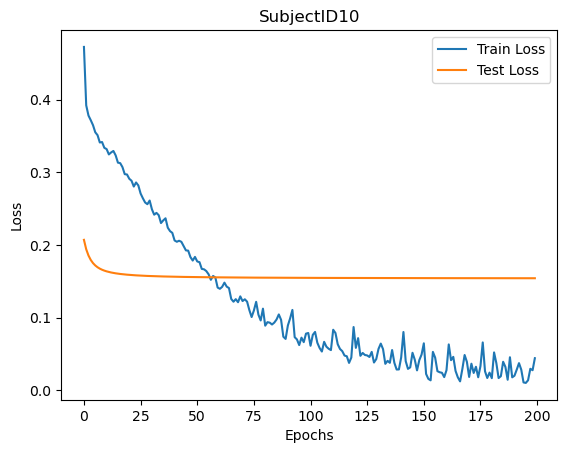

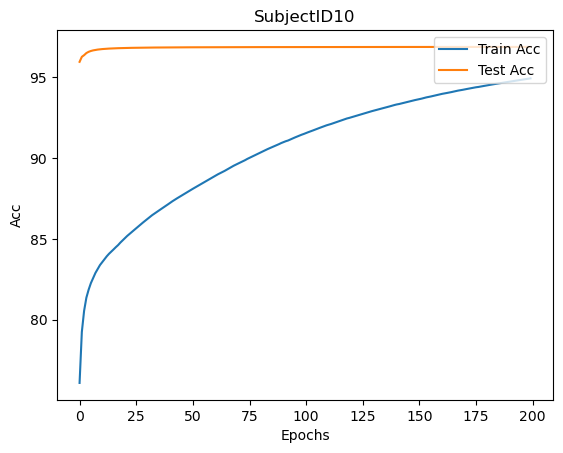


Subject 11
| epoch   0 | 0.2810 s/epoch | train loss 0.5548
| epoch   1 | 0.2774 s/epoch | train loss 0.4865
| epoch   2 | 0.2804 s/epoch | train loss 0.3742
| epoch   3 | 0.2795 s/epoch | train loss 0.4000
| epoch   4 | 0.2778 s/epoch | train loss 0.3369
| epoch   5 | 0.2776 s/epoch | train loss 0.3328
| epoch   6 | 0.2792 s/epoch | train loss 0.3135
| epoch   7 | 0.2800 s/epoch | train loss 0.2875
| epoch   8 | 0.2776 s/epoch | train loss 0.2914
| epoch   9 | 0.2806 s/epoch | train loss 0.2770
| epoch  10 | 0.2799 s/epoch | train loss 0.2673
| epoch  11 | 0.2801 s/epoch | train loss 0.2565
| epoch  12 | 0.2789 s/epoch | train loss 0.3736
| epoch  13 | 0.2778 s/epoch | train loss 0.3460
| epoch  14 | 0.2760 s/epoch | train loss 0.3118
| epoch  15 | 0.2795 s/epoch | train loss 0.2954
| epoch  16 | 0.2788 s/epoch | train loss 0.2845
| epoch  17 | 0.2808 s/epoch | train loss 0.2781
| epoch  18 | 0.2791 s/epoch | train loss 0.2734
| epoch  19 | 0.2801 s/epoch | train loss 0.2916
| epoch 

| epoch 167 | 0.2804 s/epoch | train loss 0.1713
| epoch 168 | 0.2780 s/epoch | train loss 0.1826
| epoch 169 | 0.2790 s/epoch | train loss 0.1782
| epoch 170 | 0.2782 s/epoch | train loss 0.1626
| epoch 171 | 0.2804 s/epoch | train loss 0.1570
| epoch 172 | 0.2782 s/epoch | train loss 0.1509
| epoch 173 | 0.2784 s/epoch | train loss 0.1586
| epoch 174 | 0.2780 s/epoch | train loss 0.1530
| epoch 175 | 0.2798 s/epoch | train loss 0.1396
| epoch 176 | 0.2789 s/epoch | train loss 0.1506
| epoch 177 | 0.2786 s/epoch | train loss 0.1771
| epoch 178 | 0.2779 s/epoch | train loss 0.1534
| epoch 179 | 0.2787 s/epoch | train loss 0.1339
| epoch 180 | 0.2786 s/epoch | train loss 0.1390
| epoch 181 | 0.2776 s/epoch | train loss 0.1232
| epoch 182 | 0.2800 s/epoch | train loss 0.2365
| epoch 183 | 0.2789 s/epoch | train loss 0.1689
| epoch 184 | 0.2805 s/epoch | train loss 0.1492
| epoch 185 | 0.2797 s/epoch | train loss 0.1524
| epoch 186 | 0.2788 s/epoch | train loss 0.1335
| epoch 187 | 0.2794

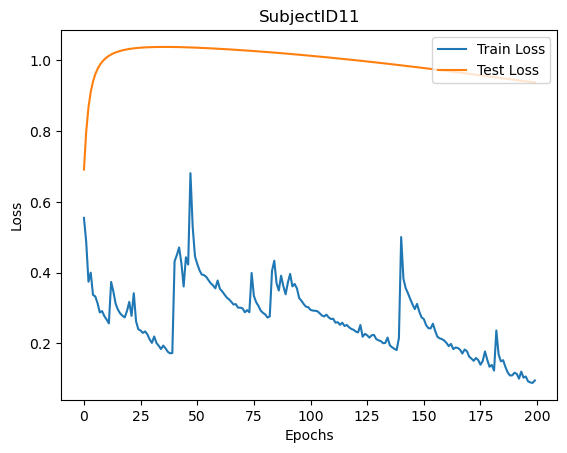

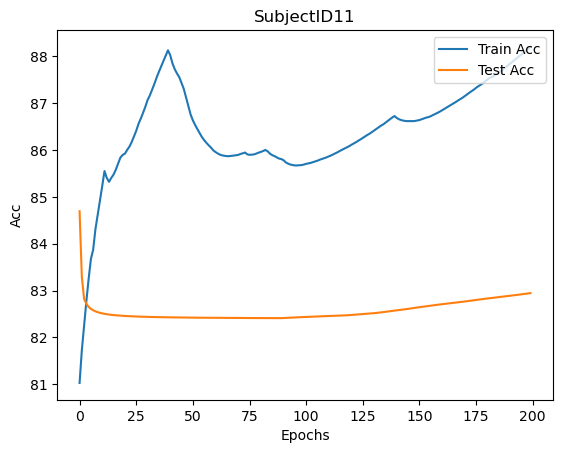

| epoch   0 | 0.0105 s/epoch | train loss 0.4741
| epoch   1 | 0.0097 s/epoch | train loss 0.3885
| epoch   2 | 0.0097 s/epoch | train loss 0.3744
| epoch   3 | 0.0098 s/epoch | train loss 0.3669
| epoch   4 | 0.0092 s/epoch | train loss 0.3651
| epoch   5 | 0.0092 s/epoch | train loss 0.3546
| epoch   6 | 0.0096 s/epoch | train loss 0.3498
| epoch   7 | 0.0092 s/epoch | train loss 0.3406
| epoch   8 | 0.0094 s/epoch | train loss 0.3385
| epoch   9 | 0.0094 s/epoch | train loss 0.3285
| epoch  10 | 0.0093 s/epoch | train loss 0.3255
| epoch  11 | 0.0100 s/epoch | train loss 0.3136
| epoch  12 | 0.0100 s/epoch | train loss 0.3197
| epoch  13 | 0.0096 s/epoch | train loss 0.3120
| epoch  14 | 0.0097 s/epoch | train loss 0.3084
| epoch  15 | 0.0092 s/epoch | train loss 0.3010
| epoch  16 | 0.0091 s/epoch | train loss 0.2971
| epoch  17 | 0.0108 s/epoch | train loss 0.2860
| epoch  18 | 0.0087 s/epoch | train loss 0.2823
| epoch  19 | 0.0099 s/epoch | train loss 0.2870
| epoch  20 | 0.0097

| epoch 168 | 0.0102 s/epoch | train loss 0.0309
| epoch 169 | 0.0090 s/epoch | train loss 0.0294
| epoch 170 | 0.0095 s/epoch | train loss 0.0271
| epoch 171 | 0.0098 s/epoch | train loss 0.0332
| epoch 172 | 0.0098 s/epoch | train loss 0.0506
| epoch 173 | 0.0095 s/epoch | train loss 0.0181
| epoch 174 | 0.0103 s/epoch | train loss 0.0245
| epoch 175 | 0.0094 s/epoch | train loss 0.0361
| epoch 176 | 0.0099 s/epoch | train loss 0.0336
| epoch 177 | 0.0104 s/epoch | train loss 0.0185
| epoch 178 | 0.0096 s/epoch | train loss 0.0472
| epoch 179 | 0.0097 s/epoch | train loss 0.0472
| epoch 180 | 0.0089 s/epoch | train loss 0.0162
| epoch 181 | 0.0099 s/epoch | train loss 0.0186
| epoch 182 | 0.0098 s/epoch | train loss 0.0404
| epoch 183 | 0.0088 s/epoch | train loss 0.0357
| epoch 184 | 0.0093 s/epoch | train loss 0.0158
| epoch 185 | 0.0094 s/epoch | train loss 0.0188
| epoch 186 | 0.0098 s/epoch | train loss 0.0279
| epoch 187 | 0.0099 s/epoch | train loss 0.0246
| epoch 188 | 0.0104

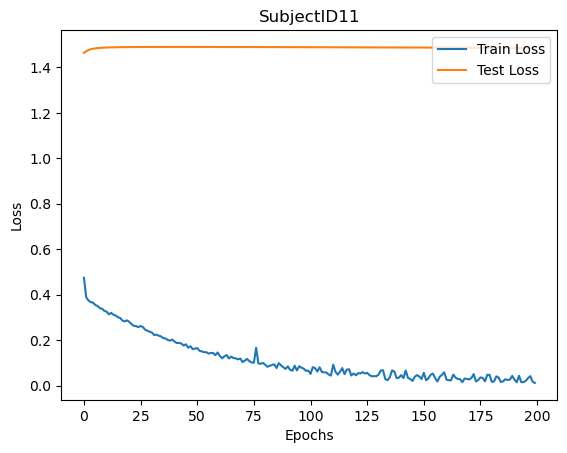

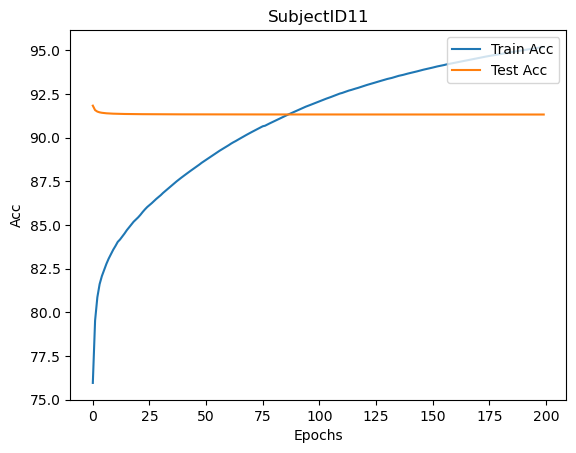


Subject 12
| epoch   0 | 0.2658 s/epoch | train loss 0.4924
| epoch   1 | 0.2649 s/epoch | train loss 0.3473
| epoch   2 | 0.2629 s/epoch | train loss 0.3155
| epoch   3 | 0.2667 s/epoch | train loss 0.2973
| epoch   4 | 0.2643 s/epoch | train loss 0.2810
| epoch   5 | 0.2657 s/epoch | train loss 0.2752
| epoch   6 | 0.2649 s/epoch | train loss 0.2749
| epoch   7 | 0.2657 s/epoch | train loss 0.3901
| epoch   8 | 0.2649 s/epoch | train loss 0.3485
| epoch   9 | 0.2645 s/epoch | train loss 0.3134
| epoch  10 | 0.2647 s/epoch | train loss 0.2929
| epoch  11 | 0.2641 s/epoch | train loss 0.2944
| epoch  12 | 0.2654 s/epoch | train loss 0.2904
| epoch  13 | 0.2632 s/epoch | train loss 0.2772
| epoch  14 | 0.2648 s/epoch | train loss 0.2894
| epoch  15 | 0.2668 s/epoch | train loss 0.3017
| epoch  16 | 0.2646 s/epoch | train loss 0.2725
| epoch  17 | 0.2654 s/epoch | train loss 0.2490
| epoch  18 | 0.2666 s/epoch | train loss 0.2425
| epoch  19 | 0.2676 s/epoch | train loss 0.3218
| epoch 

| epoch 167 | 0.2623 s/epoch | train loss 0.2210
| epoch 168 | 0.2662 s/epoch | train loss 0.2198
| epoch 169 | 0.2667 s/epoch | train loss 0.2036
| epoch 170 | 0.2644 s/epoch | train loss 0.2033
| epoch 171 | 0.2647 s/epoch | train loss 0.2026
| epoch 172 | 0.2649 s/epoch | train loss 0.2049
| epoch 173 | 0.2659 s/epoch | train loss 0.1840
| epoch 174 | 0.2660 s/epoch | train loss 0.1894
| epoch 175 | 0.2645 s/epoch | train loss 0.1883
| epoch 176 | 0.2659 s/epoch | train loss 0.1844
| epoch 177 | 0.2644 s/epoch | train loss 0.1730
| epoch 178 | 0.2655 s/epoch | train loss 0.1699
| epoch 179 | 0.2647 s/epoch | train loss 0.1650
| epoch 180 | 0.2659 s/epoch | train loss 0.1725
| epoch 181 | 0.2662 s/epoch | train loss 0.1626
| epoch 182 | 0.2654 s/epoch | train loss 0.1651
| epoch 183 | 0.2639 s/epoch | train loss 0.1522
| epoch 184 | 0.2677 s/epoch | train loss 0.1529
| epoch 185 | 0.2677 s/epoch | train loss 0.2079
| epoch 186 | 0.2653 s/epoch | train loss 0.1557
| epoch 187 | 0.2652

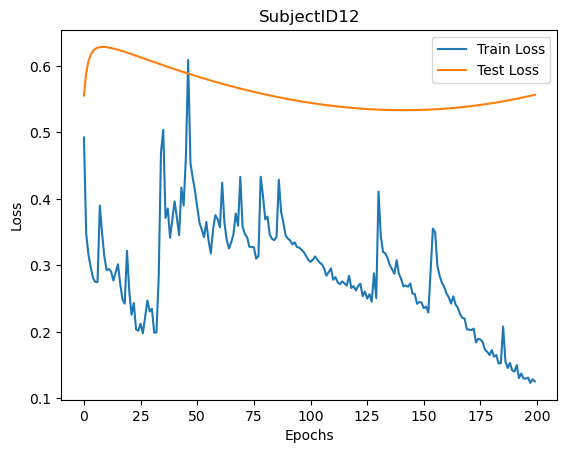

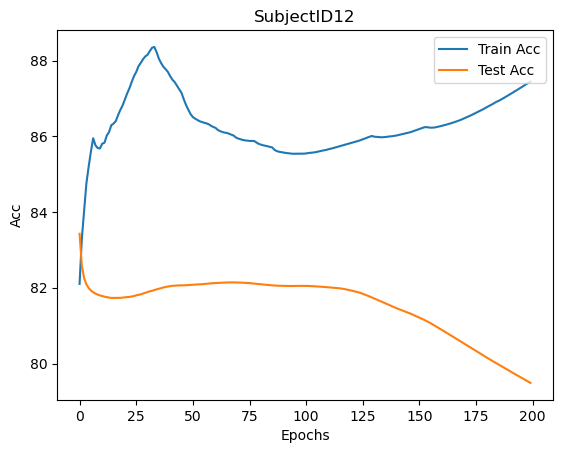

| epoch   0 | 0.0085 s/epoch | train loss 0.4510
| epoch   1 | 0.0088 s/epoch | train loss 0.3695
| epoch   2 | 0.0091 s/epoch | train loss 0.3634
| epoch   3 | 0.0091 s/epoch | train loss 0.3556
| epoch   4 | 0.0086 s/epoch | train loss 0.3461
| epoch   5 | 0.0093 s/epoch | train loss 0.3442
| epoch   6 | 0.0095 s/epoch | train loss 0.3353
| epoch   7 | 0.0101 s/epoch | train loss 0.3297
| epoch   8 | 0.0088 s/epoch | train loss 0.3261
| epoch   9 | 0.0097 s/epoch | train loss 0.3207
| epoch  10 | 0.0089 s/epoch | train loss 0.3215
| epoch  11 | 0.0089 s/epoch | train loss 0.3169
| epoch  12 | 0.0090 s/epoch | train loss 0.3110
| epoch  13 | 0.0087 s/epoch | train loss 0.3115
| epoch  14 | 0.0094 s/epoch | train loss 0.3062
| epoch  15 | 0.0088 s/epoch | train loss 0.3019
| epoch  16 | 0.0097 s/epoch | train loss 0.2984
| epoch  17 | 0.0089 s/epoch | train loss 0.2958
| epoch  18 | 0.0088 s/epoch | train loss 0.2941
| epoch  19 | 0.0093 s/epoch | train loss 0.2942
| epoch  20 | 0.0091

| epoch 168 | 0.0091 s/epoch | train loss 0.0174
| epoch 169 | 0.0092 s/epoch | train loss 0.0265
| epoch 170 | 0.0088 s/epoch | train loss 0.0731
| epoch 171 | 0.0083 s/epoch | train loss 0.0540
| epoch 172 | 0.0092 s/epoch | train loss 0.0210
| epoch 173 | 0.0090 s/epoch | train loss 0.0301
| epoch 174 | 0.0092 s/epoch | train loss 0.0546
| epoch 175 | 0.0094 s/epoch | train loss 0.0377
| epoch 176 | 0.0093 s/epoch | train loss 0.0298
| epoch 177 | 0.0090 s/epoch | train loss 0.0268
| epoch 178 | 0.0094 s/epoch | train loss 0.0154
| epoch 179 | 0.0092 s/epoch | train loss 0.0194
| epoch 180 | 0.0091 s/epoch | train loss 0.0199
| epoch 181 | 0.0097 s/epoch | train loss 0.0638
| epoch 182 | 0.0096 s/epoch | train loss 0.0318
| epoch 183 | 0.0083 s/epoch | train loss 0.0184
| epoch 184 | 0.0101 s/epoch | train loss 0.0118
| epoch 185 | 0.0088 s/epoch | train loss 0.0188
| epoch 186 | 0.0095 s/epoch | train loss 0.0251
| epoch 187 | 0.0099 s/epoch | train loss 0.0744
| epoch 188 | 0.0088

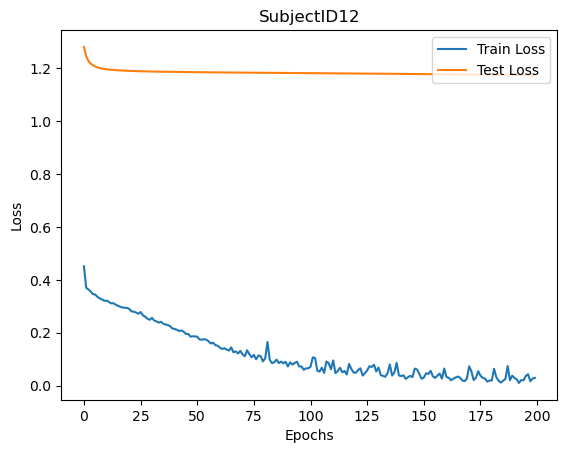

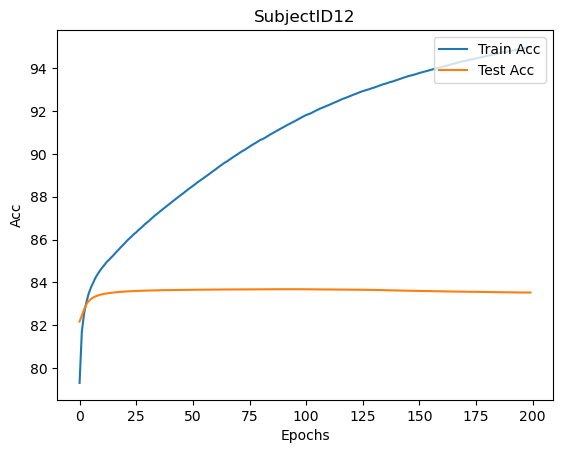


Subject 13
| epoch   0 | 0.2698 s/epoch | train loss 0.4714
| epoch   1 | 0.2657 s/epoch | train loss 0.4273
| epoch   2 | 0.2653 s/epoch | train loss 0.4344
| epoch   3 | 0.2674 s/epoch | train loss 0.3498
| epoch   4 | 0.2651 s/epoch | train loss 0.3101
| epoch   5 | 0.2660 s/epoch | train loss 0.2830
| epoch   6 | 0.2654 s/epoch | train loss 0.2807
| epoch   7 | 0.2650 s/epoch | train loss 0.2829
| epoch   8 | 0.2656 s/epoch | train loss 0.2629
| epoch   9 | 0.2653 s/epoch | train loss 0.2669
| epoch  10 | 0.2653 s/epoch | train loss 0.2448
| epoch  11 | 0.2653 s/epoch | train loss 0.3105
| epoch  12 | 0.2669 s/epoch | train loss 0.2733
| epoch  13 | 0.2667 s/epoch | train loss 0.2697
| epoch  14 | 0.2648 s/epoch | train loss 0.2542
| epoch  15 | 0.2648 s/epoch | train loss 0.2823
| epoch  16 | 0.2659 s/epoch | train loss 0.2650
| epoch  17 | 0.2641 s/epoch | train loss 0.2546
| epoch  18 | 0.2654 s/epoch | train loss 0.2314
| epoch  19 | 0.2660 s/epoch | train loss 0.2319
| epoch 

| epoch 167 | 0.2661 s/epoch | train loss 0.1358
| epoch 168 | 0.2652 s/epoch | train loss 0.0793
| epoch 169 | 0.2661 s/epoch | train loss 0.0738
| epoch 170 | 0.2665 s/epoch | train loss 0.0732
| epoch 171 | 0.2663 s/epoch | train loss 0.0672
| epoch 172 | 0.2657 s/epoch | train loss 0.0636
| epoch 173 | 0.2659 s/epoch | train loss 0.0534
| epoch 174 | 0.2656 s/epoch | train loss 0.0874
| epoch 175 | 0.2667 s/epoch | train loss 0.0757
| epoch 176 | 0.2652 s/epoch | train loss 0.0629
| epoch 177 | 0.2657 s/epoch | train loss 0.0623
| epoch 178 | 0.2649 s/epoch | train loss 0.0716
| epoch 179 | 0.2682 s/epoch | train loss 0.0565
| epoch 180 | 0.2669 s/epoch | train loss 0.0592
| epoch 181 | 0.2662 s/epoch | train loss 0.0617
| epoch 182 | 0.2664 s/epoch | train loss 0.0537
| epoch 183 | 0.2656 s/epoch | train loss 0.0488
| epoch 184 | 0.2682 s/epoch | train loss 0.0558
| epoch 185 | 0.2644 s/epoch | train loss 0.0518
| epoch 186 | 0.2656 s/epoch | train loss 0.0539
| epoch 187 | 0.2666

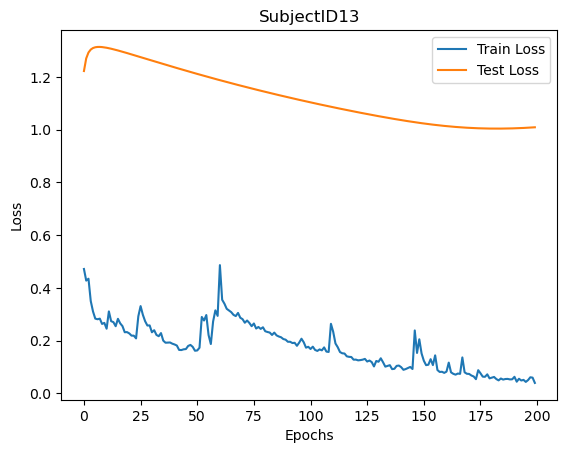

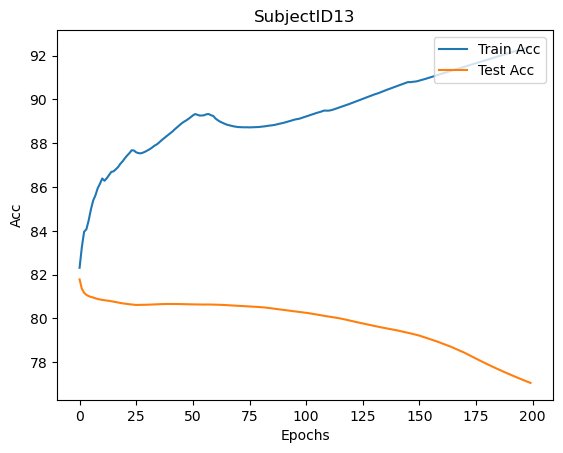

| epoch   0 | 0.0090 s/epoch | train loss 0.4574
| epoch   1 | 0.0083 s/epoch | train loss 0.3642
| epoch   2 | 0.0082 s/epoch | train loss 0.3617
| epoch   3 | 0.0101 s/epoch | train loss 0.3472
| epoch   4 | 0.0091 s/epoch | train loss 0.3413
| epoch   5 | 0.0093 s/epoch | train loss 0.3318
| epoch   6 | 0.0088 s/epoch | train loss 0.3351
| epoch   7 | 0.0083 s/epoch | train loss 0.3222
| epoch   8 | 0.0094 s/epoch | train loss 0.3211
| epoch   9 | 0.0086 s/epoch | train loss 0.3173
| epoch  10 | 0.0093 s/epoch | train loss 0.3133
| epoch  11 | 0.0093 s/epoch | train loss 0.3110
| epoch  12 | 0.0085 s/epoch | train loss 0.3066
| epoch  13 | 0.0088 s/epoch | train loss 0.3037
| epoch  14 | 0.0091 s/epoch | train loss 0.3008
| epoch  15 | 0.0099 s/epoch | train loss 0.2993
| epoch  16 | 0.0086 s/epoch | train loss 0.2984
| epoch  17 | 0.0095 s/epoch | train loss 0.2925
| epoch  18 | 0.0087 s/epoch | train loss 0.2841
| epoch  19 | 0.0088 s/epoch | train loss 0.2876
| epoch  20 | 0.0097

| epoch 168 | 0.0087 s/epoch | train loss 0.0270
| epoch 169 | 0.0092 s/epoch | train loss 0.0537
| epoch 170 | 0.0091 s/epoch | train loss 0.0311
| epoch 171 | 0.0086 s/epoch | train loss 0.0210
| epoch 172 | 0.0094 s/epoch | train loss 0.0157
| epoch 173 | 0.0089 s/epoch | train loss 0.0347
| epoch 174 | 0.0090 s/epoch | train loss 0.0539
| epoch 175 | 0.0094 s/epoch | train loss 0.0326
| epoch 176 | 0.0096 s/epoch | train loss 0.0248
| epoch 177 | 0.0091 s/epoch | train loss 0.0122
| epoch 178 | 0.0094 s/epoch | train loss 0.0118
| epoch 179 | 0.0095 s/epoch | train loss 0.0291
| epoch 180 | 0.0092 s/epoch | train loss 0.0367
| epoch 181 | 0.0092 s/epoch | train loss 0.0304
| epoch 182 | 0.0094 s/epoch | train loss 0.0282
| epoch 183 | 0.0088 s/epoch | train loss 0.0532
| epoch 184 | 0.0094 s/epoch | train loss 0.0266
| epoch 185 | 0.0095 s/epoch | train loss 0.0352
| epoch 186 | 0.0088 s/epoch | train loss 0.0311
| epoch 187 | 0.0092 s/epoch | train loss 0.0141
| epoch 188 | 0.0089

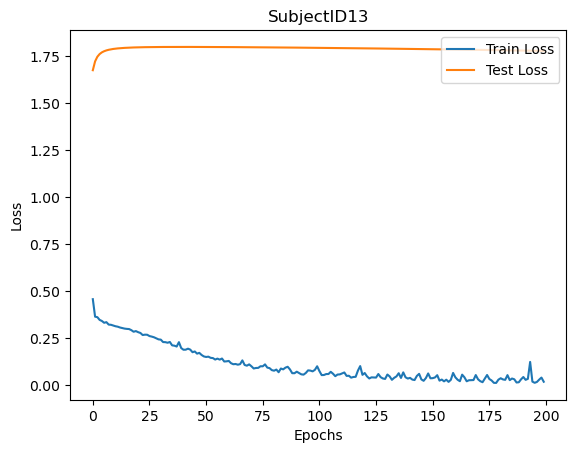

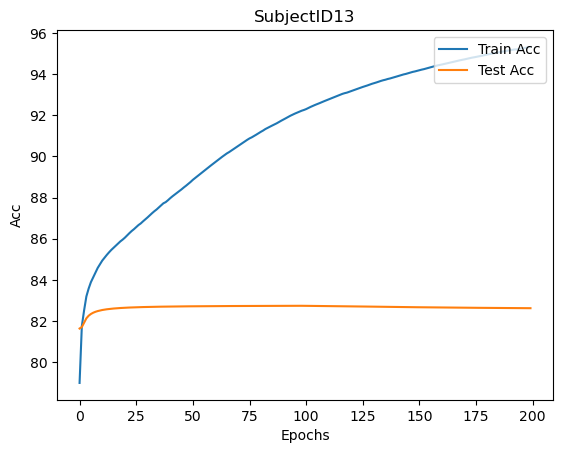


Subject 14
| epoch   0 | 0.2762 s/epoch | train loss 0.4748
| epoch   1 | 0.2763 s/epoch | train loss 0.3832
| epoch   2 | 0.2748 s/epoch | train loss 0.3564
| epoch   3 | 0.2759 s/epoch | train loss 0.3531
| epoch   4 | 0.2755 s/epoch | train loss 0.4187
| epoch   5 | 0.2746 s/epoch | train loss 0.3626
| epoch   6 | 0.2760 s/epoch | train loss 0.3589
| epoch   7 | 0.2753 s/epoch | train loss 0.3355
| epoch   8 | 0.2754 s/epoch | train loss 0.2937
| epoch   9 | 0.2758 s/epoch | train loss 0.3217
| epoch  10 | 0.2746 s/epoch | train loss 0.3283
| epoch  11 | 0.2772 s/epoch | train loss 0.3159
| epoch  12 | 0.2742 s/epoch | train loss 0.3313
| epoch  13 | 0.2758 s/epoch | train loss 0.3040
| epoch  14 | 0.2756 s/epoch | train loss 0.3995
| epoch  15 | 0.2757 s/epoch | train loss 0.4536
| epoch  16 | 0.2770 s/epoch | train loss 0.3706
| epoch  17 | 0.2749 s/epoch | train loss 0.4232
| epoch  18 | 0.2760 s/epoch | train loss 0.3900
| epoch  19 | 0.2766 s/epoch | train loss 0.4207
| epoch 

| epoch 167 | 0.2748 s/epoch | train loss 0.1283
| epoch 168 | 0.2746 s/epoch | train loss 0.1197
| epoch 169 | 0.2752 s/epoch | train loss 0.1266
| epoch 170 | 0.2760 s/epoch | train loss 0.1265
| epoch 171 | 0.2746 s/epoch | train loss 0.2736
| epoch 172 | 0.2759 s/epoch | train loss 0.1915
| epoch 173 | 0.2739 s/epoch | train loss 0.1966
| epoch 174 | 0.2763 s/epoch | train loss 0.1649
| epoch 175 | 0.2755 s/epoch | train loss 0.1309
| epoch 176 | 0.2757 s/epoch | train loss 0.1194
| epoch 177 | 0.2764 s/epoch | train loss 0.1175
| epoch 178 | 0.2794 s/epoch | train loss 0.1493
| epoch 179 | 0.2748 s/epoch | train loss 0.1234
| epoch 180 | 0.2753 s/epoch | train loss 0.1174
| epoch 181 | 0.2756 s/epoch | train loss 0.1362
| epoch 182 | 0.2762 s/epoch | train loss 0.0982
| epoch 183 | 0.2747 s/epoch | train loss 0.1167
| epoch 184 | 0.2740 s/epoch | train loss 0.1066
| epoch 185 | 0.2740 s/epoch | train loss 0.0914
| epoch 186 | 0.2762 s/epoch | train loss 0.1793
| epoch 187 | 0.2763

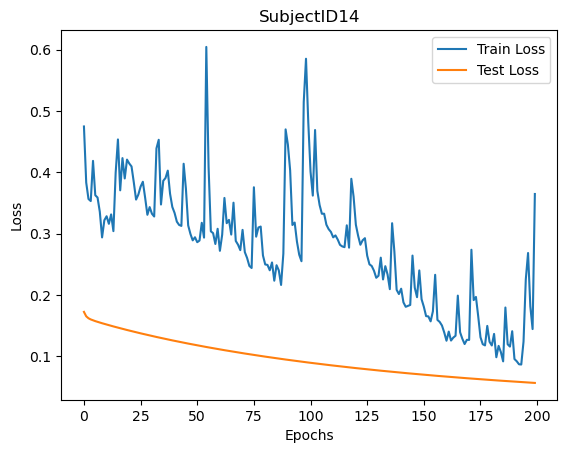

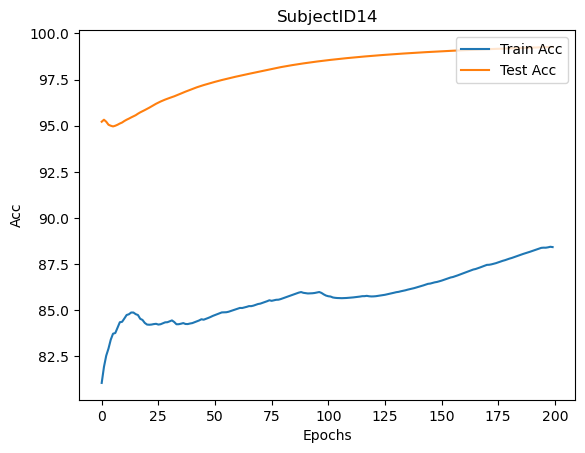

| epoch   0 | 0.0102 s/epoch | train loss 0.4810
| epoch   1 | 0.0107 s/epoch | train loss 0.4002
| epoch   2 | 0.0107 s/epoch | train loss 0.3864
| epoch   3 | 0.0102 s/epoch | train loss 0.3737
| epoch   4 | 0.0095 s/epoch | train loss 0.3634
| epoch   5 | 0.0104 s/epoch | train loss 0.3621
| epoch   6 | 0.0111 s/epoch | train loss 0.3559
| epoch   7 | 0.0097 s/epoch | train loss 0.3506
| epoch   8 | 0.0101 s/epoch | train loss 0.3523
| epoch   9 | 0.0090 s/epoch | train loss 0.3392
| epoch  10 | 0.0100 s/epoch | train loss 0.3324
| epoch  11 | 0.0103 s/epoch | train loss 0.3292
| epoch  12 | 0.0093 s/epoch | train loss 0.3269
| epoch  13 | 0.0098 s/epoch | train loss 0.3201
| epoch  14 | 0.0090 s/epoch | train loss 0.3196
| epoch  15 | 0.0091 s/epoch | train loss 0.3123
| epoch  16 | 0.0087 s/epoch | train loss 0.3086
| epoch  17 | 0.0101 s/epoch | train loss 0.3056
| epoch  18 | 0.0094 s/epoch | train loss 0.2963
| epoch  19 | 0.0094 s/epoch | train loss 0.3033
| epoch  20 | 0.0097

| epoch 168 | 0.0094 s/epoch | train loss 0.0176
| epoch 169 | 0.0091 s/epoch | train loss 0.0492
| epoch 170 | 0.0088 s/epoch | train loss 0.0201
| epoch 171 | 0.0097 s/epoch | train loss 0.0138
| epoch 172 | 0.0086 s/epoch | train loss 0.0120
| epoch 173 | 0.0101 s/epoch | train loss 0.0268
| epoch 174 | 0.0096 s/epoch | train loss 0.1329
| epoch 175 | 0.0089 s/epoch | train loss 0.0217
| epoch 176 | 0.0097 s/epoch | train loss 0.0130
| epoch 177 | 0.0090 s/epoch | train loss 0.0146
| epoch 178 | 0.0097 s/epoch | train loss 0.0238
| epoch 179 | 0.0096 s/epoch | train loss 0.0235
| epoch 180 | 0.0092 s/epoch | train loss 0.0621
| epoch 181 | 0.0090 s/epoch | train loss 0.0180
| epoch 182 | 0.0096 s/epoch | train loss 0.0142
| epoch 183 | 0.0092 s/epoch | train loss 0.0192
| epoch 184 | 0.0089 s/epoch | train loss 0.0306
| epoch 185 | 0.0096 s/epoch | train loss 0.0549
| epoch 186 | 0.0095 s/epoch | train loss 0.0142
| epoch 187 | 0.0088 s/epoch | train loss 0.0304
| epoch 188 | 0.0087

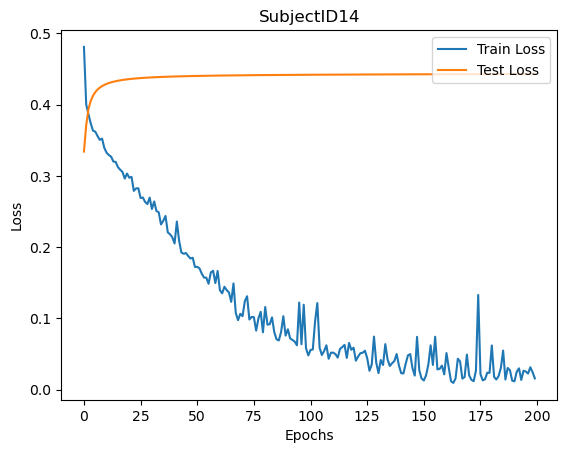

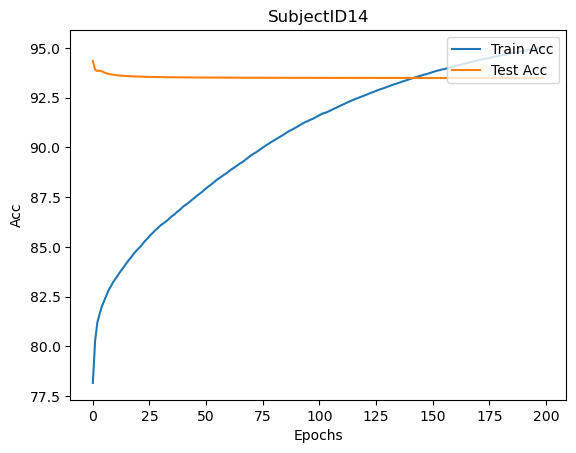


Subject 15
| epoch   0 | 0.2880 s/epoch | train loss 0.4644
| epoch   1 | 0.2854 s/epoch | train loss 0.3259
| epoch   2 | 0.2867 s/epoch | train loss 0.3012
| epoch   3 | 0.2859 s/epoch | train loss 0.2829
| epoch   4 | 0.2858 s/epoch | train loss 0.2762
| epoch   5 | 0.2860 s/epoch | train loss 0.2638
| epoch   6 | 0.2876 s/epoch | train loss 0.2501
| epoch   7 | 0.2864 s/epoch | train loss 0.2423
| epoch   8 | 0.2863 s/epoch | train loss 0.2469
| epoch   9 | 0.2858 s/epoch | train loss 0.2302
| epoch  10 | 0.2874 s/epoch | train loss 0.2209
| epoch  11 | 0.2866 s/epoch | train loss 0.2074
| epoch  12 | 0.2859 s/epoch | train loss 0.2124
| epoch  13 | 0.2867 s/epoch | train loss 0.2075
| epoch  14 | 0.2859 s/epoch | train loss 0.2549
| epoch  15 | 0.2871 s/epoch | train loss 0.4044
| epoch  16 | 0.2870 s/epoch | train loss 0.3451
| epoch  17 | 0.2865 s/epoch | train loss 0.3793
| epoch  18 | 0.2873 s/epoch | train loss 0.3220
| epoch  19 | 0.2843 s/epoch | train loss 0.3071
| epoch 

| epoch 167 | 0.2853 s/epoch | train loss 0.0461
| epoch 168 | 0.2860 s/epoch | train loss 0.0687
| epoch 169 | 0.2880 s/epoch | train loss 0.0485
| epoch 170 | 0.2876 s/epoch | train loss 0.0622
| epoch 171 | 0.2870 s/epoch | train loss 0.0527
| epoch 172 | 0.2865 s/epoch | train loss 0.0389
| epoch 173 | 0.2865 s/epoch | train loss 0.0298
| epoch 174 | 0.2869 s/epoch | train loss 0.0381
| epoch 175 | 0.2855 s/epoch | train loss 0.0463
| epoch 176 | 0.2865 s/epoch | train loss 0.0345
| epoch 177 | 0.2861 s/epoch | train loss 0.0408
| epoch 178 | 0.2861 s/epoch | train loss 0.0436
| epoch 179 | 0.2868 s/epoch | train loss 0.0378
| epoch 180 | 0.2861 s/epoch | train loss 0.0338
| epoch 181 | 0.2856 s/epoch | train loss 0.0503
| epoch 182 | 0.2868 s/epoch | train loss 0.0542
| epoch 183 | 0.2862 s/epoch | train loss 0.0567
| epoch 184 | 0.2863 s/epoch | train loss 0.0383
| epoch 185 | 0.2874 s/epoch | train loss 0.0368
| epoch 186 | 0.2868 s/epoch | train loss 0.1007
| epoch 187 | 0.2867

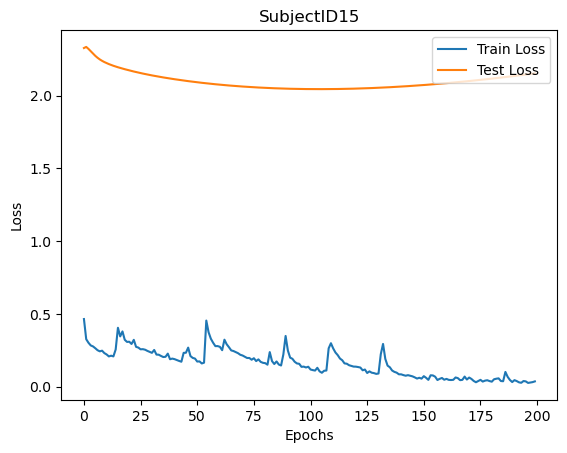

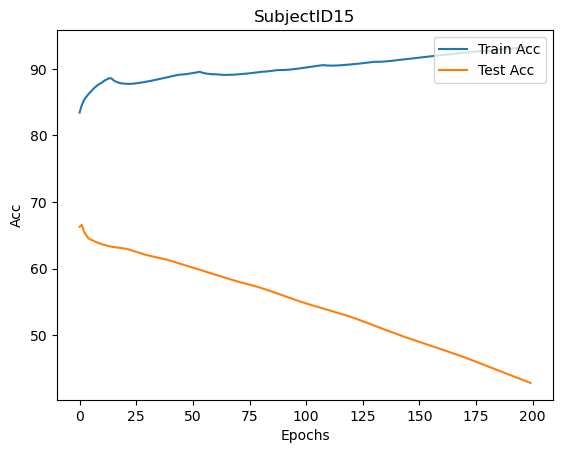

| epoch   0 | 0.0099 s/epoch | train loss 0.4574
| epoch   1 | 0.0101 s/epoch | train loss 0.3737
| epoch   2 | 0.0096 s/epoch | train loss 0.3588
| epoch   3 | 0.0096 s/epoch | train loss 0.3517
| epoch   4 | 0.0097 s/epoch | train loss 0.3462
| epoch   5 | 0.0100 s/epoch | train loss 0.3383
| epoch   6 | 0.0104 s/epoch | train loss 0.3367
| epoch   7 | 0.0097 s/epoch | train loss 0.3319
| epoch   8 | 0.0098 s/epoch | train loss 0.3244
| epoch   9 | 0.0097 s/epoch | train loss 0.3221
| epoch  10 | 0.0101 s/epoch | train loss 0.3191
| epoch  11 | 0.0095 s/epoch | train loss 0.3148
| epoch  12 | 0.0099 s/epoch | train loss 0.3095
| epoch  13 | 0.0101 s/epoch | train loss 0.3059
| epoch  14 | 0.0089 s/epoch | train loss 0.2993
| epoch  15 | 0.0097 s/epoch | train loss 0.2967
| epoch  16 | 0.0089 s/epoch | train loss 0.2920
| epoch  17 | 0.0098 s/epoch | train loss 0.2908
| epoch  18 | 0.0096 s/epoch | train loss 0.2915
| epoch  19 | 0.0104 s/epoch | train loss 0.2842
| epoch  20 | 0.0108

| epoch 168 | 0.0103 s/epoch | train loss 0.0343
| epoch 169 | 0.0094 s/epoch | train loss 0.0288
| epoch 170 | 0.0094 s/epoch | train loss 0.0238
| epoch 171 | 0.0092 s/epoch | train loss 0.0253
| epoch 172 | 0.0100 s/epoch | train loss 0.0210
| epoch 173 | 0.0103 s/epoch | train loss 0.0638
| epoch 174 | 0.0102 s/epoch | train loss 0.0312
| epoch 175 | 0.0098 s/epoch | train loss 0.0291
| epoch 176 | 0.0100 s/epoch | train loss 0.0248
| epoch 177 | 0.0097 s/epoch | train loss 0.0363
| epoch 178 | 0.0104 s/epoch | train loss 0.0575
| epoch 179 | 0.0094 s/epoch | train loss 0.0349
| epoch 180 | 0.0100 s/epoch | train loss 0.0321
| epoch 181 | 0.0101 s/epoch | train loss 0.0193
| epoch 182 | 0.0089 s/epoch | train loss 0.0296
| epoch 183 | 0.0098 s/epoch | train loss 0.0481
| epoch 184 | 0.0101 s/epoch | train loss 0.0275
| epoch 185 | 0.0097 s/epoch | train loss 0.0293
| epoch 186 | 0.0096 s/epoch | train loss 0.0410
| epoch 187 | 0.0093 s/epoch | train loss 0.0293
| epoch 188 | 0.0095

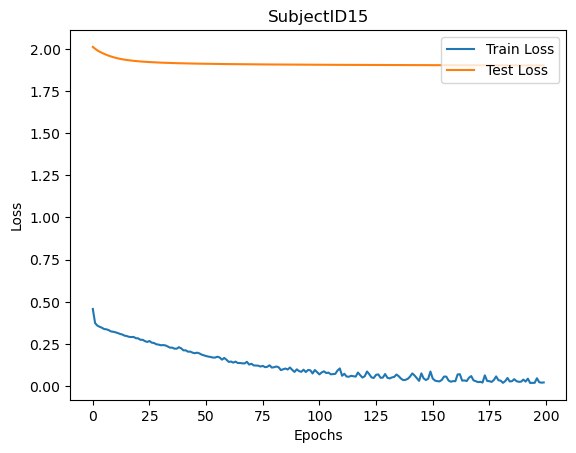

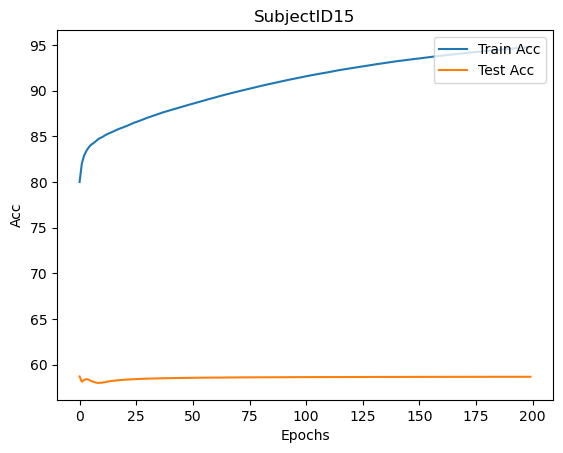

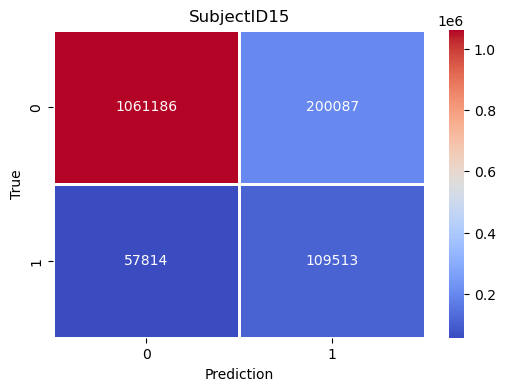

<Figure size 640x480 with 0 Axes>

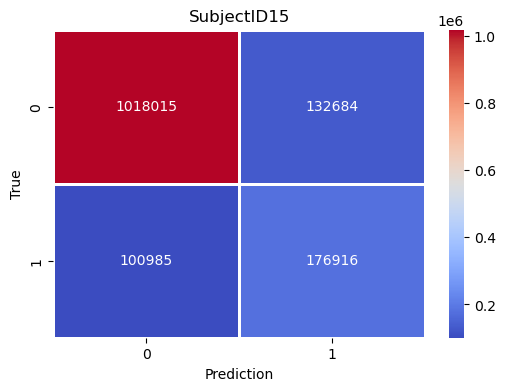

Teacher(RestNet18)_Acc: 0.8194729105417892
Teacher(RestNet18)_Rec: 0.6544849307045486
Teacher(RestNet18)_Pre: 0.3537241602067183
Teacher(RestNet18)_F1: 0.4592442868615113
Original_Student(CNN_Small)_Acc: 0.836434971300574
Original_Student(CNN_Small)_Rec: 0.6366151974983897
Original_Student(CNN_Small)_Pre: 0.5714341085271318
Original_Student(CNN_Small)_F1: 0.6022662089085806


<Figure size 640x480 with 0 Axes>

In [17]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = Net_Student(config).to(device) 
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet18)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet18)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet18)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet18)_F1:",Teacher_eval_table[3])

print("Original_Student(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student(CNN_Small)_F1:",Student_eval_table[3]) 






Subject 1
| epoch   0 | 0.2741 s/epoch | train loss 1.1844
| epoch   1 | 0.2727 s/epoch | train loss 0.8507
| epoch   2 | 0.2721 s/epoch | train loss 0.8116
| epoch   3 | 0.2735 s/epoch | train loss 0.7715
| epoch   4 | 0.2728 s/epoch | train loss 0.7502
| epoch   5 | 0.2744 s/epoch | train loss 0.7524
| epoch   6 | 0.2744 s/epoch | train loss 0.7036
| epoch   7 | 0.2748 s/epoch | train loss 0.7744
| epoch   8 | 0.2736 s/epoch | train loss 0.7154
| epoch   9 | 0.2753 s/epoch | train loss 0.6640
| epoch  10 | 0.2740 s/epoch | train loss 0.6535
| epoch  11 | 0.2758 s/epoch | train loss 0.6886
| epoch  12 | 0.2729 s/epoch | train loss 0.6740
| epoch  13 | 0.2739 s/epoch | train loss 0.6291
| epoch  14 | 0.2741 s/epoch | train loss 0.6099
| epoch  15 | 0.2721 s/epoch | train loss 0.6013
| epoch  16 | 0.2748 s/epoch | train loss 0.6043
| epoch  17 | 0.2735 s/epoch | train loss 0.6302
| epoch  18 | 0.2741 s/epoch | train loss 0.5826
| epoch  19 | 0.2756 s/epoch | train loss 0.5642
| epoch  

| epoch 167 | 0.2733 s/epoch | train loss 0.3606
| epoch 168 | 0.2742 s/epoch | train loss 0.3824
| epoch 169 | 0.2728 s/epoch | train loss 0.5291
| epoch 170 | 0.2743 s/epoch | train loss 0.4356
| epoch 171 | 0.2727 s/epoch | train loss 0.3871
| epoch 172 | 0.2738 s/epoch | train loss 0.3510
| epoch 173 | 0.2740 s/epoch | train loss 0.3563
| epoch 174 | 0.2726 s/epoch | train loss 0.3285
| epoch 175 | 0.2727 s/epoch | train loss 0.3320
| epoch 176 | 0.2728 s/epoch | train loss 0.3255
| epoch 177 | 0.2730 s/epoch | train loss 0.3687
| epoch 178 | 0.2740 s/epoch | train loss 0.3361
| epoch 179 | 0.2731 s/epoch | train loss 0.6699
| epoch 180 | 0.2744 s/epoch | train loss 0.6290
| epoch 181 | 0.2720 s/epoch | train loss 0.5924
| epoch 182 | 0.2745 s/epoch | train loss 0.6658
| epoch 183 | 0.2736 s/epoch | train loss 0.6937
| epoch 184 | 0.2727 s/epoch | train loss 0.6691
| epoch 185 | 0.2736 s/epoch | train loss 0.6337
| epoch 186 | 0.2741 s/epoch | train loss 0.6140
| epoch 187 | 0.2746

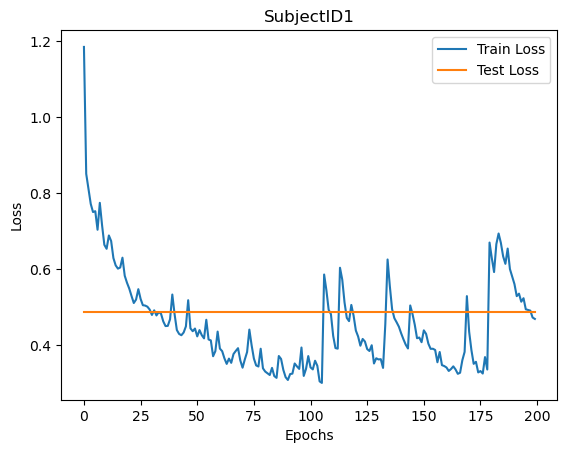

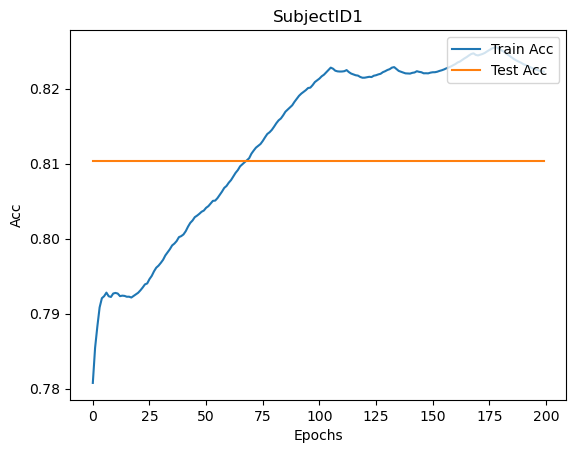

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~

Subject 2
| epoch   0 | 0.2669 s/epoch | train loss 1.2115
| epoch   1 | 0.2674 s/epoch | train loss 0.8422
| epoch   2 | 0.2659 s/epoch | train loss 0.7679
| epoch   3 | 0.2659 s/epoch | train loss 0.8254
| epoch   4 | 0.2658 s/epoch | train loss 0.8185
| epoch   5 | 0.2645 s/epoch | train loss 0.7562
| epoch   6 | 0.2637 s/epoch | train loss 0.7445
| epoch   7 | 0.2665 s/epoch | train loss 0.7138
| epoch   8 | 0.2666 s/epoch | train loss 0.7066
| epoch   9 | 0.2648 s/epoch | train loss 0.6778
| epoch  10 | 0.2648 s/epoch | train loss 0.6546
| epoch  11 | 0.2671 s/epoch | train loss 0.7442
| epoch  12 | 0.2658 s/epoch | train loss 0.7144
| epoch  13 | 0.2656 s/epoch | train loss 0.8108
| epoch  14 | 0.2657 s/epoch | train loss 0.7601
| 

| epoch 162 | 0.2646 s/epoch | train loss 0.4365
| epoch 163 | 0.2665 s/epoch | train loss 0.4783
| epoch 164 | 0.2672 s/epoch | train loss 0.4771
| epoch 165 | 0.2655 s/epoch | train loss 0.4659
| epoch 166 | 0.2636 s/epoch | train loss 0.4809
| epoch 167 | 0.2637 s/epoch | train loss 0.4890
| epoch 168 | 0.2641 s/epoch | train loss 0.4390
| epoch 169 | 0.2644 s/epoch | train loss 0.4219
| epoch 170 | 0.2643 s/epoch | train loss 0.4045
| epoch 171 | 0.2656 s/epoch | train loss 0.3885
| epoch 172 | 0.2658 s/epoch | train loss 0.4108
| epoch 173 | 0.2672 s/epoch | train loss 0.4117
| epoch 174 | 0.2673 s/epoch | train loss 0.3968
| epoch 175 | 0.2648 s/epoch | train loss 0.4153
| epoch 176 | 0.2672 s/epoch | train loss 0.3962
| epoch 177 | 0.2653 s/epoch | train loss 0.3811
| epoch 178 | 0.2647 s/epoch | train loss 0.4057
| epoch 179 | 0.2652 s/epoch | train loss 0.4233
| epoch 180 | 0.2663 s/epoch | train loss 0.4221
| epoch 181 | 0.2661 s/epoch | train loss 0.5000
| epoch 182 | 0.2663

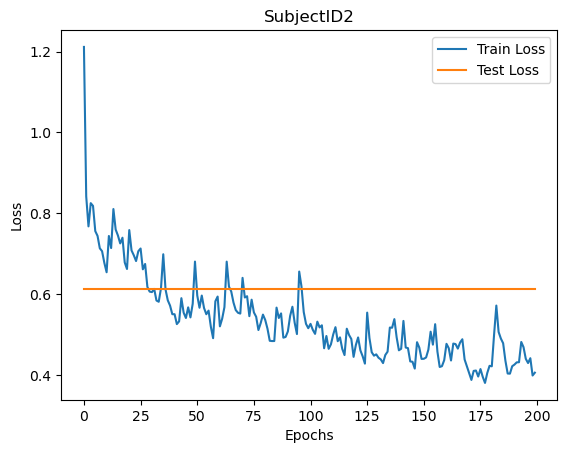

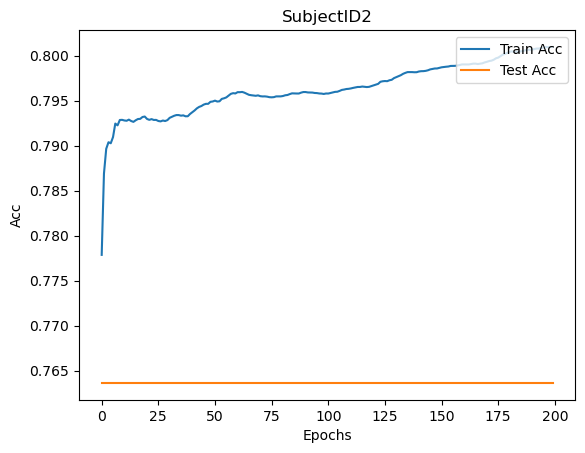


Subject 3
| epoch   0 | 0.2691 s/epoch | train loss 1.1620
| epoch   1 | 0.2657 s/epoch | train loss 0.7898
| epoch   2 | 0.2660 s/epoch | train loss 0.7451
| epoch   3 | 0.2642 s/epoch | train loss 0.7002
| epoch   4 | 0.2635 s/epoch | train loss 0.6996
| epoch   5 | 0.2642 s/epoch | train loss 0.6539
| epoch   6 | 0.2648 s/epoch | train loss 0.6298
| epoch   7 | 0.2652 s/epoch | train loss 0.6243
| epoch   8 | 0.2662 s/epoch | train loss 0.6018
| epoch   9 | 0.2684 s/epoch | train loss 0.6006
| epoch  10 | 0.2649 s/epoch | train loss 0.5847
| epoch  11 | 0.2657 s/epoch | train loss 0.5638
| epoch  12 | 0.2673 s/epoch | train loss 0.5500
| epoch  13 | 0.2670 s/epoch | train loss 0.5634
| epoch  14 | 0.2669 s/epoch | train loss 0.5362
| epoch  15 | 0.2662 s/epoch | train loss 0.5488
| epoch  16 | 0.2663 s/epoch | train loss 0.5331
| epoch  17 | 0.2667 s/epoch | train loss 0.5197
| epoch  18 | 0.2667 s/epoch | train loss 0.5022
| epoch  19 | 0.2661 s/epoch | train loss 0.5165
| epoch  

| epoch 167 | 0.2652 s/epoch | train loss 0.2295
| epoch 168 | 0.2653 s/epoch | train loss 0.2262
| epoch 169 | 0.2662 s/epoch | train loss 0.2210
| epoch 170 | 0.2663 s/epoch | train loss 0.2178
| epoch 171 | 0.2650 s/epoch | train loss 0.2214
| epoch 172 | 0.2665 s/epoch | train loss 0.2322
| epoch 173 | 0.2667 s/epoch | train loss 0.2309
| epoch 174 | 0.2640 s/epoch | train loss 0.2209
| epoch 175 | 0.2655 s/epoch | train loss 0.2143
| epoch 176 | 0.2645 s/epoch | train loss 0.2096
| epoch 177 | 0.2664 s/epoch | train loss 0.2108
| epoch 178 | 0.2663 s/epoch | train loss 0.2201
| epoch 179 | 0.2657 s/epoch | train loss 0.2565
| epoch 180 | 0.2644 s/epoch | train loss 0.2218
| epoch 181 | 0.2644 s/epoch | train loss 0.2223
| epoch 182 | 0.2659 s/epoch | train loss 0.2294
| epoch 183 | 0.2672 s/epoch | train loss 0.2113
| epoch 184 | 0.2668 s/epoch | train loss 0.2223
| epoch 185 | 0.2671 s/epoch | train loss 0.2188
| epoch 186 | 0.2663 s/epoch | train loss 0.2130
| epoch 187 | 0.2641

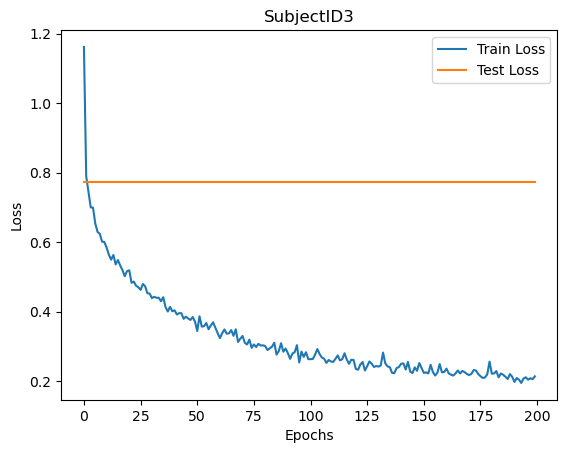

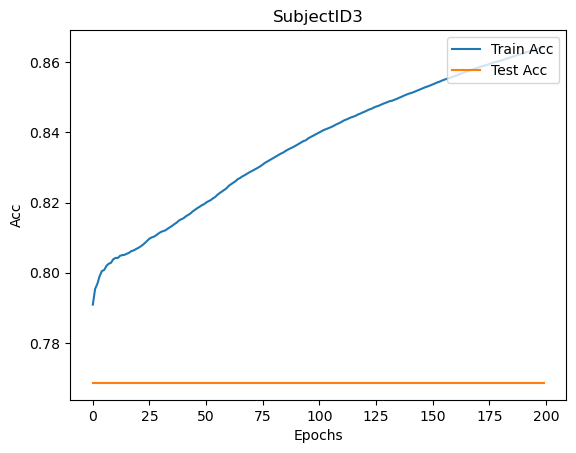


Subject 4
| epoch   0 | 0.2787 s/epoch | train loss 1.1802
| epoch   1 | 0.2768 s/epoch | train loss 0.8727
| epoch   2 | 0.2774 s/epoch | train loss 0.8151
| epoch   3 | 0.2804 s/epoch | train loss 0.7799
| epoch   4 | 0.2793 s/epoch | train loss 0.7547
| epoch   5 | 0.2779 s/epoch | train loss 0.7340
| epoch   6 | 0.2771 s/epoch | train loss 0.6844
| epoch   7 | 0.2775 s/epoch | train loss 0.6753
| epoch   8 | 0.2795 s/epoch | train loss 0.6600
| epoch   9 | 0.2790 s/epoch | train loss 0.6580
| epoch  10 | 0.2803 s/epoch | train loss 0.6339
| epoch  11 | 0.2776 s/epoch | train loss 0.6014
| epoch  12 | 0.2796 s/epoch | train loss 0.5987
| epoch  13 | 0.2810 s/epoch | train loss 0.5992
| epoch  14 | 0.2798 s/epoch | train loss 0.6045
| epoch  15 | 0.2810 s/epoch | train loss 0.5970
| epoch  16 | 0.2791 s/epoch | train loss 0.5716
| epoch  17 | 0.2792 s/epoch | train loss 0.5721
| epoch  18 | 0.2801 s/epoch | train loss 0.5570
| epoch  19 | 0.2785 s/epoch | train loss 0.5368
| epoch  

| epoch 167 | 0.2798 s/epoch | train loss 0.2653
| epoch 168 | 0.2780 s/epoch | train loss 0.2489
| epoch 169 | 0.2797 s/epoch | train loss 0.2552
| epoch 170 | 0.2791 s/epoch | train loss 0.2612
| epoch 171 | 0.2787 s/epoch | train loss 0.3371
| epoch 172 | 0.2784 s/epoch | train loss 0.3438
| epoch 173 | 0.2791 s/epoch | train loss 0.2938
| epoch 174 | 0.2806 s/epoch | train loss 0.2825
| epoch 175 | 0.2820 s/epoch | train loss 0.3070
| epoch 176 | 0.2796 s/epoch | train loss 0.2617
| epoch 177 | 0.2792 s/epoch | train loss 0.2621
| epoch 178 | 0.2799 s/epoch | train loss 0.2642
| epoch 179 | 0.2814 s/epoch | train loss 0.2505
| epoch 180 | 0.2793 s/epoch | train loss 0.2500
| epoch 181 | 0.2790 s/epoch | train loss 0.2594
| epoch 182 | 0.2808 s/epoch | train loss 0.2654
| epoch 183 | 0.2776 s/epoch | train loss 0.2772
| epoch 184 | 0.2782 s/epoch | train loss 0.2539
| epoch 185 | 0.2797 s/epoch | train loss 0.2321
| epoch 186 | 0.2775 s/epoch | train loss 0.2315
| epoch 187 | 0.2793

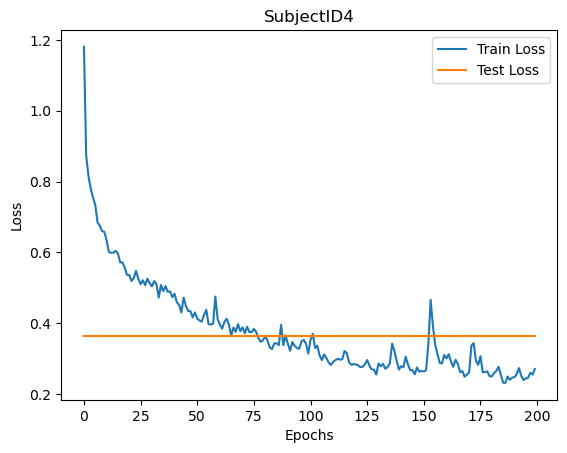

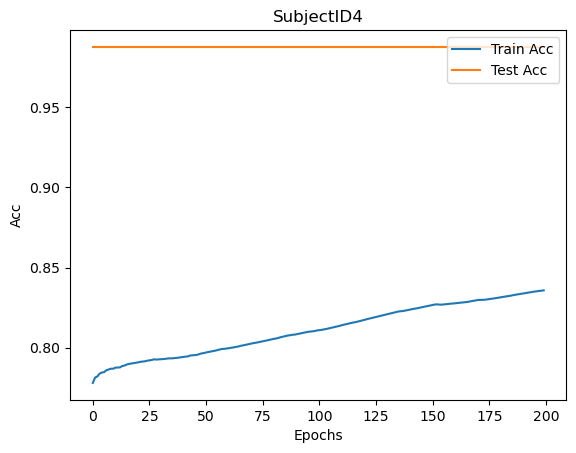


Subject 5
| epoch   0 | 0.2672 s/epoch | train loss 1.1631
| epoch   1 | 0.2678 s/epoch | train loss 0.7999
| epoch   2 | 0.2660 s/epoch | train loss 0.7624
| epoch   3 | 0.2659 s/epoch | train loss 0.7233
| epoch   4 | 0.2665 s/epoch | train loss 0.6955
| epoch   5 | 0.2661 s/epoch | train loss 0.6757
| epoch   6 | 0.2662 s/epoch | train loss 0.6660
| epoch   7 | 0.2655 s/epoch | train loss 0.6280
| epoch   8 | 0.2677 s/epoch | train loss 0.6251
| epoch   9 | 0.2659 s/epoch | train loss 0.6037
| epoch  10 | 0.2671 s/epoch | train loss 0.5732
| epoch  11 | 0.2671 s/epoch | train loss 0.5737
| epoch  12 | 0.2660 s/epoch | train loss 0.5560
| epoch  13 | 0.2664 s/epoch | train loss 0.5561
| epoch  14 | 0.2679 s/epoch | train loss 0.5422
| epoch  15 | 0.2662 s/epoch | train loss 0.5422
| epoch  16 | 0.2671 s/epoch | train loss 0.5104
| epoch  17 | 0.2669 s/epoch | train loss 0.5126
| epoch  18 | 0.2657 s/epoch | train loss 0.5147
| epoch  19 | 0.2663 s/epoch | train loss 0.5196
| epoch  

| epoch 167 | 0.2669 s/epoch | train loss 0.2586
| epoch 168 | 0.2678 s/epoch | train loss 0.2561
| epoch 169 | 0.2647 s/epoch | train loss 0.3199
| epoch 170 | 0.2673 s/epoch | train loss 0.2642
| epoch 171 | 0.2682 s/epoch | train loss 0.2522
| epoch 172 | 0.2669 s/epoch | train loss 0.2538
| epoch 173 | 0.2685 s/epoch | train loss 0.2845
| epoch 174 | 0.2660 s/epoch | train loss 0.2547
| epoch 175 | 0.2656 s/epoch | train loss 0.2793
| epoch 176 | 0.2658 s/epoch | train loss 0.2585
| epoch 177 | 0.2676 s/epoch | train loss 0.3262
| epoch 178 | 0.2666 s/epoch | train loss 0.2778
| epoch 179 | 0.2652 s/epoch | train loss 0.2588
| epoch 180 | 0.2676 s/epoch | train loss 0.2459
| epoch 181 | 0.2675 s/epoch | train loss 0.2344
| epoch 182 | 0.2679 s/epoch | train loss 0.2367
| epoch 183 | 0.2662 s/epoch | train loss 0.2461
| epoch 184 | 0.2672 s/epoch | train loss 0.2438
| epoch 185 | 0.2661 s/epoch | train loss 0.2805
| epoch 186 | 0.2666 s/epoch | train loss 0.2733
| epoch 187 | 0.2673

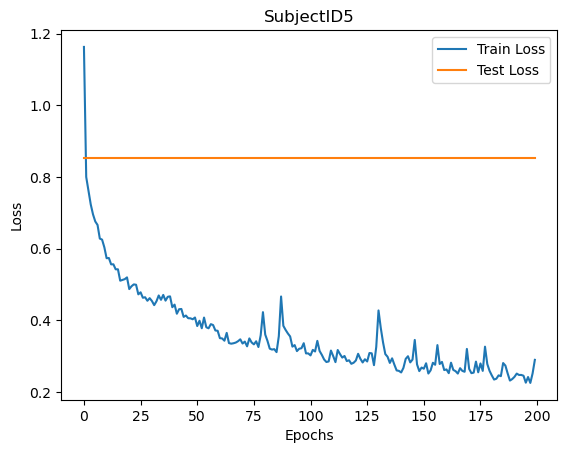

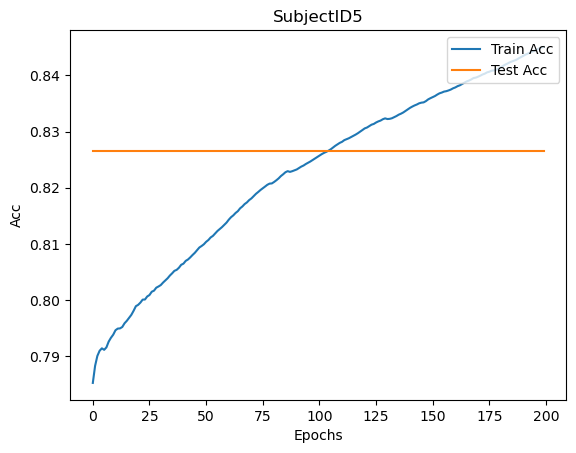


Subject 7
| epoch   0 | 0.2612 s/epoch | train loss 1.1506
| epoch   1 | 0.2619 s/epoch | train loss 0.7812
| epoch   2 | 0.2610 s/epoch | train loss 0.7175
| epoch   3 | 0.2603 s/epoch | train loss 0.6681
| epoch   4 | 0.2625 s/epoch | train loss 0.6721
| epoch   5 | 0.2616 s/epoch | train loss 0.6176
| epoch   6 | 0.2610 s/epoch | train loss 0.6097
| epoch   7 | 0.2611 s/epoch | train loss 0.6145
| epoch   8 | 0.2617 s/epoch | train loss 0.5782
| epoch   9 | 0.2608 s/epoch | train loss 0.5744
| epoch  10 | 0.2613 s/epoch | train loss 0.5471
| epoch  11 | 0.2621 s/epoch | train loss 0.5454
| epoch  12 | 0.2628 s/epoch | train loss 0.5372
| epoch  13 | 0.2601 s/epoch | train loss 0.5207
| epoch  14 | 0.2605 s/epoch | train loss 0.5099
| epoch  15 | 0.2602 s/epoch | train loss 0.5107
| epoch  16 | 0.2625 s/epoch | train loss 0.4910
| epoch  17 | 0.2620 s/epoch | train loss 0.4997
| epoch  18 | 0.2609 s/epoch | train loss 0.4793
| epoch  19 | 0.2627 s/epoch | train loss 0.4839
| epoch  

| epoch 167 | 0.2614 s/epoch | train loss 0.3258
| epoch 168 | 0.2608 s/epoch | train loss 0.3258
| epoch 169 | 0.2621 s/epoch | train loss 0.3145
| epoch 170 | 0.2618 s/epoch | train loss 0.2915
| epoch 171 | 0.2626 s/epoch | train loss 0.2929
| epoch 172 | 0.2603 s/epoch | train loss 0.2880
| epoch 173 | 0.2619 s/epoch | train loss 0.2869
| epoch 174 | 0.2603 s/epoch | train loss 0.3040
| epoch 175 | 0.2619 s/epoch | train loss 0.2947
| epoch 176 | 0.2606 s/epoch | train loss 0.2896
| epoch 177 | 0.2622 s/epoch | train loss 0.2774
| epoch 178 | 0.2622 s/epoch | train loss 0.2728
| epoch 179 | 0.2617 s/epoch | train loss 0.3140
| epoch 180 | 0.2596 s/epoch | train loss 0.3961
| epoch 181 | 0.2616 s/epoch | train loss 0.3482
| epoch 182 | 0.2612 s/epoch | train loss 0.3250
| epoch 183 | 0.2627 s/epoch | train loss 0.3099
| epoch 184 | 0.2602 s/epoch | train loss 0.2968
| epoch 185 | 0.2627 s/epoch | train loss 0.2826
| epoch 186 | 0.2623 s/epoch | train loss 0.2948
| epoch 187 | 0.2602

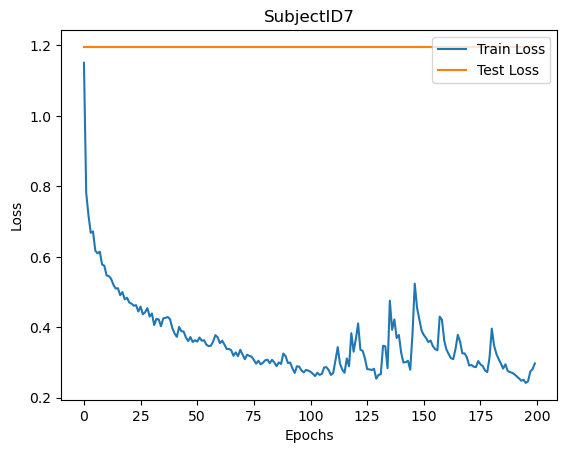

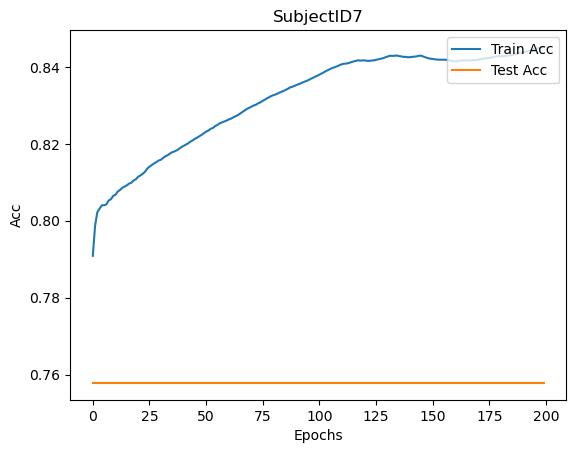


Subject 8
| epoch   0 | 0.2754 s/epoch | train loss 1.2160
| epoch   1 | 0.2725 s/epoch | train loss 0.8523
| epoch   2 | 0.2722 s/epoch | train loss 0.7758
| epoch   3 | 0.2747 s/epoch | train loss 0.7415
| epoch   4 | 0.2728 s/epoch | train loss 0.6995
| epoch   5 | 0.2733 s/epoch | train loss 0.6507
| epoch   6 | 0.2738 s/epoch | train loss 0.6244
| epoch   7 | 0.2736 s/epoch | train loss 0.6334
| epoch   8 | 0.2703 s/epoch | train loss 0.6029
| epoch   9 | 0.2755 s/epoch | train loss 0.6085
| epoch  10 | 0.2761 s/epoch | train loss 0.5812
| epoch  11 | 0.2748 s/epoch | train loss 0.5755
| epoch  12 | 0.2734 s/epoch | train loss 0.5657
| epoch  13 | 0.2768 s/epoch | train loss 0.5535
| epoch  14 | 0.2735 s/epoch | train loss 0.5404
| epoch  15 | 0.2733 s/epoch | train loss 0.5187
| epoch  16 | 0.2734 s/epoch | train loss 0.5344
| epoch  17 | 0.2743 s/epoch | train loss 0.5251
| epoch  18 | 0.2753 s/epoch | train loss 0.5071
| epoch  19 | 0.2731 s/epoch | train loss 0.5132
| epoch  

| epoch 167 | 0.2748 s/epoch | train loss 0.3268
| epoch 168 | 0.2721 s/epoch | train loss 0.3326
| epoch 169 | 0.2751 s/epoch | train loss 0.3243
| epoch 170 | 0.2733 s/epoch | train loss 0.3162
| epoch 171 | 0.2747 s/epoch | train loss 0.3134
| epoch 172 | 0.2733 s/epoch | train loss 0.2956
| epoch 173 | 0.2739 s/epoch | train loss 0.2674
| epoch 174 | 0.2750 s/epoch | train loss 0.2547
| epoch 175 | 0.2721 s/epoch | train loss 0.2676
| epoch 176 | 0.2732 s/epoch | train loss 0.2515
| epoch 177 | 0.2737 s/epoch | train loss 0.2861
| epoch 178 | 0.2726 s/epoch | train loss 0.2924
| epoch 179 | 0.2761 s/epoch | train loss 0.2991
| epoch 180 | 0.2737 s/epoch | train loss 0.3226
| epoch 181 | 0.2755 s/epoch | train loss 0.2853
| epoch 182 | 0.2738 s/epoch | train loss 0.2545
| epoch 183 | 0.2755 s/epoch | train loss 0.2781
| epoch 184 | 0.2749 s/epoch | train loss 0.3041
| epoch 185 | 0.2732 s/epoch | train loss 0.3267
| epoch 186 | 0.2770 s/epoch | train loss 0.2779
| epoch 187 | 0.2755

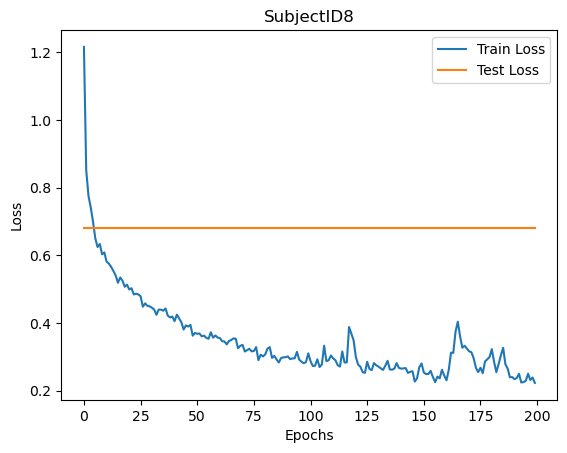

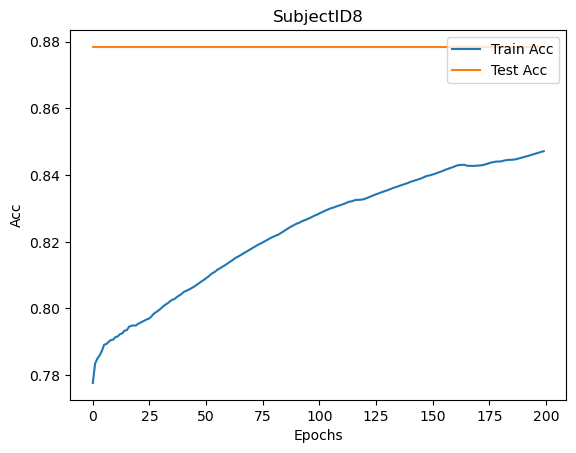


Subject 9
| epoch   0 | 0.2703 s/epoch | train loss 1.1811
| epoch   1 | 0.2687 s/epoch | train loss 0.8444
| epoch   2 | 0.2682 s/epoch | train loss 0.7727
| epoch   3 | 0.2689 s/epoch | train loss 0.7387
| epoch   4 | 0.2680 s/epoch | train loss 0.7064
| epoch   5 | 0.2689 s/epoch | train loss 0.6769
| epoch   6 | 0.2694 s/epoch | train loss 0.6610
| epoch   7 | 0.2659 s/epoch | train loss 0.6499
| epoch   8 | 0.2678 s/epoch | train loss 0.6323
| epoch   9 | 0.2694 s/epoch | train loss 0.6106
| epoch  10 | 0.2689 s/epoch | train loss 0.6015
| epoch  11 | 0.2698 s/epoch | train loss 0.6072
| epoch  12 | 0.2693 s/epoch | train loss 0.5993
| epoch  13 | 0.2705 s/epoch | train loss 0.5693
| epoch  14 | 0.2687 s/epoch | train loss 0.5785
| epoch  15 | 0.2702 s/epoch | train loss 0.5713
| epoch  16 | 0.2699 s/epoch | train loss 0.5493
| epoch  17 | 0.2690 s/epoch | train loss 0.5369
| epoch  18 | 0.2695 s/epoch | train loss 0.5502
| epoch  19 | 0.2703 s/epoch | train loss 0.5316
| epoch  

| epoch 167 | 0.2700 s/epoch | train loss 0.3918
| epoch 168 | 0.2699 s/epoch | train loss 0.3739
| epoch 169 | 0.2700 s/epoch | train loss 0.3784
| epoch 170 | 0.2689 s/epoch | train loss 0.3897
| epoch 171 | 0.2681 s/epoch | train loss 0.4450
| epoch 172 | 0.2676 s/epoch | train loss 0.4004
| epoch 173 | 0.2685 s/epoch | train loss 0.3820
| epoch 174 | 0.2697 s/epoch | train loss 0.3759
| epoch 175 | 0.2685 s/epoch | train loss 0.3591
| epoch 176 | 0.2707 s/epoch | train loss 0.3478
| epoch 177 | 0.2676 s/epoch | train loss 0.3353
| epoch 178 | 0.2708 s/epoch | train loss 0.3389
| epoch 179 | 0.2710 s/epoch | train loss 0.3318
| epoch 180 | 0.2704 s/epoch | train loss 0.3279
| epoch 181 | 0.2714 s/epoch | train loss 0.3104
| epoch 182 | 0.2705 s/epoch | train loss 0.3093
| epoch 183 | 0.2699 s/epoch | train loss 0.3095
| epoch 184 | 0.2694 s/epoch | train loss 0.3144
| epoch 185 | 0.2704 s/epoch | train loss 0.3323
| epoch 186 | 0.2689 s/epoch | train loss 0.3100
| epoch 187 | 0.2701

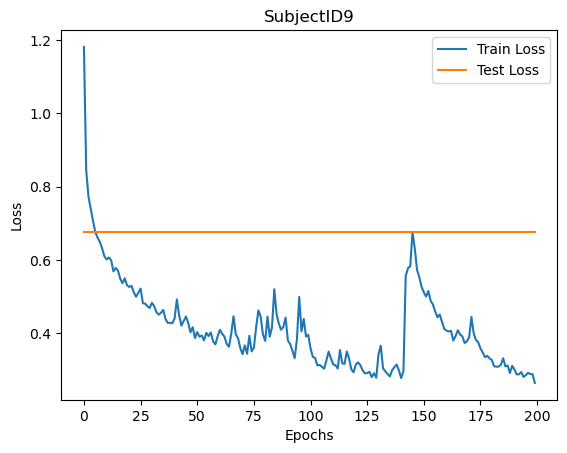

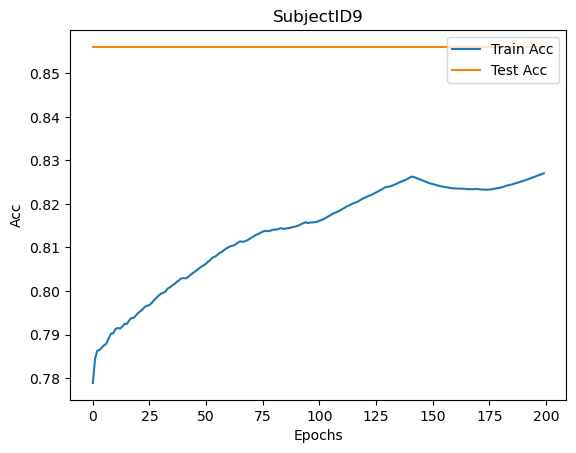


Subject 10
| epoch   0 | 0.2793 s/epoch | train loss 1.2211
| epoch   1 | 0.2785 s/epoch | train loss 0.8414
| epoch   2 | 0.2792 s/epoch | train loss 0.7838
| epoch   3 | 0.2780 s/epoch | train loss 0.7687
| epoch   4 | 0.2798 s/epoch | train loss 0.7306
| epoch   5 | 0.2801 s/epoch | train loss 0.7092
| epoch   6 | 0.2793 s/epoch | train loss 0.6728
| epoch   7 | 0.2781 s/epoch | train loss 0.6510
| epoch   8 | 0.2789 s/epoch | train loss 0.6273
| epoch   9 | 0.2806 s/epoch | train loss 0.6243
| epoch  10 | 0.2805 s/epoch | train loss 0.6177
| epoch  11 | 0.2802 s/epoch | train loss 0.5941
| epoch  12 | 0.2809 s/epoch | train loss 0.5757
| epoch  13 | 0.2796 s/epoch | train loss 0.5809
| epoch  14 | 0.2796 s/epoch | train loss 0.5681
| epoch  15 | 0.2806 s/epoch | train loss 0.5581
| epoch  16 | 0.2796 s/epoch | train loss 0.5416
| epoch  17 | 0.2805 s/epoch | train loss 0.5526
| epoch  18 | 0.2804 s/epoch | train loss 0.5363
| epoch  19 | 0.2798 s/epoch | train loss 0.5230
| epoch 

| epoch 167 | 0.2799 s/epoch | train loss 0.2375
| epoch 168 | 0.2799 s/epoch | train loss 0.2547
| epoch 169 | 0.2781 s/epoch | train loss 0.2786
| epoch 170 | 0.2804 s/epoch | train loss 0.2399
| epoch 171 | 0.2776 s/epoch | train loss 0.2309
| epoch 172 | 0.2802 s/epoch | train loss 0.2387
| epoch 173 | 0.2773 s/epoch | train loss 0.2400
| epoch 174 | 0.2804 s/epoch | train loss 0.2312
| epoch 175 | 0.2790 s/epoch | train loss 0.2417
| epoch 176 | 0.2805 s/epoch | train loss 0.2268
| epoch 177 | 0.2791 s/epoch | train loss 0.2290
| epoch 178 | 0.2785 s/epoch | train loss 0.2287
| epoch 179 | 0.2790 s/epoch | train loss 0.2250
| epoch 180 | 0.2810 s/epoch | train loss 0.2391
| epoch 181 | 0.2812 s/epoch | train loss 0.2298
| epoch 182 | 0.2799 s/epoch | train loss 0.2371
| epoch 183 | 0.2796 s/epoch | train loss 0.2227
| epoch 184 | 0.2790 s/epoch | train loss 0.2179
| epoch 185 | 0.2793 s/epoch | train loss 0.2218
| epoch 186 | 0.2785 s/epoch | train loss 0.2618
| epoch 187 | 0.2777

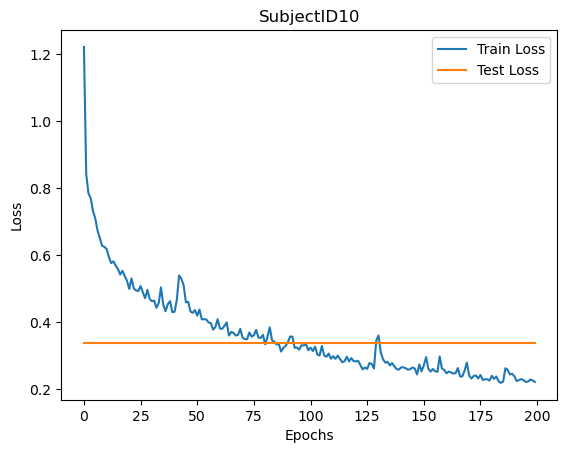

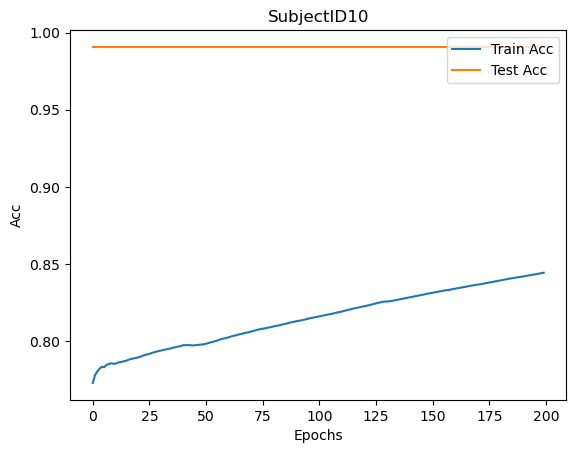


Subject 11
| epoch   0 | 0.2771 s/epoch | train loss 1.2895
| epoch   1 | 0.2761 s/epoch | train loss 0.8831
| epoch   2 | 0.2767 s/epoch | train loss 0.8370
| epoch   3 | 0.2763 s/epoch | train loss 0.7729
| epoch   4 | 0.2741 s/epoch | train loss 0.7510
| epoch   5 | 0.2777 s/epoch | train loss 0.7286
| epoch   6 | 0.2766 s/epoch | train loss 0.6898
| epoch   7 | 0.2742 s/epoch | train loss 0.6779
| epoch   8 | 0.2776 s/epoch | train loss 0.6586
| epoch   9 | 0.2765 s/epoch | train loss 0.6489
| epoch  10 | 0.2771 s/epoch | train loss 0.6388
| epoch  11 | 0.2770 s/epoch | train loss 0.6323
| epoch  12 | 0.2792 s/epoch | train loss 0.6261
| epoch  13 | 0.2781 s/epoch | train loss 0.6171
| epoch  14 | 0.2739 s/epoch | train loss 0.6018
| epoch  15 | 0.2759 s/epoch | train loss 0.6583
| epoch  16 | 0.2756 s/epoch | train loss 0.6883
| epoch  17 | 0.2749 s/epoch | train loss 0.6324
| epoch  18 | 0.2767 s/epoch | train loss 0.5883
| epoch  19 | 0.2785 s/epoch | train loss 0.6200
| epoch 

| epoch 167 | 0.2754 s/epoch | train loss 0.3676
| epoch 168 | 0.2752 s/epoch | train loss 0.3000
| epoch 169 | 0.2782 s/epoch | train loss 0.2696
| epoch 170 | 0.2772 s/epoch | train loss 0.2658
| epoch 171 | 0.2755 s/epoch | train loss 0.3071
| epoch 172 | 0.2763 s/epoch | train loss 0.4126
| epoch 173 | 0.2757 s/epoch | train loss 0.4208
| epoch 174 | 0.2768 s/epoch | train loss 0.3485
| epoch 175 | 0.2767 s/epoch | train loss 0.3250
| epoch 176 | 0.2775 s/epoch | train loss 0.2939
| epoch 177 | 0.2752 s/epoch | train loss 0.2916
| epoch 178 | 0.2773 s/epoch | train loss 0.2784
| epoch 179 | 0.2766 s/epoch | train loss 0.2590
| epoch 180 | 0.2770 s/epoch | train loss 0.2515
| epoch 181 | 0.2778 s/epoch | train loss 0.2535
| epoch 182 | 0.2740 s/epoch | train loss 0.2579
| epoch 183 | 0.2770 s/epoch | train loss 0.2441
| epoch 184 | 0.2742 s/epoch | train loss 0.2507
| epoch 185 | 0.2759 s/epoch | train loss 0.2588
| epoch 186 | 0.2763 s/epoch | train loss 0.2589
| epoch 187 | 0.2778

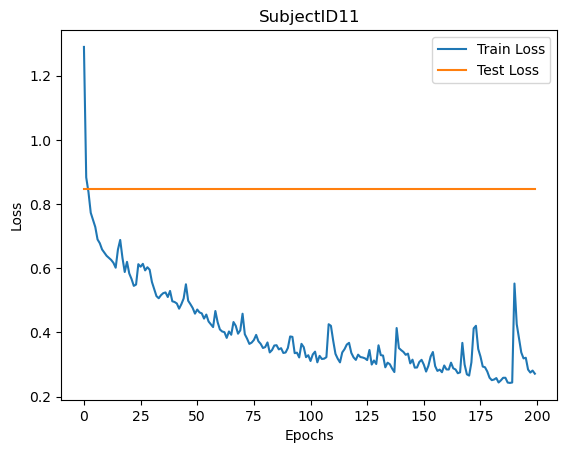

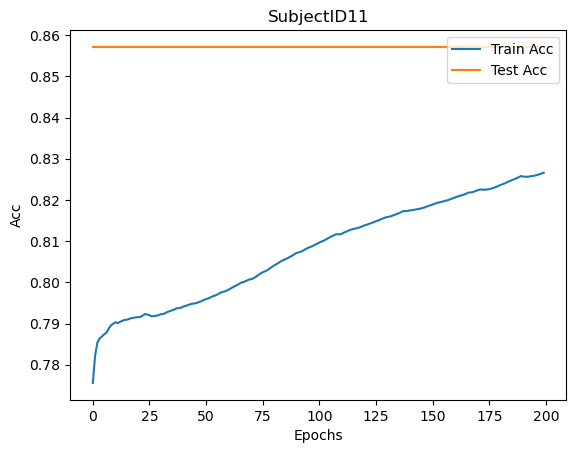


Subject 12
| epoch   0 | 0.2642 s/epoch | train loss 1.2232
| epoch   1 | 0.2635 s/epoch | train loss 0.8424
| epoch   2 | 0.2648 s/epoch | train loss 0.7705
| epoch   3 | 0.2617 s/epoch | train loss 0.7279
| epoch   4 | 0.2632 s/epoch | train loss 0.7209
| epoch   5 | 0.2623 s/epoch | train loss 0.7202
| epoch   6 | 0.2625 s/epoch | train loss 0.6752
| epoch   7 | 0.2651 s/epoch | train loss 0.6491
| epoch   8 | 0.2639 s/epoch | train loss 0.6677
| epoch   9 | 0.2622 s/epoch | train loss 0.6239
| epoch  10 | 0.2613 s/epoch | train loss 0.6139
| epoch  11 | 0.2629 s/epoch | train loss 0.5942
| epoch  12 | 0.2653 s/epoch | train loss 0.5899
| epoch  13 | 0.2619 s/epoch | train loss 0.6049
| epoch  14 | 0.2640 s/epoch | train loss 0.5745
| epoch  15 | 0.2651 s/epoch | train loss 0.5810
| epoch  16 | 0.2633 s/epoch | train loss 0.5730
| epoch  17 | 0.2627 s/epoch | train loss 0.5515
| epoch  18 | 0.2653 s/epoch | train loss 0.5418
| epoch  19 | 0.2629 s/epoch | train loss 0.5330
| epoch 

| epoch 167 | 0.2930 s/epoch | train loss 0.3262
| epoch 168 | 0.2897 s/epoch | train loss 0.3241
| epoch 169 | 0.2887 s/epoch | train loss 0.3080
| epoch 170 | 0.2903 s/epoch | train loss 0.3092
| epoch 171 | 0.2881 s/epoch | train loss 0.3155
| epoch 172 | 0.2871 s/epoch | train loss 0.3122
| epoch 173 | 0.2875 s/epoch | train loss 0.3025
| epoch 174 | 0.2426 s/epoch | train loss 0.2957
| epoch 175 | 0.2300 s/epoch | train loss 0.4055
| epoch 176 | 0.2307 s/epoch | train loss 0.4187
| epoch 177 | 0.2357 s/epoch | train loss 0.3683
| epoch 178 | 0.2582 s/epoch | train loss 0.3515
| epoch 179 | 0.2324 s/epoch | train loss 0.3378
| epoch 180 | 0.2300 s/epoch | train loss 0.3163
| epoch 181 | 0.2287 s/epoch | train loss 0.2983
| epoch 182 | 0.2320 s/epoch | train loss 0.2763
| epoch 183 | 0.2329 s/epoch | train loss 0.2859
| epoch 184 | 0.2314 s/epoch | train loss 0.2895
| epoch 185 | 0.2303 s/epoch | train loss 0.2920
| epoch 186 | 0.2313 s/epoch | train loss 0.2806
| epoch 187 | 0.2292

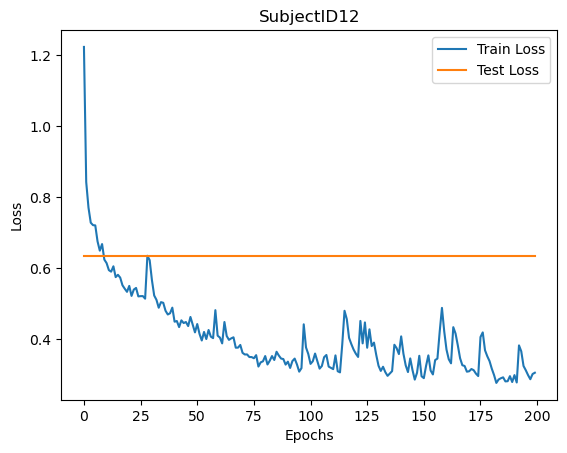

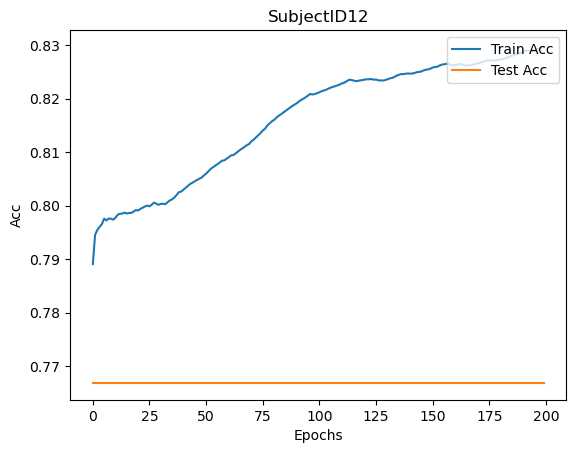


Subject 13
| epoch   0 | 0.2312 s/epoch | train loss 1.2705
| epoch   1 | 0.2287 s/epoch | train loss 0.8577
| epoch   2 | 0.2331 s/epoch | train loss 0.7770
| epoch   3 | 0.2291 s/epoch | train loss 0.7277
| epoch   4 | 0.2291 s/epoch | train loss 0.7162
| epoch   5 | 0.2317 s/epoch | train loss 0.6724
| epoch   6 | 0.2305 s/epoch | train loss 0.6759
| epoch   7 | 0.2292 s/epoch | train loss 0.6528
| epoch   8 | 0.2296 s/epoch | train loss 0.6159
| epoch   9 | 0.2317 s/epoch | train loss 0.6064
| epoch  10 | 0.2291 s/epoch | train loss 0.6050
| epoch  11 | 0.2318 s/epoch | train loss 0.5780
| epoch  12 | 0.2302 s/epoch | train loss 0.5447
| epoch  13 | 0.2264 s/epoch | train loss 0.5578
| epoch  14 | 0.2326 s/epoch | train loss 0.5409
| epoch  15 | 0.2302 s/epoch | train loss 0.5236
| epoch  16 | 0.2293 s/epoch | train loss 0.5371
| epoch  17 | 0.2317 s/epoch | train loss 0.5373
| epoch  18 | 0.2314 s/epoch | train loss 0.5116
| epoch  19 | 0.2301 s/epoch | train loss 0.5166
| epoch 

| epoch 167 | 0.1738 s/epoch | train loss 0.2427
| epoch 168 | 0.1776 s/epoch | train loss 0.2747
| epoch 169 | 0.1744 s/epoch | train loss 0.2604
| epoch 170 | 0.1741 s/epoch | train loss 0.2416
| epoch 171 | 0.1738 s/epoch | train loss 0.2329
| epoch 172 | 0.1738 s/epoch | train loss 0.2339
| epoch 173 | 0.1743 s/epoch | train loss 0.2195
| epoch 174 | 0.1735 s/epoch | train loss 0.2213
| epoch 175 | 0.1741 s/epoch | train loss 0.2735
| epoch 176 | 0.1720 s/epoch | train loss 0.2656
| epoch 177 | 0.1737 s/epoch | train loss 0.2383
| epoch 178 | 0.1744 s/epoch | train loss 0.2266
| epoch 179 | 0.1747 s/epoch | train loss 0.2264
| epoch 180 | 0.1764 s/epoch | train loss 0.2382
| epoch 181 | 0.1737 s/epoch | train loss 0.2322
| epoch 182 | 0.1746 s/epoch | train loss 0.2285
| epoch 183 | 0.1720 s/epoch | train loss 0.2228
| epoch 184 | 0.1758 s/epoch | train loss 0.3253
| epoch 185 | 0.1766 s/epoch | train loss 0.2727
| epoch 186 | 0.1732 s/epoch | train loss 0.2736
| epoch 187 | 0.1743

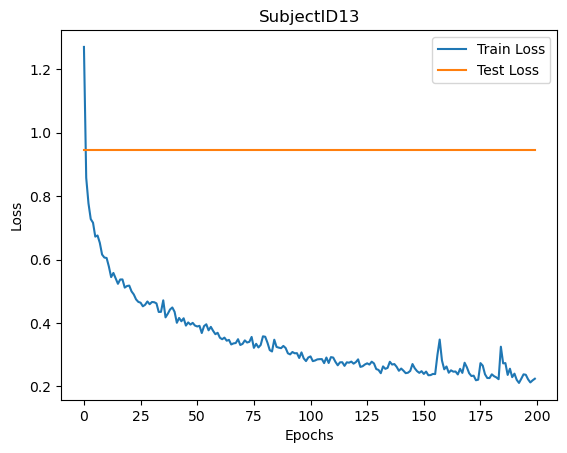

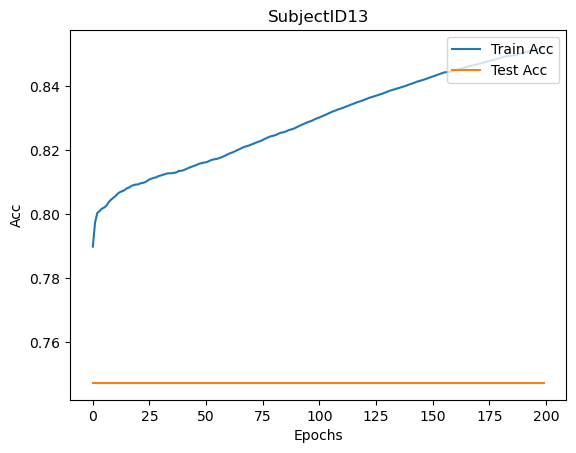


Subject 14
| epoch   0 | 0.1802 s/epoch | train loss 1.2838
| epoch   1 | 0.1838 s/epoch | train loss 0.9645
| epoch   2 | 0.1822 s/epoch | train loss 0.8839
| epoch   3 | 0.1815 s/epoch | train loss 0.8379
| epoch   4 | 0.1816 s/epoch | train loss 0.8427
| epoch   5 | 0.1804 s/epoch | train loss 0.7808
| epoch   6 | 0.1839 s/epoch | train loss 0.7999
| epoch   7 | 0.1830 s/epoch | train loss 0.8012
| epoch   8 | 0.1797 s/epoch | train loss 0.8295
| epoch   9 | 0.1804 s/epoch | train loss 0.8168
| epoch  10 | 0.1826 s/epoch | train loss 0.7577
| epoch  11 | 0.1797 s/epoch | train loss 0.7303
| epoch  12 | 0.1805 s/epoch | train loss 0.7034
| epoch  13 | 0.1821 s/epoch | train loss 0.7243
| epoch  14 | 0.1815 s/epoch | train loss 0.8088
| epoch  15 | 0.1802 s/epoch | train loss 0.7646
| epoch  16 | 0.1822 s/epoch | train loss 0.8050
| epoch  17 | 0.1812 s/epoch | train loss 0.7634
| epoch  18 | 0.1828 s/epoch | train loss 0.7228
| epoch  19 | 0.1839 s/epoch | train loss 0.7118
| epoch 

| epoch 167 | 0.1794 s/epoch | train loss 0.4384
| epoch 168 | 0.1802 s/epoch | train loss 0.4406
| epoch 169 | 0.1780 s/epoch | train loss 0.4946
| epoch 170 | 0.1760 s/epoch | train loss 0.4670
| epoch 171 | 0.1777 s/epoch | train loss 0.4513
| epoch 172 | 0.1776 s/epoch | train loss 0.4658
| epoch 173 | 0.1782 s/epoch | train loss 0.4891
| epoch 174 | 0.1746 s/epoch | train loss 0.5005
| epoch 175 | 0.1800 s/epoch | train loss 0.4821
| epoch 176 | 0.1808 s/epoch | train loss 0.4438
| epoch 177 | 0.1803 s/epoch | train loss 0.4367
| epoch 178 | 0.1787 s/epoch | train loss 0.4312
| epoch 179 | 0.1785 s/epoch | train loss 0.4155
| epoch 180 | 0.1799 s/epoch | train loss 0.4295
| epoch 181 | 0.1789 s/epoch | train loss 0.4257
| epoch 182 | 0.1787 s/epoch | train loss 0.4082
| epoch 183 | 0.1794 s/epoch | train loss 0.4030
| epoch 184 | 0.1808 s/epoch | train loss 0.3924
| epoch 185 | 0.1794 s/epoch | train loss 0.3864
| epoch 186 | 0.1771 s/epoch | train loss 0.3997
| epoch 187 | 0.1796

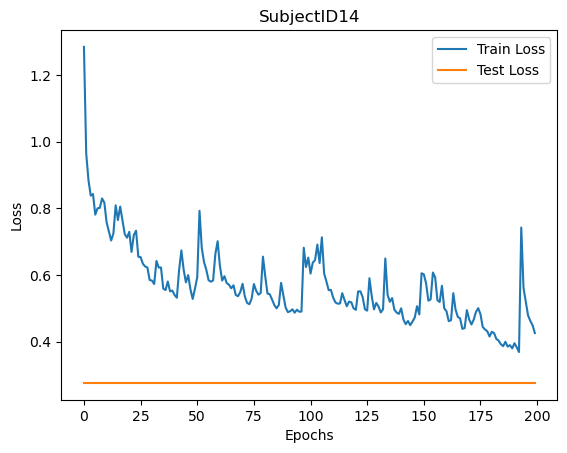

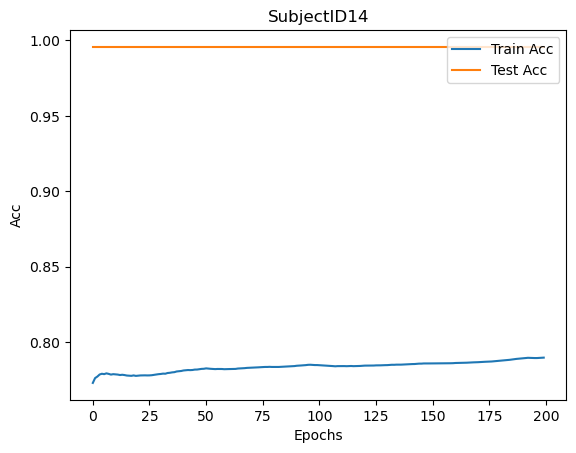


Subject 15
| epoch   0 | 0.1858 s/epoch | train loss 1.1415
| epoch   1 | 0.1857 s/epoch | train loss 0.8150
| epoch   2 | 0.1895 s/epoch | train loss 0.7731
| epoch   3 | 0.1856 s/epoch | train loss 0.7109
| epoch   4 | 0.1875 s/epoch | train loss 0.6862
| epoch   5 | 0.1886 s/epoch | train loss 0.6608
| epoch   6 | 0.1847 s/epoch | train loss 0.6365
| epoch   7 | 0.1857 s/epoch | train loss 0.6300
| epoch   8 | 0.1849 s/epoch | train loss 0.5966
| epoch   9 | 0.1861 s/epoch | train loss 0.5998
| epoch  10 | 0.1871 s/epoch | train loss 0.5651
| epoch  11 | 0.1867 s/epoch | train loss 0.5453
| epoch  12 | 0.1848 s/epoch | train loss 0.5390
| epoch  13 | 0.1878 s/epoch | train loss 0.5364
| epoch  14 | 0.1852 s/epoch | train loss 0.5351
| epoch  15 | 0.1840 s/epoch | train loss 0.5118
| epoch  16 | 0.1852 s/epoch | train loss 0.5084
| epoch  17 | 0.1846 s/epoch | train loss 0.4981
| epoch  18 | 0.1865 s/epoch | train loss 0.4816
| epoch  19 | 0.1886 s/epoch | train loss 0.5000
| epoch 

| epoch 167 | 0.1871 s/epoch | train loss 0.2205
| epoch 168 | 0.1849 s/epoch | train loss 0.2041
| epoch 169 | 0.1879 s/epoch | train loss 0.2119
| epoch 170 | 0.1866 s/epoch | train loss 0.2372
| epoch 171 | 0.1857 s/epoch | train loss 0.2427
| epoch 172 | 0.1869 s/epoch | train loss 0.2324
| epoch 173 | 0.1836 s/epoch | train loss 0.2284
| epoch 174 | 0.1852 s/epoch | train loss 0.2179
| epoch 175 | 0.1867 s/epoch | train loss 0.2118
| epoch 176 | 0.1886 s/epoch | train loss 0.2255
| epoch 177 | 0.1903 s/epoch | train loss 0.2640
| epoch 178 | 0.1847 s/epoch | train loss 0.3075
| epoch 179 | 0.1877 s/epoch | train loss 0.2488
| epoch 180 | 0.1852 s/epoch | train loss 0.2308
| epoch 181 | 0.1860 s/epoch | train loss 0.2137
| epoch 182 | 0.1883 s/epoch | train loss 0.2302
| epoch 183 | 0.1862 s/epoch | train loss 0.2179
| epoch 184 | 0.1864 s/epoch | train loss 0.2157
| epoch 185 | 0.1898 s/epoch | train loss 0.2411
| epoch 186 | 0.1868 s/epoch | train loss 0.2248
| epoch 187 | 0.1875

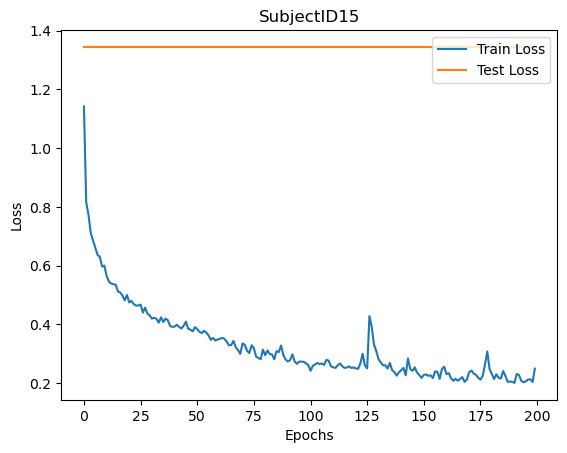

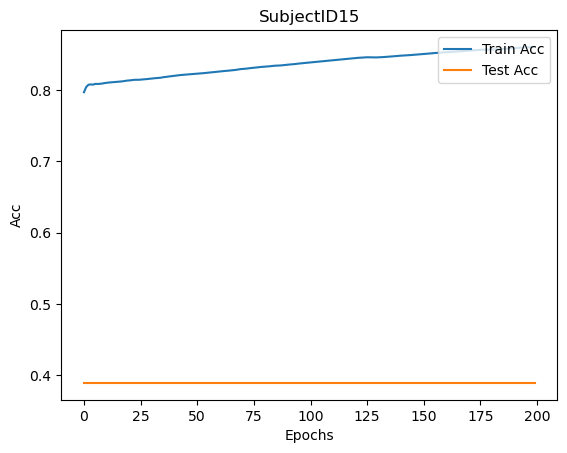

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~


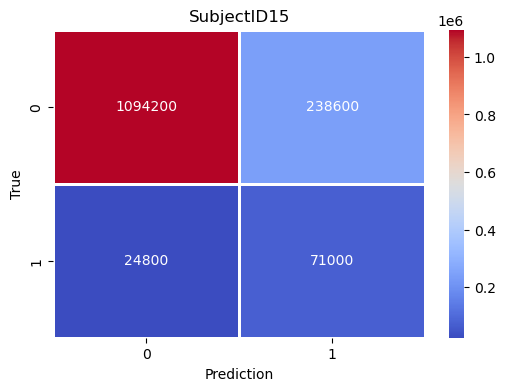

Distillation_teacher(Mobilnet)_Acc: 0.8156236875262495
Distillation_teacher(Mobilnet)_Rec: 0.7411273486430062
Distillation_teacher(Mobilnet)_Pre: 0.229328165374677
Distillation_teacher(Mobilnet)_F1: 0.35027133695115936


<Figure size 640x480 with 0 Axes>

In [18]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    model_teacher_student = MobileNetV3_Small_KD().to(device)
    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)


show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])


Subject 1
| epoch   0 | 0.0391 s/epoch | train loss 1.2553
| epoch   1 | 0.0390 s/epoch | train loss 0.8102
| epoch   2 | 0.0386 s/epoch | train loss 0.7599
| epoch   3 | 0.0396 s/epoch | train loss 0.7424
| epoch   4 | 0.0397 s/epoch | train loss 0.7240
| epoch   5 | 0.0403 s/epoch | train loss 0.7083
| epoch   6 | 0.0399 s/epoch | train loss 0.7076
| epoch   7 | 0.0406 s/epoch | train loss 0.6861
| epoch   8 | 0.0392 s/epoch | train loss 0.6903
| epoch   9 | 0.0378 s/epoch | train loss 0.6581
| epoch  10 | 0.0393 s/epoch | train loss 0.6412
| epoch  11 | 0.0398 s/epoch | train loss 0.6271
| epoch  12 | 0.0389 s/epoch | train loss 0.6113
| epoch  13 | 0.0379 s/epoch | train loss 0.6110
| epoch  14 | 0.0394 s/epoch | train loss 0.5954
| epoch  15 | 0.0396 s/epoch | train loss 0.5766
| epoch  16 | 0.0381 s/epoch | train loss 0.5856
| epoch  17 | 0.0404 s/epoch | train loss 0.5961
| epoch  18 | 0.0386 s/epoch | train loss 0.6013
| epoch  19 | 0.0387 s/epoch | train loss 0.5651
| epoch  

| epoch 167 | 0.0394 s/epoch | train loss 0.1153
| epoch 168 | 0.0391 s/epoch | train loss 0.1176
| epoch 169 | 0.0381 s/epoch | train loss 0.1313
| epoch 170 | 0.0382 s/epoch | train loss 0.1061
| epoch 171 | 0.0385 s/epoch | train loss 0.1007
| epoch 172 | 0.0397 s/epoch | train loss 0.0980
| epoch 173 | 0.0394 s/epoch | train loss 0.0966
| epoch 174 | 0.0391 s/epoch | train loss 0.0972
| epoch 175 | 0.0401 s/epoch | train loss 0.0991
| epoch 176 | 0.0387 s/epoch | train loss 0.1003
| epoch 177 | 0.0390 s/epoch | train loss 0.1035
| epoch 178 | 0.0388 s/epoch | train loss 0.1340
| epoch 179 | 0.0384 s/epoch | train loss 0.1474
| epoch 180 | 0.0399 s/epoch | train loss 0.1372
| epoch 181 | 0.0379 s/epoch | train loss 0.1380
| epoch 182 | 0.0399 s/epoch | train loss 0.1387
| epoch 183 | 0.0399 s/epoch | train loss 0.1192
| epoch 184 | 0.0396 s/epoch | train loss 0.1083
| epoch 185 | 0.0394 s/epoch | train loss 0.0992
| epoch 186 | 0.0410 s/epoch | train loss 0.0976
| epoch 187 | 0.0387

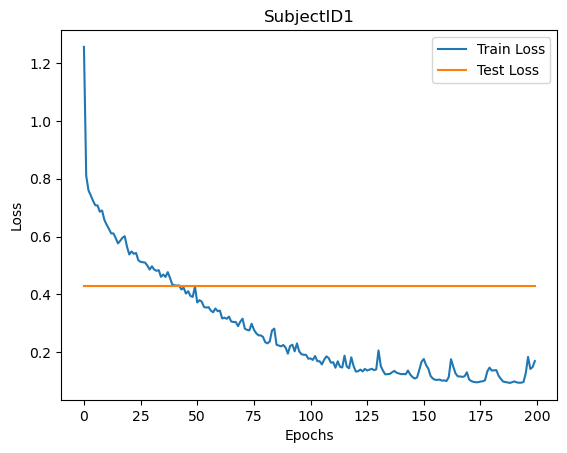

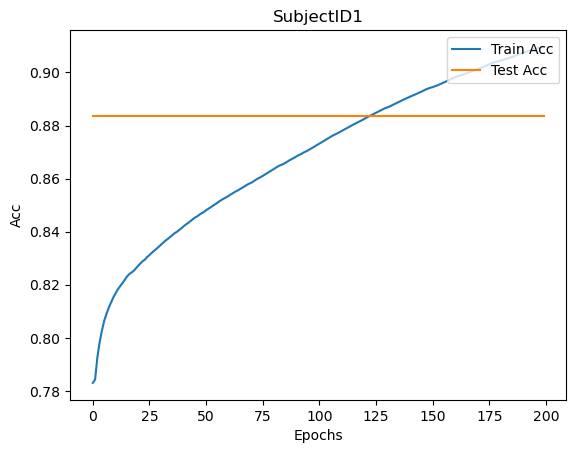


Subject 2
| epoch   0 | 0.0382 s/epoch | train loss 1.3822
| epoch   1 | 0.0367 s/epoch | train loss 0.7557
| epoch   2 | 0.0377 s/epoch | train loss 0.7161
| epoch   3 | 0.0376 s/epoch | train loss 0.7003
| epoch   4 | 0.0375 s/epoch | train loss 0.6831
| epoch   5 | 0.0392 s/epoch | train loss 0.6851
| epoch   6 | 0.0398 s/epoch | train loss 0.6667
| epoch   7 | 0.0391 s/epoch | train loss 0.6441
| epoch   8 | 0.0377 s/epoch | train loss 0.6464
| epoch   9 | 0.0378 s/epoch | train loss 0.6255
| epoch  10 | 0.0383 s/epoch | train loss 0.6147
| epoch  11 | 0.0391 s/epoch | train loss 0.6080
| epoch  12 | 0.0378 s/epoch | train loss 0.5945
| epoch  13 | 0.0393 s/epoch | train loss 0.5816
| epoch  14 | 0.0374 s/epoch | train loss 0.5835
| epoch  15 | 0.0392 s/epoch | train loss 0.6015
| epoch  16 | 0.0388 s/epoch | train loss 0.5572
| epoch  17 | 0.0385 s/epoch | train loss 0.5485
| epoch  18 | 0.0385 s/epoch | train loss 0.5502
| epoch  19 | 0.0383 s/epoch | train loss 0.5587
| epoch  

| epoch 167 | 0.0380 s/epoch | train loss 0.1051
| epoch 168 | 0.0382 s/epoch | train loss 0.1008
| epoch 169 | 0.0401 s/epoch | train loss 0.1006
| epoch 170 | 0.0382 s/epoch | train loss 0.1006
| epoch 171 | 0.0397 s/epoch | train loss 0.0989
| epoch 172 | 0.0384 s/epoch | train loss 0.1023
| epoch 173 | 0.0376 s/epoch | train loss 0.0969
| epoch 174 | 0.0376 s/epoch | train loss 0.1007
| epoch 175 | 0.0369 s/epoch | train loss 0.0984
| epoch 176 | 0.0384 s/epoch | train loss 0.1103
| epoch 177 | 0.0382 s/epoch | train loss 0.2060
| epoch 178 | 0.0374 s/epoch | train loss 0.1498
| epoch 179 | 0.0366 s/epoch | train loss 0.1504
| epoch 180 | 0.0392 s/epoch | train loss 0.1186
| epoch 181 | 0.0375 s/epoch | train loss 0.1101
| epoch 182 | 0.0374 s/epoch | train loss 0.1033
| epoch 183 | 0.0370 s/epoch | train loss 0.1044
| epoch 184 | 0.0395 s/epoch | train loss 0.1310
| epoch 185 | 0.0390 s/epoch | train loss 0.1397
| epoch 186 | 0.0381 s/epoch | train loss 0.1188
| epoch 187 | 0.0377

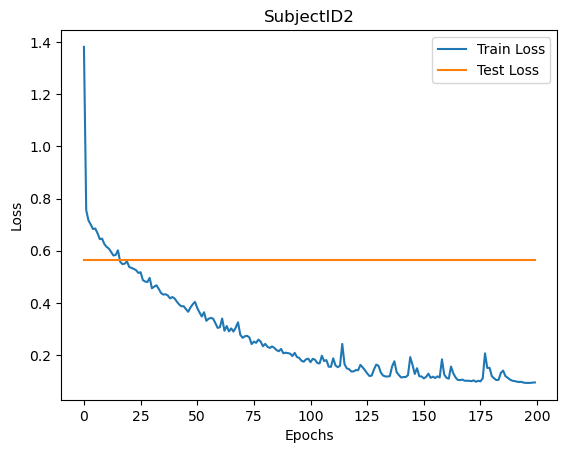

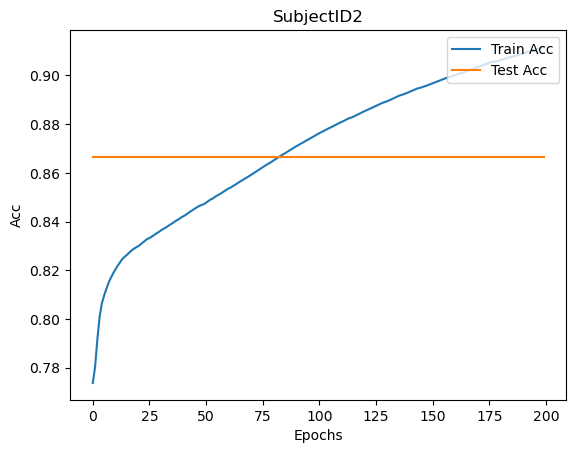


Subject 3
| epoch   0 | 0.0378 s/epoch | train loss 1.3208
| epoch   1 | 0.0379 s/epoch | train loss 0.7544
| epoch   2 | 0.0373 s/epoch | train loss 0.7159
| epoch   3 | 0.0378 s/epoch | train loss 0.6988
| epoch   4 | 0.0369 s/epoch | train loss 0.6861
| epoch   5 | 0.0372 s/epoch | train loss 0.6783
| epoch   6 | 0.0385 s/epoch | train loss 0.6597
| epoch   7 | 0.0371 s/epoch | train loss 0.6571
| epoch   8 | 0.0383 s/epoch | train loss 0.6419
| epoch   9 | 0.0368 s/epoch | train loss 0.6237
| epoch  10 | 0.0384 s/epoch | train loss 0.6218
| epoch  11 | 0.0384 s/epoch | train loss 0.6146
| epoch  12 | 0.0386 s/epoch | train loss 0.6014
| epoch  13 | 0.0384 s/epoch | train loss 0.6011
| epoch  14 | 0.0372 s/epoch | train loss 0.5913
| epoch  15 | 0.0383 s/epoch | train loss 0.5804
| epoch  16 | 0.0388 s/epoch | train loss 0.5605
| epoch  17 | 0.0375 s/epoch | train loss 0.5612
| epoch  18 | 0.0393 s/epoch | train loss 0.5493
| epoch  19 | 0.0386 s/epoch | train loss 0.5489
| epoch  

| epoch 167 | 0.0370 s/epoch | train loss 0.1302
| epoch 168 | 0.0378 s/epoch | train loss 0.1410
| epoch 169 | 0.0380 s/epoch | train loss 0.1510
| epoch 170 | 0.0369 s/epoch | train loss 0.1163
| epoch 171 | 0.0374 s/epoch | train loss 0.1007
| epoch 172 | 0.0371 s/epoch | train loss 0.1036
| epoch 173 | 0.0377 s/epoch | train loss 0.1104
| epoch 174 | 0.0377 s/epoch | train loss 0.1004
| epoch 175 | 0.0356 s/epoch | train loss 0.1066
| epoch 176 | 0.0363 s/epoch | train loss 0.1120
| epoch 177 | 0.0371 s/epoch | train loss 0.1053
| epoch 178 | 0.0371 s/epoch | train loss 0.1103
| epoch 179 | 0.0379 s/epoch | train loss 0.1515
| epoch 180 | 0.0366 s/epoch | train loss 0.1129
| epoch 181 | 0.0376 s/epoch | train loss 0.1046
| epoch 182 | 0.0380 s/epoch | train loss 0.0965
| epoch 183 | 0.0366 s/epoch | train loss 0.0955
| epoch 184 | 0.0378 s/epoch | train loss 0.0935
| epoch 185 | 0.0377 s/epoch | train loss 0.0932
| epoch 186 | 0.0383 s/epoch | train loss 0.0938
| epoch 187 | 0.0344

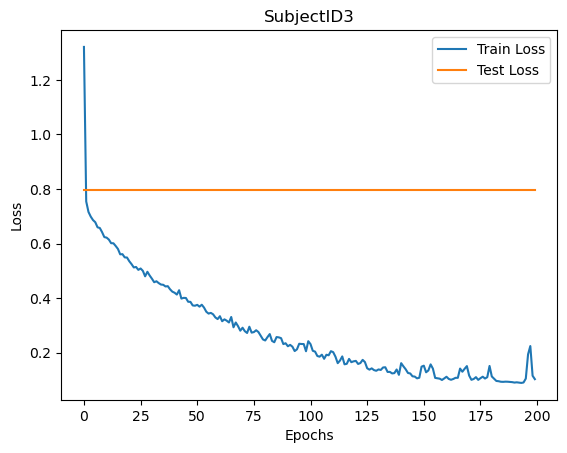

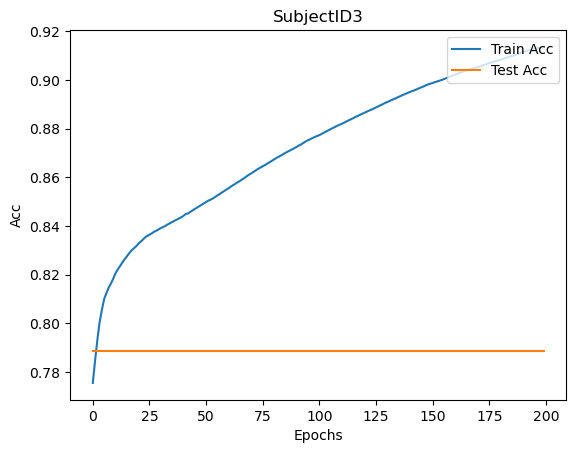


Subject 4
| epoch   0 | 0.0386 s/epoch | train loss 1.3554
| epoch   1 | 0.0390 s/epoch | train loss 0.7848
| epoch   2 | 0.0393 s/epoch | train loss 0.7612
| epoch   3 | 0.0409 s/epoch | train loss 0.7214
| epoch   4 | 0.0393 s/epoch | train loss 0.7117
| epoch   5 | 0.0388 s/epoch | train loss 0.7070
| epoch   6 | 0.0397 s/epoch | train loss 0.6906
| epoch   7 | 0.0396 s/epoch | train loss 0.6740
| epoch   8 | 0.0382 s/epoch | train loss 0.6762
| epoch   9 | 0.0395 s/epoch | train loss 0.6583
| epoch  10 | 0.0393 s/epoch | train loss 0.6451
| epoch  11 | 0.0385 s/epoch | train loss 0.6377
| epoch  12 | 0.0393 s/epoch | train loss 0.6237
| epoch  13 | 0.0410 s/epoch | train loss 0.6199
| epoch  14 | 0.0403 s/epoch | train loss 0.6118
| epoch  15 | 0.0389 s/epoch | train loss 0.6023
| epoch  16 | 0.0406 s/epoch | train loss 0.6059
| epoch  17 | 0.0390 s/epoch | train loss 0.5894
| epoch  18 | 0.0405 s/epoch | train loss 0.5673
| epoch  19 | 0.0385 s/epoch | train loss 0.5763
| epoch  

| epoch 167 | 0.0404 s/epoch | train loss 0.1175
| epoch 168 | 0.0399 s/epoch | train loss 0.1064
| epoch 169 | 0.0395 s/epoch | train loss 0.0985
| epoch 170 | 0.0393 s/epoch | train loss 0.0977
| epoch 171 | 0.0392 s/epoch | train loss 0.0949
| epoch 172 | 0.0400 s/epoch | train loss 0.0946
| epoch 173 | 0.0390 s/epoch | train loss 0.0938
| epoch 174 | 0.0411 s/epoch | train loss 0.0949
| epoch 175 | 0.0393 s/epoch | train loss 0.0965
| epoch 176 | 0.0399 s/epoch | train loss 0.0958
| epoch 177 | 0.0403 s/epoch | train loss 0.0964
| epoch 178 | 0.0407 s/epoch | train loss 0.0957
| epoch 179 | 0.0411 s/epoch | train loss 0.1014
| epoch 180 | 0.0404 s/epoch | train loss 0.1201
| epoch 181 | 0.0393 s/epoch | train loss 0.1328
| epoch 182 | 0.0396 s/epoch | train loss 0.1735
| epoch 183 | 0.0405 s/epoch | train loss 0.1430
| epoch 184 | 0.0394 s/epoch | train loss 0.1354
| epoch 185 | 0.0395 s/epoch | train loss 0.1530
| epoch 186 | 0.0414 s/epoch | train loss 0.1180
| epoch 187 | 0.0403

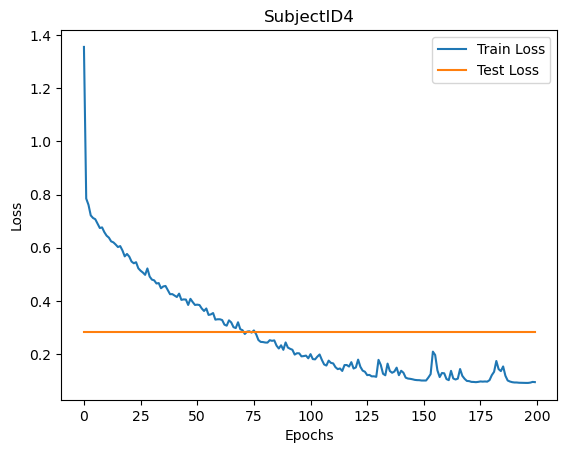

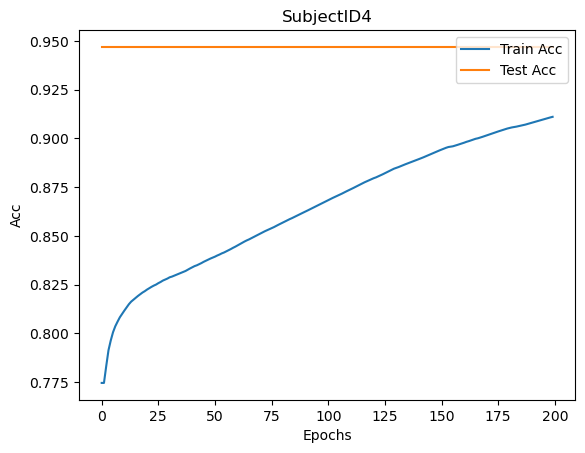


Subject 5
| epoch   0 | 0.0380 s/epoch | train loss 1.3746
| epoch   1 | 0.0383 s/epoch | train loss 0.7665
| epoch   2 | 0.0379 s/epoch | train loss 0.7353
| epoch   3 | 0.0379 s/epoch | train loss 0.7139
| epoch   4 | 0.0371 s/epoch | train loss 0.7080
| epoch   5 | 0.0381 s/epoch | train loss 0.6884
| epoch   6 | 0.0376 s/epoch | train loss 0.6803
| epoch   7 | 0.0382 s/epoch | train loss 0.6723
| epoch   8 | 0.0389 s/epoch | train loss 0.6553
| epoch   9 | 0.0387 s/epoch | train loss 0.6574
| epoch  10 | 0.0384 s/epoch | train loss 0.6507
| epoch  11 | 0.0372 s/epoch | train loss 0.6433
| epoch  12 | 0.0371 s/epoch | train loss 0.6400
| epoch  13 | 0.0397 s/epoch | train loss 0.6228
| epoch  14 | 0.0391 s/epoch | train loss 0.6139
| epoch  15 | 0.0380 s/epoch | train loss 0.6060
| epoch  16 | 0.0374 s/epoch | train loss 0.6037
| epoch  17 | 0.0375 s/epoch | train loss 0.5728
| epoch  18 | 0.0382 s/epoch | train loss 0.5739
| epoch  19 | 0.0386 s/epoch | train loss 0.5597
| epoch  

| epoch 167 | 0.0368 s/epoch | train loss 0.1421
| epoch 168 | 0.0378 s/epoch | train loss 0.1447
| epoch 169 | 0.0381 s/epoch | train loss 0.1334
| epoch 170 | 0.0385 s/epoch | train loss 0.1241
| epoch 171 | 0.0392 s/epoch | train loss 0.1108
| epoch 172 | 0.0385 s/epoch | train loss 0.1107
| epoch 173 | 0.0366 s/epoch | train loss 0.1105
| epoch 174 | 0.0390 s/epoch | train loss 0.1092
| epoch 175 | 0.0375 s/epoch | train loss 0.1070
| epoch 176 | 0.0396 s/epoch | train loss 0.1104
| epoch 177 | 0.0368 s/epoch | train loss 0.1066
| epoch 178 | 0.0381 s/epoch | train loss 0.1083
| epoch 179 | 0.0369 s/epoch | train loss 0.1140
| epoch 180 | 0.0365 s/epoch | train loss 0.1338
| epoch 181 | 0.0385 s/epoch | train loss 0.1691
| epoch 182 | 0.0388 s/epoch | train loss 0.1393
| epoch 183 | 0.0383 s/epoch | train loss 0.1160
| epoch 184 | 0.0378 s/epoch | train loss 0.1350
| epoch 185 | 0.0377 s/epoch | train loss 0.1212
| epoch 186 | 0.0383 s/epoch | train loss 0.1127
| epoch 187 | 0.0383

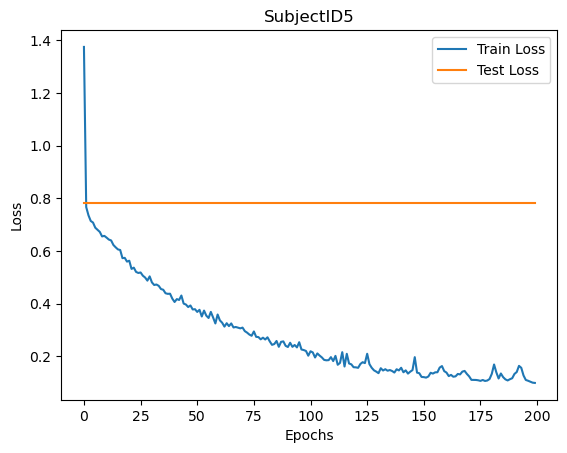

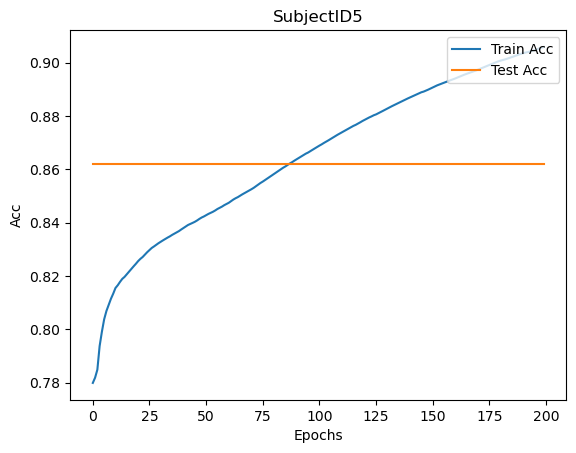


Subject 7
| epoch   0 | 0.0367 s/epoch | train loss 1.2296
| epoch   1 | 0.0365 s/epoch | train loss 0.7207
| epoch   2 | 0.0369 s/epoch | train loss 0.6797
| epoch   3 | 0.0363 s/epoch | train loss 0.6558
| epoch   4 | 0.0375 s/epoch | train loss 0.6536
| epoch   5 | 0.0376 s/epoch | train loss 0.6349
| epoch   6 | 0.0362 s/epoch | train loss 0.6250
| epoch   7 | 0.0376 s/epoch | train loss 0.6097
| epoch   8 | 0.0380 s/epoch | train loss 0.6008
| epoch   9 | 0.0382 s/epoch | train loss 0.5975
| epoch  10 | 0.0383 s/epoch | train loss 0.5715
| epoch  11 | 0.0366 s/epoch | train loss 0.5739
| epoch  12 | 0.0377 s/epoch | train loss 0.5497
| epoch  13 | 0.0372 s/epoch | train loss 0.5510
| epoch  14 | 0.0373 s/epoch | train loss 0.5543
| epoch  15 | 0.0381 s/epoch | train loss 0.5568
| epoch  16 | 0.0372 s/epoch | train loss 0.5164
| epoch  17 | 0.0370 s/epoch | train loss 0.5101
| epoch  18 | 0.0385 s/epoch | train loss 0.5154
| epoch  19 | 0.0372 s/epoch | train loss 0.5227
| epoch  

| epoch 167 | 0.0363 s/epoch | train loss 0.0911
| epoch 168 | 0.0377 s/epoch | train loss 0.0903
| epoch 169 | 0.0372 s/epoch | train loss 0.1024
| epoch 170 | 0.0369 s/epoch | train loss 0.1594
| epoch 171 | 0.0361 s/epoch | train loss 0.1720
| epoch 172 | 0.0370 s/epoch | train loss 0.1088
| epoch 173 | 0.0376 s/epoch | train loss 0.1033
| epoch 174 | 0.0359 s/epoch | train loss 0.1128
| epoch 175 | 0.0371 s/epoch | train loss 0.1367
| epoch 176 | 0.0381 s/epoch | train loss 0.1026
| epoch 177 | 0.0372 s/epoch | train loss 0.0958
| epoch 178 | 0.0374 s/epoch | train loss 0.0959
| epoch 179 | 0.0370 s/epoch | train loss 0.0908
| epoch 180 | 0.0378 s/epoch | train loss 0.0905
| epoch 181 | 0.0369 s/epoch | train loss 0.0891
| epoch 182 | 0.0370 s/epoch | train loss 0.0888
| epoch 183 | 0.0371 s/epoch | train loss 0.0878
| epoch 184 | 0.0366 s/epoch | train loss 0.0889
| epoch 185 | 0.0375 s/epoch | train loss 0.0878
| epoch 186 | 0.0371 s/epoch | train loss 0.1015
| epoch 187 | 0.0363

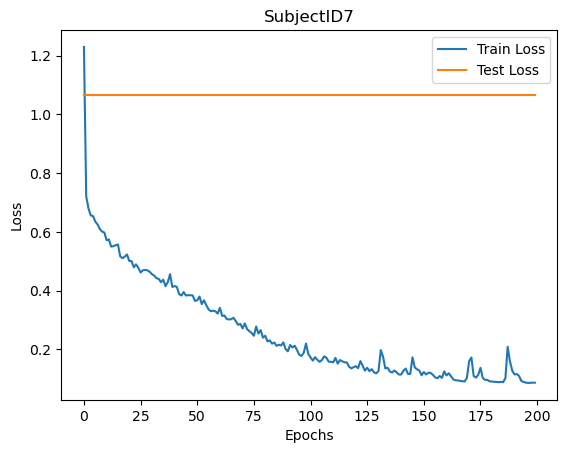

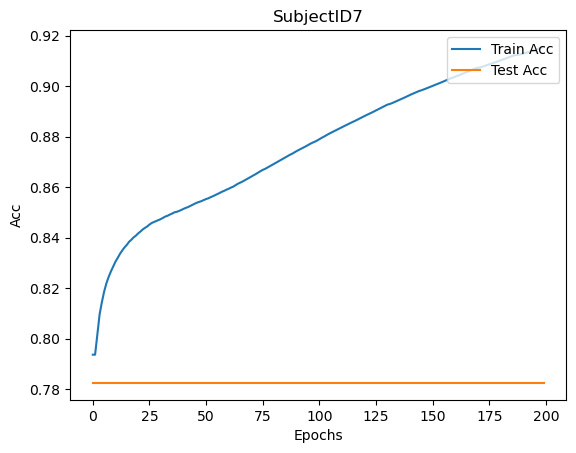


Subject 8
| epoch   0 | 0.0382 s/epoch | train loss 1.2934
| epoch   1 | 0.0393 s/epoch | train loss 0.7717
| epoch   2 | 0.0384 s/epoch | train loss 0.7358
| epoch   3 | 0.0402 s/epoch | train loss 0.7217
| epoch   4 | 0.0389 s/epoch | train loss 0.6933
| epoch   5 | 0.0397 s/epoch | train loss 0.6666
| epoch   6 | 0.0387 s/epoch | train loss 0.6604
| epoch   7 | 0.0378 s/epoch | train loss 0.6471
| epoch   8 | 0.0385 s/epoch | train loss 0.6259
| epoch   9 | 0.0384 s/epoch | train loss 0.6122
| epoch  10 | 0.0409 s/epoch | train loss 0.5917
| epoch  11 | 0.0395 s/epoch | train loss 0.5911
| epoch  12 | 0.0394 s/epoch | train loss 0.5763
| epoch  13 | 0.0383 s/epoch | train loss 0.5773
| epoch  14 | 0.0388 s/epoch | train loss 0.5543
| epoch  15 | 0.0387 s/epoch | train loss 0.5376
| epoch  16 | 0.0394 s/epoch | train loss 0.5312
| epoch  17 | 0.0402 s/epoch | train loss 0.5367
| epoch  18 | 0.0399 s/epoch | train loss 0.5261
| epoch  19 | 0.0388 s/epoch | train loss 0.5159
| epoch  

| epoch 167 | 0.0376 s/epoch | train loss 0.1664
| epoch 168 | 0.0393 s/epoch | train loss 0.1219
| epoch 169 | 0.0391 s/epoch | train loss 0.1263
| epoch 170 | 0.0371 s/epoch | train loss 0.1027
| epoch 171 | 0.0388 s/epoch | train loss 0.0983
| epoch 172 | 0.0400 s/epoch | train loss 0.0969
| epoch 173 | 0.0391 s/epoch | train loss 0.1027
| epoch 174 | 0.0395 s/epoch | train loss 0.1003
| epoch 175 | 0.0401 s/epoch | train loss 0.0963
| epoch 176 | 0.0389 s/epoch | train loss 0.0951
| epoch 177 | 0.0395 s/epoch | train loss 0.0959
| epoch 178 | 0.0405 s/epoch | train loss 0.0934
| epoch 179 | 0.0387 s/epoch | train loss 0.0975
| epoch 180 | 0.0397 s/epoch | train loss 0.0948
| epoch 181 | 0.0380 s/epoch | train loss 0.1049
| epoch 182 | 0.0385 s/epoch | train loss 0.1110
| epoch 183 | 0.0381 s/epoch | train loss 0.1400
| epoch 184 | 0.0386 s/epoch | train loss 0.1777
| epoch 185 | 0.0387 s/epoch | train loss 0.1192
| epoch 186 | 0.0403 s/epoch | train loss 0.1020
| epoch 187 | 0.0398

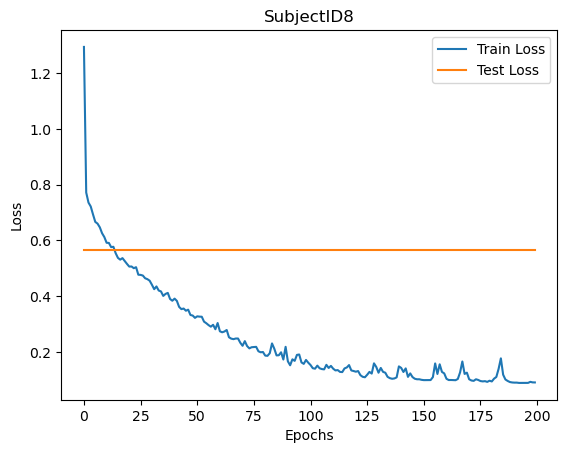

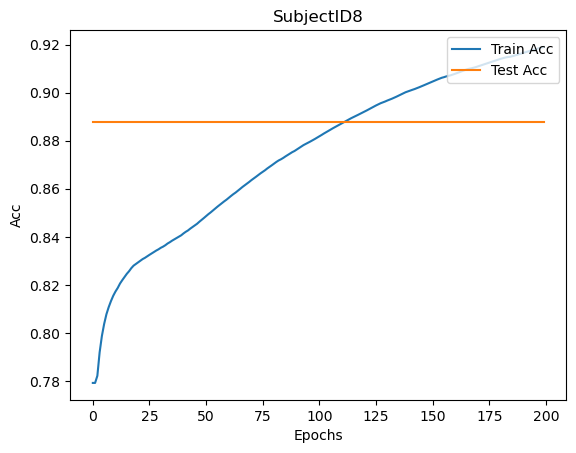


Subject 9
| epoch   0 | 0.0375 s/epoch | train loss 1.3575
| epoch   1 | 0.0401 s/epoch | train loss 0.7916
| epoch   2 | 0.0373 s/epoch | train loss 0.7621
| epoch   3 | 0.0389 s/epoch | train loss 0.7412
| epoch   4 | 0.0376 s/epoch | train loss 0.7310
| epoch   5 | 0.0374 s/epoch | train loss 0.7197
| epoch   6 | 0.0370 s/epoch | train loss 0.7100
| epoch   7 | 0.0368 s/epoch | train loss 0.6918
| epoch   8 | 0.0381 s/epoch | train loss 0.6814
| epoch   9 | 0.0396 s/epoch | train loss 0.6972
| epoch  10 | 0.0380 s/epoch | train loss 0.6741
| epoch  11 | 0.0390 s/epoch | train loss 0.6447
| epoch  12 | 0.0388 s/epoch | train loss 0.6273
| epoch  13 | 0.0390 s/epoch | train loss 0.6185
| epoch  14 | 0.0392 s/epoch | train loss 0.6166
| epoch  15 | 0.0390 s/epoch | train loss 0.5986
| epoch  16 | 0.0372 s/epoch | train loss 0.5939
| epoch  17 | 0.0383 s/epoch | train loss 0.5891
| epoch  18 | 0.0382 s/epoch | train loss 0.5763
| epoch  19 | 0.0371 s/epoch | train loss 0.5696
| epoch  

| epoch 167 | 0.0391 s/epoch | train loss 0.1366
| epoch 168 | 0.0385 s/epoch | train loss 0.1462
| epoch 169 | 0.0389 s/epoch | train loss 0.1202
| epoch 170 | 0.0372 s/epoch | train loss 0.1090
| epoch 171 | 0.0369 s/epoch | train loss 0.1102
| epoch 172 | 0.0391 s/epoch | train loss 0.1086
| epoch 173 | 0.0381 s/epoch | train loss 0.1270
| epoch 174 | 0.0392 s/epoch | train loss 0.1072
| epoch 175 | 0.0388 s/epoch | train loss 0.1040
| epoch 176 | 0.0391 s/epoch | train loss 0.1054
| epoch 177 | 0.0374 s/epoch | train loss 0.1023
| epoch 178 | 0.0382 s/epoch | train loss 0.1027
| epoch 179 | 0.0373 s/epoch | train loss 0.1041
| epoch 180 | 0.0395 s/epoch | train loss 0.1039
| epoch 181 | 0.0382 s/epoch | train loss 0.1062
| epoch 182 | 0.0379 s/epoch | train loss 0.1479
| epoch 183 | 0.0381 s/epoch | train loss 0.1352
| epoch 184 | 0.0384 s/epoch | train loss 0.1436
| epoch 185 | 0.0376 s/epoch | train loss 0.1708
| epoch 186 | 0.0381 s/epoch | train loss 0.1162
| epoch 187 | 0.0383

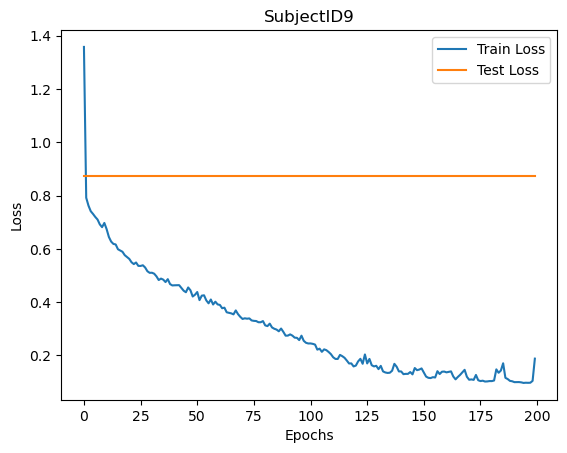

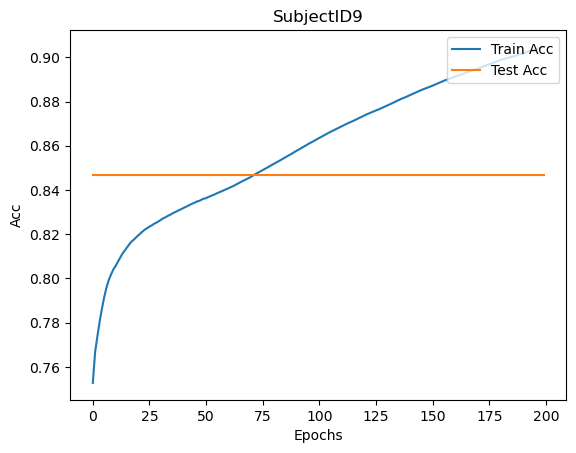


Subject 10
| epoch   0 | 0.0387 s/epoch | train loss 1.2713
| epoch   1 | 0.0391 s/epoch | train loss 0.7981
| epoch   2 | 0.0401 s/epoch | train loss 0.7559
| epoch   3 | 0.0391 s/epoch | train loss 0.7425
| epoch   4 | 0.0393 s/epoch | train loss 0.7188
| epoch   5 | 0.0400 s/epoch | train loss 0.7038
| epoch   6 | 0.0392 s/epoch | train loss 0.6890
| epoch   7 | 0.0400 s/epoch | train loss 0.6998
| epoch   8 | 0.0398 s/epoch | train loss 0.6644
| epoch   9 | 0.0407 s/epoch | train loss 0.6542
| epoch  10 | 0.0393 s/epoch | train loss 0.6523
| epoch  11 | 0.0386 s/epoch | train loss 0.6236
| epoch  12 | 0.0405 s/epoch | train loss 0.6174
| epoch  13 | 0.0399 s/epoch | train loss 0.6138
| epoch  14 | 0.0398 s/epoch | train loss 0.5944
| epoch  15 | 0.0395 s/epoch | train loss 0.5817
| epoch  16 | 0.0402 s/epoch | train loss 0.5647
| epoch  17 | 0.0398 s/epoch | train loss 0.5550
| epoch  18 | 0.0401 s/epoch | train loss 0.5545
| epoch  19 | 0.0394 s/epoch | train loss 0.5549
| epoch 

| epoch 167 | 0.0405 s/epoch | train loss 0.1184
| epoch 168 | 0.0401 s/epoch | train loss 0.1078
| epoch 169 | 0.0397 s/epoch | train loss 0.1001
| epoch 170 | 0.0415 s/epoch | train loss 0.0976
| epoch 171 | 0.0398 s/epoch | train loss 0.0954
| epoch 172 | 0.0399 s/epoch | train loss 0.0958
| epoch 173 | 0.0395 s/epoch | train loss 0.0963
| epoch 174 | 0.0398 s/epoch | train loss 0.0993
| epoch 175 | 0.0402 s/epoch | train loss 0.0989
| epoch 176 | 0.0405 s/epoch | train loss 0.0964
| epoch 177 | 0.0380 s/epoch | train loss 0.0963
| epoch 178 | 0.0392 s/epoch | train loss 0.1029
| epoch 179 | 0.0405 s/epoch | train loss 0.1078
| epoch 180 | 0.0391 s/epoch | train loss 0.1591
| epoch 181 | 0.0390 s/epoch | train loss 0.1992
| epoch 182 | 0.0405 s/epoch | train loss 0.1538
| epoch 183 | 0.0376 s/epoch | train loss 0.1091
| epoch 184 | 0.0398 s/epoch | train loss 0.1013
| epoch 185 | 0.0400 s/epoch | train loss 0.0977
| epoch 186 | 0.0392 s/epoch | train loss 0.0953
| epoch 187 | 0.0382

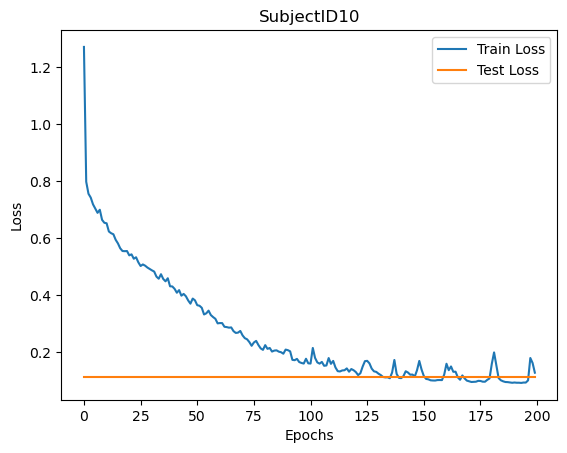

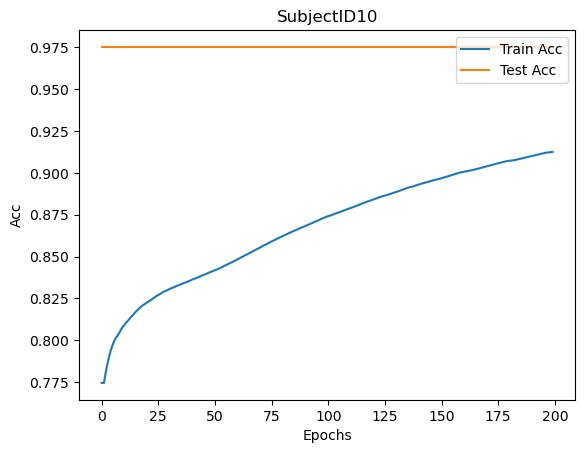


Subject 11
| epoch   0 | 0.0390 s/epoch | train loss 1.2727
| epoch   1 | 0.0390 s/epoch | train loss 0.7825
| epoch   2 | 0.0379 s/epoch | train loss 0.7417
| epoch   3 | 0.0393 s/epoch | train loss 0.7246
| epoch   4 | 0.0392 s/epoch | train loss 0.7154
| epoch   5 | 0.0401 s/epoch | train loss 0.6979
| epoch   6 | 0.0384 s/epoch | train loss 0.6976
| epoch   7 | 0.0391 s/epoch | train loss 0.6744
| epoch   8 | 0.0373 s/epoch | train loss 0.6612
| epoch   9 | 0.0393 s/epoch | train loss 0.6484
| epoch  10 | 0.0392 s/epoch | train loss 0.6184
| epoch  11 | 0.0376 s/epoch | train loss 0.6302
| epoch  12 | 0.0390 s/epoch | train loss 0.6103
| epoch  13 | 0.0390 s/epoch | train loss 0.6010
| epoch  14 | 0.0383 s/epoch | train loss 0.5829
| epoch  15 | 0.0402 s/epoch | train loss 0.5777
| epoch  16 | 0.0392 s/epoch | train loss 0.5832
| epoch  17 | 0.0393 s/epoch | train loss 0.5549
| epoch  18 | 0.0386 s/epoch | train loss 0.5607
| epoch  19 | 0.0389 s/epoch | train loss 0.5482
| epoch 

| epoch 167 | 0.0396 s/epoch | train loss 0.1190
| epoch 168 | 0.0403 s/epoch | train loss 0.1354
| epoch 169 | 0.0389 s/epoch | train loss 0.1348
| epoch 170 | 0.0395 s/epoch | train loss 0.1523
| epoch 171 | 0.0398 s/epoch | train loss 0.1230
| epoch 172 | 0.0389 s/epoch | train loss 0.1204
| epoch 173 | 0.0399 s/epoch | train loss 0.1047
| epoch 174 | 0.0388 s/epoch | train loss 0.1035
| epoch 175 | 0.0393 s/epoch | train loss 0.1016
| epoch 176 | 0.0385 s/epoch | train loss 0.1024
| epoch 177 | 0.0394 s/epoch | train loss 0.0998
| epoch 178 | 0.0385 s/epoch | train loss 0.0984
| epoch 179 | 0.0393 s/epoch | train loss 0.0978
| epoch 180 | 0.0383 s/epoch | train loss 0.0971
| epoch 181 | 0.0390 s/epoch | train loss 0.0965
| epoch 182 | 0.0392 s/epoch | train loss 0.0962
| epoch 183 | 0.0398 s/epoch | train loss 0.0975
| epoch 184 | 0.0396 s/epoch | train loss 0.1135
| epoch 185 | 0.0400 s/epoch | train loss 0.1825
| epoch 186 | 0.0395 s/epoch | train loss 0.1716
| epoch 187 | 0.0381

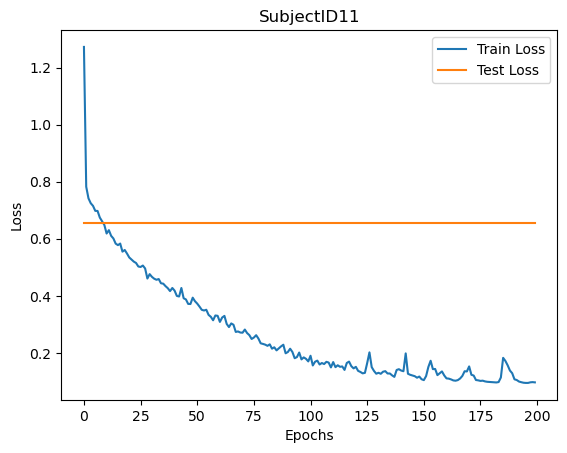

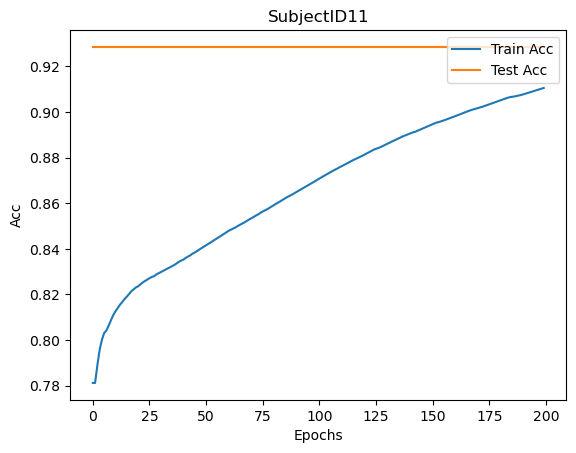


Subject 12
| epoch   0 | 0.0368 s/epoch | train loss 1.2357
| epoch   1 | 0.0369 s/epoch | train loss 0.7685
| epoch   2 | 0.0359 s/epoch | train loss 0.7324
| epoch   3 | 0.0376 s/epoch | train loss 0.7183
| epoch   4 | 0.0374 s/epoch | train loss 0.6863
| epoch   5 | 0.0367 s/epoch | train loss 0.6727
| epoch   6 | 0.0374 s/epoch | train loss 0.6711
| epoch   7 | 0.0373 s/epoch | train loss 0.6613
| epoch   8 | 0.0372 s/epoch | train loss 0.6718
| epoch   9 | 0.0382 s/epoch | train loss 0.6422
| epoch  10 | 0.0385 s/epoch | train loss 0.6253
| epoch  11 | 0.0381 s/epoch | train loss 0.6212
| epoch  12 | 0.0378 s/epoch | train loss 0.6136
| epoch  13 | 0.0371 s/epoch | train loss 0.6070
| epoch  14 | 0.0362 s/epoch | train loss 0.5933
| epoch  15 | 0.0373 s/epoch | train loss 0.5850
| epoch  16 | 0.0380 s/epoch | train loss 0.5785
| epoch  17 | 0.0394 s/epoch | train loss 0.5469
| epoch  18 | 0.0367 s/epoch | train loss 0.5585
| epoch  19 | 0.0367 s/epoch | train loss 0.5521
| epoch 

| epoch 167 | 0.0394 s/epoch | train loss 0.0935
| epoch 168 | 0.0376 s/epoch | train loss 0.0996
| epoch 169 | 0.0370 s/epoch | train loss 0.1121
| epoch 170 | 0.0373 s/epoch | train loss 0.1712
| epoch 171 | 0.0375 s/epoch | train loss 0.1488
| epoch 172 | 0.0372 s/epoch | train loss 0.1250
| epoch 173 | 0.0366 s/epoch | train loss 0.1097
| epoch 174 | 0.0383 s/epoch | train loss 0.0966
| epoch 175 | 0.0371 s/epoch | train loss 0.0947
| epoch 176 | 0.0380 s/epoch | train loss 0.0925
| epoch 177 | 0.0366 s/epoch | train loss 0.0907
| epoch 178 | 0.0383 s/epoch | train loss 0.0923
| epoch 179 | 0.0376 s/epoch | train loss 0.0899
| epoch 180 | 0.0370 s/epoch | train loss 0.0892
| epoch 181 | 0.0380 s/epoch | train loss 0.0898
| epoch 182 | 0.0366 s/epoch | train loss 0.0892
| epoch 183 | 0.0374 s/epoch | train loss 0.0901
| epoch 184 | 0.0376 s/epoch | train loss 0.0906
| epoch 185 | 0.0377 s/epoch | train loss 0.0897
| epoch 186 | 0.0372 s/epoch | train loss 0.0941
| epoch 187 | 0.0375

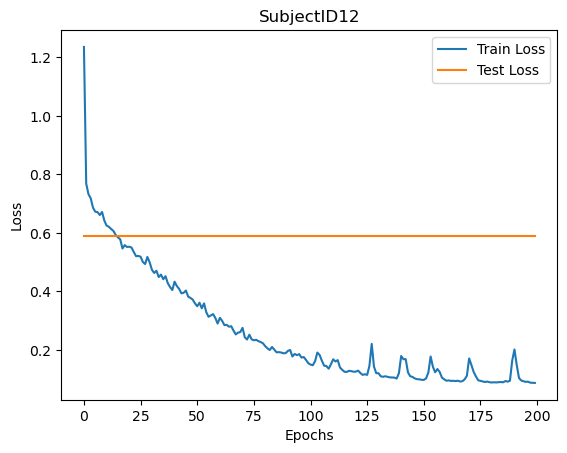

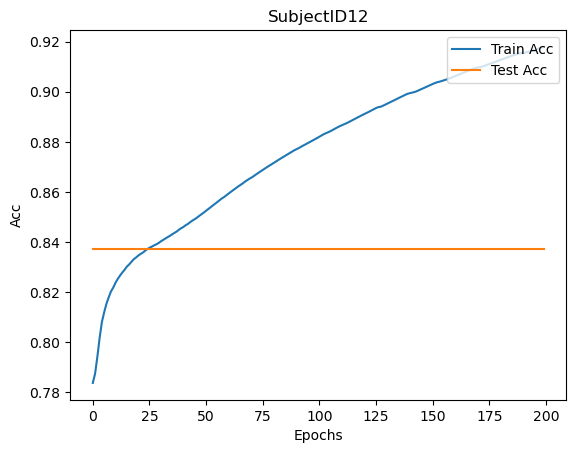


Subject 13
| epoch   0 | 0.0382 s/epoch | train loss 1.3432
| epoch   1 | 0.0370 s/epoch | train loss 0.7443
| epoch   2 | 0.0380 s/epoch | train loss 0.7157
| epoch   3 | 0.0372 s/epoch | train loss 0.6915
| epoch   4 | 0.0368 s/epoch | train loss 0.6778
| epoch   5 | 0.0379 s/epoch | train loss 0.6679
| epoch   6 | 0.0382 s/epoch | train loss 0.6614
| epoch   7 | 0.0364 s/epoch | train loss 0.6517
| epoch   8 | 0.0369 s/epoch | train loss 0.6299
| epoch   9 | 0.0370 s/epoch | train loss 0.6393
| epoch  10 | 0.0374 s/epoch | train loss 0.6327
| epoch  11 | 0.0374 s/epoch | train loss 0.6255
| epoch  12 | 0.0376 s/epoch | train loss 0.6155
| epoch  13 | 0.0385 s/epoch | train loss 0.6269
| epoch  14 | 0.0382 s/epoch | train loss 0.5979
| epoch  15 | 0.0364 s/epoch | train loss 0.5938
| epoch  16 | 0.0372 s/epoch | train loss 0.5820
| epoch  17 | 0.0371 s/epoch | train loss 0.5763
| epoch  18 | 0.0375 s/epoch | train loss 0.5756
| epoch  19 | 0.0374 s/epoch | train loss 0.5745
| epoch 

| epoch 167 | 0.0370 s/epoch | train loss 0.0977
| epoch 168 | 0.0364 s/epoch | train loss 0.1076
| epoch 169 | 0.0371 s/epoch | train loss 0.1318
| epoch 170 | 0.0377 s/epoch | train loss 0.1504
| epoch 171 | 0.0394 s/epoch | train loss 0.1512
| epoch 172 | 0.0374 s/epoch | train loss 0.1145
| epoch 173 | 0.0373 s/epoch | train loss 0.1018
| epoch 174 | 0.0370 s/epoch | train loss 0.0957
| epoch 175 | 0.0376 s/epoch | train loss 0.0968
| epoch 176 | 0.0378 s/epoch | train loss 0.0953
| epoch 177 | 0.0374 s/epoch | train loss 0.0937
| epoch 178 | 0.0376 s/epoch | train loss 0.0927
| epoch 179 | 0.0382 s/epoch | train loss 0.0951
| epoch 180 | 0.0374 s/epoch | train loss 0.0907
| epoch 181 | 0.0370 s/epoch | train loss 0.0900
| epoch 182 | 0.0371 s/epoch | train loss 0.0916
| epoch 183 | 0.0379 s/epoch | train loss 0.0908
| epoch 184 | 0.0374 s/epoch | train loss 0.1106
| epoch 185 | 0.0376 s/epoch | train loss 0.1376
| epoch 186 | 0.0366 s/epoch | train loss 0.1744
| epoch 187 | 0.0372

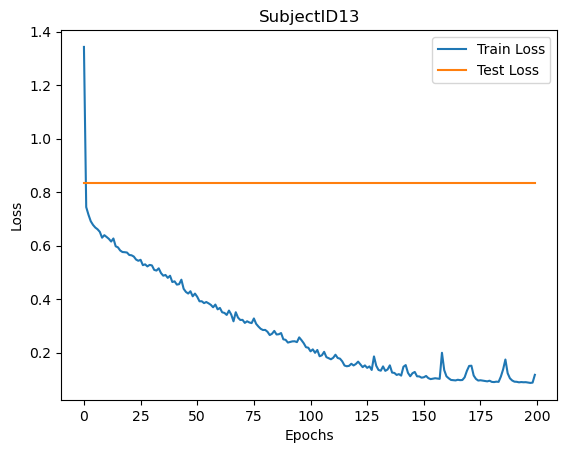

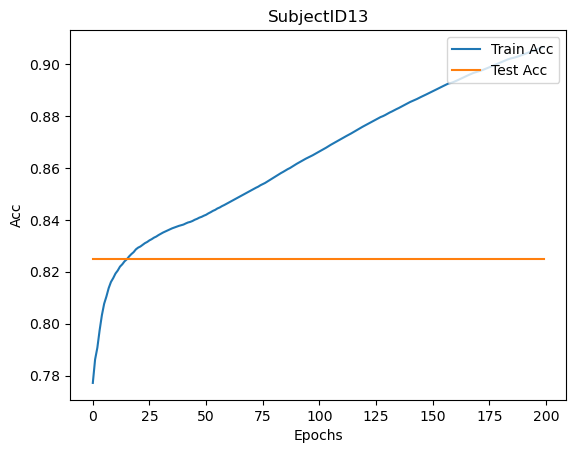


Subject 14
| epoch   0 | 0.0390 s/epoch | train loss 1.3637
| epoch   1 | 0.0381 s/epoch | train loss 0.7886
| epoch   2 | 0.0385 s/epoch | train loss 0.7483
| epoch   3 | 0.0389 s/epoch | train loss 0.7389
| epoch   4 | 0.0382 s/epoch | train loss 0.7302
| epoch   5 | 0.0391 s/epoch | train loss 0.7114
| epoch   6 | 0.0381 s/epoch | train loss 0.6990
| epoch   7 | 0.0392 s/epoch | train loss 0.6777
| epoch   8 | 0.0398 s/epoch | train loss 0.6770
| epoch   9 | 0.0397 s/epoch | train loss 0.6587
| epoch  10 | 0.0390 s/epoch | train loss 0.6548
| epoch  11 | 0.0391 s/epoch | train loss 0.6542
| epoch  12 | 0.0386 s/epoch | train loss 0.6414
| epoch  13 | 0.0389 s/epoch | train loss 0.6170
| epoch  14 | 0.0387 s/epoch | train loss 0.6173
| epoch  15 | 0.0399 s/epoch | train loss 0.6060
| epoch  16 | 0.0387 s/epoch | train loss 0.5916
| epoch  17 | 0.0381 s/epoch | train loss 0.5796
| epoch  18 | 0.0400 s/epoch | train loss 0.5986
| epoch  19 | 0.0389 s/epoch | train loss 0.5654
| epoch 

| epoch 167 | 0.0401 s/epoch | train loss 0.1060
| epoch 168 | 0.0397 s/epoch | train loss 0.1064
| epoch 169 | 0.0387 s/epoch | train loss 0.1056
| epoch 170 | 0.0383 s/epoch | train loss 0.1052
| epoch 171 | 0.0390 s/epoch | train loss 0.1035
| epoch 172 | 0.0398 s/epoch | train loss 0.1051
| epoch 173 | 0.0383 s/epoch | train loss 0.1051
| epoch 174 | 0.0398 s/epoch | train loss 0.1042
| epoch 175 | 0.0387 s/epoch | train loss 0.1095
| epoch 176 | 0.0397 s/epoch | train loss 0.1204
| epoch 177 | 0.0392 s/epoch | train loss 0.1395
| epoch 178 | 0.0390 s/epoch | train loss 0.1557
| epoch 179 | 0.0395 s/epoch | train loss 0.1529
| epoch 180 | 0.0387 s/epoch | train loss 0.1223
| epoch 181 | 0.0389 s/epoch | train loss 0.1069
| epoch 182 | 0.0401 s/epoch | train loss 0.1030
| epoch 183 | 0.0383 s/epoch | train loss 0.1015
| epoch 184 | 0.0371 s/epoch | train loss 0.1013
| epoch 185 | 0.0388 s/epoch | train loss 0.0997
| epoch 186 | 0.0385 s/epoch | train loss 0.1004
| epoch 187 | 0.0387

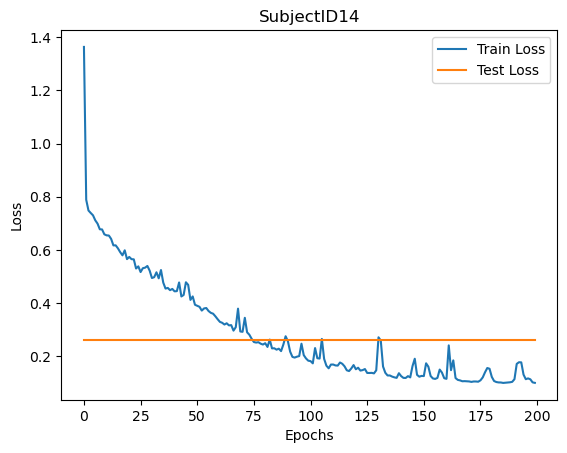

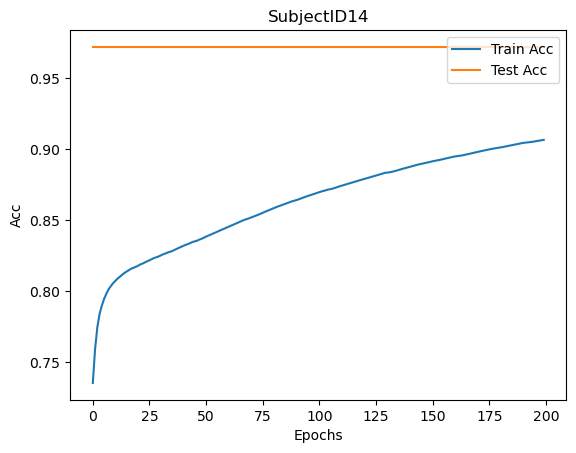


Subject 15
| epoch   0 | 0.0398 s/epoch | train loss 1.3496
| epoch   1 | 0.0409 s/epoch | train loss 0.7564
| epoch   2 | 0.0398 s/epoch | train loss 0.7182
| epoch   3 | 0.0405 s/epoch | train loss 0.7064
| epoch   4 | 0.0417 s/epoch | train loss 0.6844
| epoch   5 | 0.0400 s/epoch | train loss 0.6797
| epoch   6 | 0.0390 s/epoch | train loss 0.6704
| epoch   7 | 0.0401 s/epoch | train loss 0.6541
| epoch   8 | 0.0408 s/epoch | train loss 0.6392
| epoch   9 | 0.0406 s/epoch | train loss 0.6446
| epoch  10 | 0.0408 s/epoch | train loss 0.6478
| epoch  11 | 0.0399 s/epoch | train loss 0.6106
| epoch  12 | 0.0410 s/epoch | train loss 0.6095
| epoch  13 | 0.0391 s/epoch | train loss 0.5926
| epoch  14 | 0.0399 s/epoch | train loss 0.5796
| epoch  15 | 0.0412 s/epoch | train loss 0.5713
| epoch  16 | 0.0402 s/epoch | train loss 0.5637
| epoch  17 | 0.0418 s/epoch | train loss 0.5635
| epoch  18 | 0.0398 s/epoch | train loss 0.5470
| epoch  19 | 0.0408 s/epoch | train loss 0.5355
| epoch 

| epoch 167 | 0.0407 s/epoch | train loss 0.0857
| epoch 168 | 0.0409 s/epoch | train loss 0.0851
| epoch 169 | 0.0401 s/epoch | train loss 0.0833
| epoch 170 | 0.0400 s/epoch | train loss 0.0822
| epoch 171 | 0.0415 s/epoch | train loss 0.0818
| epoch 172 | 0.0405 s/epoch | train loss 0.0845
| epoch 173 | 0.0416 s/epoch | train loss 0.0917
| epoch 174 | 0.0391 s/epoch | train loss 0.0936
| epoch 175 | 0.0399 s/epoch | train loss 0.0977
| epoch 176 | 0.0410 s/epoch | train loss 0.1345
| epoch 177 | 0.0403 s/epoch | train loss 0.1465
| epoch 178 | 0.0398 s/epoch | train loss 0.1239
| epoch 179 | 0.0395 s/epoch | train loss 0.0942
| epoch 180 | 0.0397 s/epoch | train loss 0.0851
| epoch 181 | 0.0399 s/epoch | train loss 0.0810
| epoch 182 | 0.0402 s/epoch | train loss 0.0800
| epoch 183 | 0.0408 s/epoch | train loss 0.0780
| epoch 184 | 0.0407 s/epoch | train loss 0.0776
| epoch 185 | 0.0394 s/epoch | train loss 0.0776
| epoch 186 | 0.0406 s/epoch | train loss 0.0772
| epoch 187 | 0.0408

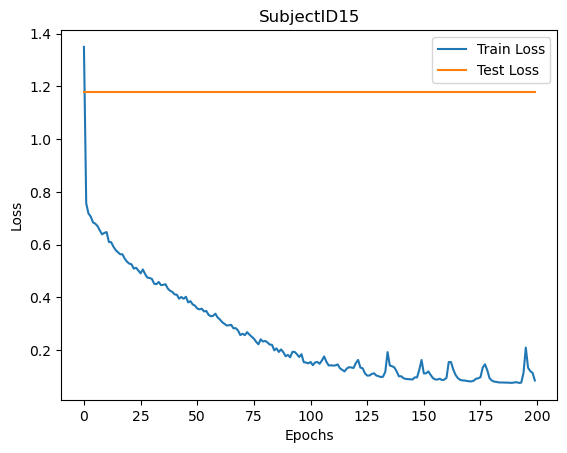

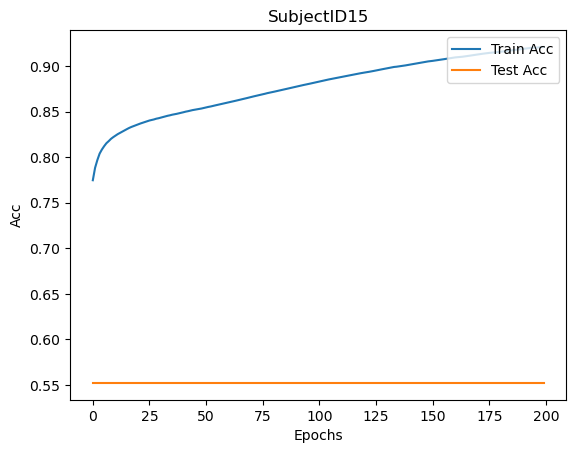

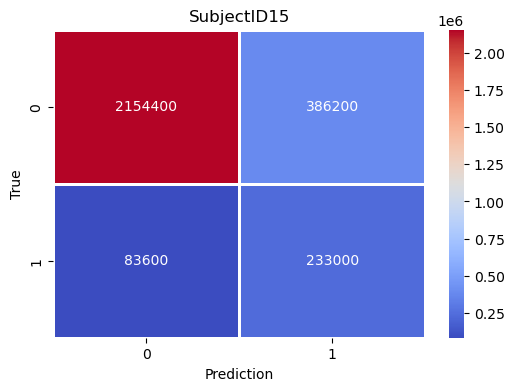

Distillation_student(CNNSmall)_Acc: 0.8355732885342293
Distillation_student(CNNSmall)_Rec: 0.7359444093493367
Distillation_student(CNNSmall)_Pre: 0.37629198966408267
Distillation_student(CNNSmall)_F1: 0.4979696516349647


<Figure size 640x480 with 0 Axes>

In [19]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_Distillation_student = Net_Teacher_Student(config).to(device) 
    model_Distillation_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])



In [20]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops:',flops_teacher, 'params', params_teachar)
print('flops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))


dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('\nflops:',flops_student, 'params', params_student)
print('flops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('\nflops:',flops_teacher_student, 'params', params_teacher_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))

flops_Distillation_student, params_Distillation_student = profile(model_Distillation_student,(dummy_input,))
print('\nflops:',flops_Distillation_student, 'params', params_Distillation_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_Distillation_student / 1000.0, params_Distillation_student / 1000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops: 4743020544.0 params 42495426.0
flops_teacher: 4743.021 M, params_teachar: 42.495 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

flops: 10412032.0 params 120066.0
flops_student: 10412.032 K, params_student: 120.066 K
[INFO] Register cou